# XGBoost Disease Classifiers

1. Set-up: Functions and packages
2. Import full dataset and a smaller subset (10% of whole dataset)
3. Test and Train Data
  - Split
  - Undersampling
4. Model Building and Evaluation
  - Diabetes Classifier
  - Pulomonary Disease Classifier
  - Other Cancers Classifier
  - Arthritis Classifier
  - Kidney Classifier
  - Skin Cancer Classifier
  - CVD Classifier
  - Asthma Classifier
5. Saving all measures to a dataframe
  - Export as csv

## NOTE: If run with full dataset this notebook takes 10-15 mins to run

## Functions and packages

In [1]:
### Packages ###

# IF INSTALLATION NEEDED
#install.packages("ROSE")
#install.packages("xgboost")

library(ROSE)
library(randomForest)
library(caret)
library(e1071)
library(xgboost)

Warning message:
"package 'ROSE' was built under R version 4.0.5"
Loaded ROSE 0.0-4


Warning message:
"package 'randomForest' was built under R version 4.0.5"
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Warning message:
"package 'caret' was built under R version 4.0.5"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.0.5"

Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 4.0.5"
Warning message:
"package 'e1071' was built under R version 4.0.5"
Warning message:
"package 'xgboost' was built under R version 4.0.5"


In [2]:
#install.packages("RColorBrewer")
library(RColorBrewer)
p <- brewer.pal(n = 5, name = "YlOrRd") # setting colour palette for graphs

Warning message:
"package 'RColorBrewer' was built under R version 4.0.5"


In [3]:
### No Global Variables ###

In [4]:
### Functions taken from Lab 4 (tweaked for XGBoost compatibility) ###

# INPUT: numeric - TP, FN, FP, TN
# OUTPUT: A list with the following entries:
    #
    # TP - double - True Positive records
    # FP - double - False Positive records
    # TN - double - True Negative records
    # FN - double - False Negative records

    # accuracy - double - accuracy measure
    # precision - double - Positive Predictive value (precision)
    # NPV - double - Negative Predictive value (NPV)
    # FPR - double - False Positive Rate
    # TPR - double - True Positive Rate (sensitivity/recall/hit rate)
    # TNR - double - True Negative Rate (specificty)
    # MCC - double - Mathew's Correlation Coefficient
    # FNR - double - False Negative Rate (miss rate)
    # F1 - double - F1 Score (Harmonic mean of precision and sensitivity)
    # TS - double - Threat Score/Critical Success Index (CSI)/Jaccard index

calcMeasures <- function(TP,FN,FP,TN){
  accuracy<-round(100.0*((TP+TN)/(TP+FP+FN+TN)), digits=2)
  precision<-round(100.0*(TP/(TP+FP)),digits=2)
  npv    <-round(100.0*(TN/(FN+TN)),digits=2)
  fpr     <-round(100.0*(FP/(FP+TN)),digits=2)
  tpr     <-round(100.0*(TP/(TP+FN)),digits=2)
  tnr     <-round(100.0*(TN/(FP+TN)),digits=2)
  mcc     <-round( ((TP*TN)-(FP*FN))/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),digits=3)
  fnr     <-round(100.0*(FN/(FN+TP)),digits=2)
  f1      <-round(100.0*((2 * TP)/((2 * TP)+FP+FN)),digits=2)
  threatScore<-round(100.0*(TP/(TP+FN+FP)),digits=2)
    
    retList<-list("TP"=TP,
                  "FN"=FN,
                  "TN"=TN,
                  "FP"=FP,
                  "accuracy"=accuracy,
                  "precision"=precision,
                  "NPV"=npv,
                  "FPR"=fpr,
                  "TPR"=tpr,
                  "TNR"=tnr,
                  "MCC"=mcc,
                  "FNR"=fnr,
                  "F1"=f1,
                  "ThreatScore"=threatScore
    )
    return(retList)
}

# ************************************************
# getTreeClassifications() :
#
# Put in test dataset and get out class predictions of the decision tree
# Determine the threshold, plot the results and calculate metrics
#
# INPUT   :   object         - myTree       - tree
#         :   Data Frame     - testDataset  - dataset to evaluate
#         :   string         - title        - string to plot as the chart title
#         :   int            - classLabel   - lable given to the positive (TRUE) class
#         :   boolean        - plot         - TRUE to output results/charts
#
# OUTPUT  :   List       - Named evaluation measures
#
# ************************************************
getTreeClassifications<-function(myTree,
                                 test_expected,
                                 test_predicted,
                                 title,
                                 classLabel=1,
                                 plot=TRUE
                                 ){

  measures<-NdetermineThreshold(test_expected=test_expected,
                                test_predicted=test_predicted,
                                plot=plot,
                                title=title)

  #if (plot==TRUE)
    #NprintMeasures(results=measures,title=title)

  return(measures)

} #endof getTreeClassifications()

# ************************************************
# NdetermineThreshold() :
#
# For the range of threholds [0,1] calculate a confusion matrix
# and classifier metrics.
# Deterime "best" threshold based on either distance or Youdan
# Plot threshold chart and ROC chart
#
# Plot the results
#
# INPUT   :   vector double  - test_predicted   - probability of being class 1
#         :   vector double  - test_expected    - dataset to evaluate
#         :   boolean        - plot             - TRUE=output charts
#         :   string         - title            - chart title
#
# OUTPUT  :   List       - Named evaluation measures from confusion matrix
#                        - Threshold at min Euclidean distance
#                        - AUC - area under the ROC curve
#                        - Predicted class probability
#
# 241019NRT - added plot flag and title for charts
# 311019NRT - added axis bound checks in abline plots
# 191020NRT - Updated to use own ROC plot & calculate AUC
# ************************************************
NdetermineThreshold<-function(test_predicted,
                              test_expected,
                              plot=TRUE,
                              title=""){
  toPlot<-data.frame()

  #Vary the threshold
  for(threshold in seq(0,1,by=0.01)){
    results<-NEvaluateClassifier(test_predicted=test_predicted,
                                  test_expected=test_expected,
                                  threshold=threshold)
    toPlot<-rbind(toPlot,data.frame(x=threshold,fpr=results$FPR,tpr=results$TPR, balancedacc=results$balancedacc, threatScore=results$threatScore, fnr=results$FNR))
  }

  # Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
  # To the top left (i.e. perfect classifier)
  toPlot$distance<-sqrt(((1-toPlot$tpr)^2)+((toPlot$fpr)^2))

  # 121020NRT - Euclidean distance to "perfect" classifier (smallest the best)
  # use which.min() to return a single index to the lowest value in the vector
  minEuclidean<-toPlot$x[which.min(toPlot$distance)]

  # ************************************************
  # Plot threshold graph

  if (plot==TRUE){
    # Sensitivity (TPR)
    plot(toPlot$x,toPlot$tpr,
         xlim=c(0, 1), ylim=c(0, 1), cex.lab=1.2,
         type="l",lwd=3, col="blue",
         xlab="Threshold",
         ylab="Metrics",
         main=paste("Threshold Perfomance Classifier Model",title))

    # Plot the specificity (1-FPR)
    lines(toPlot$x,1-toPlot$fpr,type="l",col="red",lwd=3,lty=1)
      
    # plot the threat score
    lines(toPlot$x,toPlot$threatScore,type="l",col="orange",lwd=3,lty=1)
      
    # plot the miss rate
    lines(toPlot$x,toPlot$fnr,type="l",col="purple",lwd=3,lty=1)
    
    # The point where specificity and sensitivity are the same
    crosspoint<-toPlot$x[which(toPlot$tpr<(1-toPlot$fpr))[1]]

    # Plot the Euclidean distance to "perfect" classifier (smallest the best)
    lines(toPlot$x,toPlot$distance,type="l",col="green",lwd=2,lty=3)

    # Plot the min distance, as might be more (311019NRT check it is within range)
    if ((minEuclidean<1) & (minEuclidean>0))
      abline(v=minEuclidean,col="green",lty=3,lwd=2)
      
    # set the legend - you can change position to "bottomright", "bottom", "bottomleft", "left",
    # "topleft", "top", "topright", "right" and "center" as per what your graph looks like
    legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),lty=1,lwd=2)
    text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

    # ************************************************
    # ROC graph
      
    balacc <- toPlot$balancedacc[which.min(toPlot$distance)]
    sensitivityROC<-toPlot$tpr[which.min(toPlot$distance)]
    specificityROC<-1-toPlot$fpr[which.min(toPlot$distance)]

    # Set origin point for plotting
    toPlot<-rbind(toPlot,data.frame(x=0,fpr=0,tpr=0 ,distance=0, threatScore=0, fnr=0, balancedacc=0))

    plot(1-toPlot$fpr,toPlot$tpr,type="l",lwd=3, col="black",
         main=paste("ROC:",title),
         cex.lab=1.2,
         xlab="Specificity (1-FPR)", 
         ylab="Sensitivity (TPR)",
         xlim=c(1,0),
         ylim=c(0,1)
    )

    axis(1, seq(0.0,1.0,0.1))
    axis(2, seq(0.0,1.0,0.1))

    #Add crosshairs to the graph
    abline(h=sensitivityROC,col="red",lty=3,lwd=2)
    abline(v=specificityROC,col="red",lty=3,lwd=2)

    annotate<-paste("Threshold: ",round(minEuclidean,digits=4L),
                    "\nBalanced Acc.: ",round(balacc,digits=4L),
                    "\nSensitivity: ",round(sensitivityROC,digits=2L),
                    "\nSpecificity: ",round(specificityROC,digits=2L),
                    sep="")

    text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1, col="red",annotate)

  } # endof if plotting

  # Select the threshold - I have choosen distance

  myThreshold<-minEuclidean      # Min Distance should be the same as analysis["threshold"]

  #Use the "best" distance threshold to evaluate classifier
  results<-NEvaluateClassifier(test_predicted=test_predicted,
                                test_expected=test_expected,
                                threshold=myThreshold)

  results$threshold<-myThreshold

 # view the results values for that particular threshold - you will need to add these to a table yourself after
 # repeating for all 8 diseases
  View(results)
  return(results)

} #endof myPerformancePlot()

# ************************************************
# NEvaluateClassifier() :
#
# Use dataset to generate predictions from model
# Evaluate as classifier using threshold value
#
# INPUT   :   vector double     - probs        - probability of being class 1
#             Data Frame        - testing_data - Dataset to evaluate
#             double            - threshold     -cutoff (probability) for classification
#
# OUTPUT  :   List       - Named evaluation measures
#                        - Predicted class probability
#
# ************************************************
NEvaluateClassifier<-function(test_predicted,test_expected,threshold) {

  predictedClass<-ifelse(test_predicted<threshold,0,1)

  results<-NcalcConfusion(expectedClass=test_expected,
                          predictedClass=predictedClass)

  return(results)
} #endof NEvaluateClassifier()

NcalcConfusion<-function(expectedClass,predictedClass){

  confusion<-table(factor(predictedClass,levels=0:1),factor(expectedClass,levels=0:1))

  # This "converts" the above into our preferred format

  TP<-as.double(confusion[2,2])
  FN<-as.double(confusion[1,2])
  FP<-as.double(confusion[2,1])
  TN<-as.double(confusion[1,1])

  return(NcalcMeasures(TP,FN,FP,TN))

} #endof NcalcConfusion()

NcalcMeasures <- function(TP,FN,FP,TN){
  npv    <-round((TN/(FN+TN)),digits=4)
  fpr     <-round((FP/(FP+TN)),digits=4)
  tpr     <-round((TP/(TP+FN)),digits=4) # recall, sensitivity
  tnr     <-round((TN/(FP+TN)),digits=4) #specificity
  fnr     <-round((FN/(FN+TP)),digits=4) 
  threatScore    <-round((TP/(TP+FN+FP)),digits=4)
  balancedacc    <-round(((tpr+tnr)/2),digits=4)
    
    retList<-list("TP"=TP,
                  "FN"=FN,
                  "TN"=TN,
                  "FP"=FP,
                  "NPV"=npv,
                  "FPR"=fpr,
                  "TPR"=tpr,
                  "TNR"=tnr,
                  "FNR"=fnr,
                  "threatScore"=threatScore,
                  "balancedacc"=balancedacc
    )
    return(retList)
}

# ************************************************
# metricsToRealWorld() :
#
# Adjust metrics to an assumed real-world sample
# Here we assume that the dataset has been sampled and needs to be 'corrected'
# We have already calculated for the training dataset
# classBalance = model(bad)/model(good)
#
# INPUT   :   Data Frame     - dataset   - original dataset
#         :   Data Frame     - measures  - performance metrics
#         :   double         - natural   - bad debt rate in natural population
#
# OUTPUT  :
#         :   Data Frame     - measures  - adjusted performance metrics
#
# ************************************************
metricsToRealWorld<-function(dataset,measures,natural){

  positionClassOutput=which(names(dataset)==OUTPUT_FIELD)

  #Status is encoded as: 1 = Bad Loan, 0 = Good loan
  #Calculate class balance ratio, rm = bad / good
  ClassGood<-length(which(dataset[,positionClassOutput]==1))
  ClassBad<-length(which(dataset[,positionClassOutput]==0))

  classBalance<-ClassBad/ClassGood
  print(paste("Class balance, bad:good=",round(classBalance,digits=2)))

  # This equates to a bad debt rate of...
  print(paste("Bad debt rate in dataset=",round((ClassBad/nrow(dataset))*100,digits=2),"%",sep=""))

  # sg = rm / rn
  sg<-classBalance/natural

  # Adjust the results to reflect the natural dataset
  # P (being good loans) = TP+TN
  # So we will increase P * sg, which will then give the estimated natural class balance
  # in the results

  TP<-round(measures$TP*sg,digits=0)
  FN<-round(measures$FN*sg,digits=0)
  TN=measures$TN
  FP=measures$FP

  adjustedMeasureas<-NcalcMeasures(TP,FN, FP, TN )

    print('Adjusted Measures:', adjustedMeasureas) 
  #NprintMeasures(results=adjustedMeasureas,
                 #title=paste("Real world adjust",natural))

  # You'd expect (FP+TN)/(TP+FN) to be close to naturalClassBalance

  adjustedMeasureas$threshold=measures$threshold

  #adjustedMeasureas$AUC<-measures$AUC  #201020NRT copy AUC

  return(adjustedMeasureas)
} #endof metricsToRealWorld()
# ************************************************
# NprintMeasures()
#
# Output measures to the Viewer
#
# INPUT:    list -   results - results from NcalcConfusion()
#           string - title   - title of the table
#
# OUTPUT :  NONE
#
# 070819NRT updated to output table to viewer only
# 171019NRT added column name "Metric"
# 241019NRT added title
# ************************************************
NprintMeasures<-function(results,title){

  #This outputs our results into the "Viewer" in RStudio
  tidyTable<-data.frame(t(t(results)))
  names(tidyTable)[1]<-title

  t<-formattable::formattable(tidyTable,list(
    TP = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",TP)),
    FN = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",FN)),
    TN = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",TN)),
    FP = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",FP))))
  print(t)
}

## Import data

In [5]:
# Small dataset used for model testing
newDataset <- read.csv(file = 'brfssCleanedSmall.csv')
dim(newDataset)

[1] 40195    62

In [6]:
# Larger complete dataset
bigDataset <- read.csv(file = 'brfssCleaned.csv')
dim(bigDataset)

[1] 401958     62

## Test and Train Split

In [7]:
#Train and test data split for smaller dataset + undersampling
set.seed(100)
ind <- sample(nrow(newDataset), 0.7*nrow(newDataset), replace = FALSE)
train <- newDataset[ind,]
test <- newDataset[-ind,]

undersampleASTH <- ovun.sample(ASTHMA3~., data = train, method = "under", p = 0.5)$data
undersampleHEART <- ovun.sample(CVDCRHD4~., data = train, method = "under", p = 0.5)$data
undersampleSKIN <- ovun.sample(CHCSCNCR~., data = train, method = "under", p = 0.5)$data
undersampleKIDNEY <- ovun.sample(CHCKDNY2~., data = train, method = "under", p = 0.5)$data
undersampleARTH <- ovun.sample(HAVARTH4~., data = train, method = "under", p = 0.5)$data
undersampleCANCER <- ovun.sample(CHCOCNCR~., data = train, method = "under", p = 0.5)$data
undersampleLUNG <- ovun.sample(CHCCOPD2~., data = train, method = "under", p = 0.5)$data
undersampleDIAB <- ovun.sample(DIABETE4~., data = train, method = "under", p = 0.5)$data

In [8]:
#Train and test data split for larger dataset + undersampling
set.seed(100)
ind <- sample(nrow(bigDataset), 0.7*nrow(bigDataset), replace = FALSE)
train <- bigDataset[ind,]
test2 <- bigDataset[-ind,]

undersampleASTH2 <- ovun.sample(ASTHMA3~., data = train, method = "under", p = 0.5)$data
undersampleHEART2 <- ovun.sample(CVDCRHD4~., data = train, method = "under", p = 0.5)$data
undersampleSKIN2 <- ovun.sample(CHCSCNCR~., data = train, method = "under", p = 0.5)$data
undersampleKIDNEY2 <- ovun.sample(CHCKDNY2~., data = train, method = "under", p = 0.5)$data
undersampleARTH2 <- ovun.sample(HAVARTH4~., data = train, method = "under", p = 0.5)$data
undersampleCANCER2 <- ovun.sample(CHCOCNCR~., data = train, method = "under", p = 0.5)$data
undersampleLUNG2 <- ovun.sample(CHCCOPD2~., data = train, method = "under", p = 0.5)$data
undersampleDIAB2 <- ovun.sample(DIABETE4~., data = train, method = "under", p = 0.5)$data

# Diabetes Classifier

In [9]:
#DIABETES
data_col_index = 21
train = undersampleDIAB

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)

TN <- cm[1]
TP <- cm[4]
FP <- cm[2]
FN <- cm[3]

print(evaluation)
calcMeasures(TP,FN,FP,TN)

Confusion Matrix and Statistics

    obs
pred    0    1
   0 7297  318
   1 3248 1196
                                          
               Accuracy : 0.7043          
                 95% CI : (0.6961, 0.7124)
    No Information Rate : 0.8745          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2635          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6920          
            Specificity : 0.7900          
         Pos Pred Value : 0.9582          
         Neg Pred Value : 0.2691          
             Prevalence : 0.8745          
         Detection Rate : 0.6051          
   Detection Prevalence : 0.6315          
      Balanced Accuracy : 0.7410          
                                          
       'Positive' Class : 0               
                                          


Warning message in (TP + FP) * (TP + FN) * (TN + FP):
"NAs produced by integer overflow"


$TP
[1] 1196

$FN
[1] 318

$TN
[1] 7297

$FP
[1] 3248

$accuracy
[1] 70.43

$precision
[1] 26.91

$NPV
[1] 95.82

$FPR
[1] 30.8

$TPR
[1] 79

$TNR
[1] 69.2

$MCC
[1] NA

$FNR
[1] 21

$F1
[1] 40.15

$ThreatScore
[1] 25.12

[1] "Best max_depth: 5"
[1] "New balanced accuracy: 0.742338646788344"


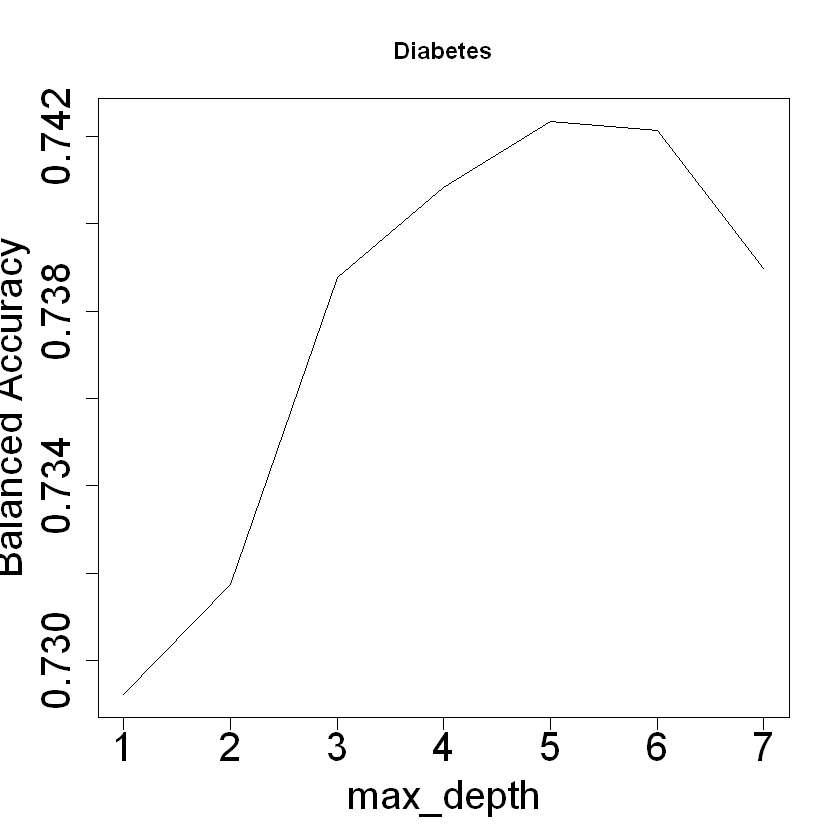

In [10]:
# Check max_depth
accuracy8<-c()
max_depth <- c(1:7)
for (i in 1:7){
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=i, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[i] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(max_depth, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Diabetes', cex.lab=2, cex.axis=2)
# Extract best value for max_depth
print(paste("Best max_depth:",max_depth[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best eta: 0.15"
[1] "New balanced accuracy: 0.744704459030399"


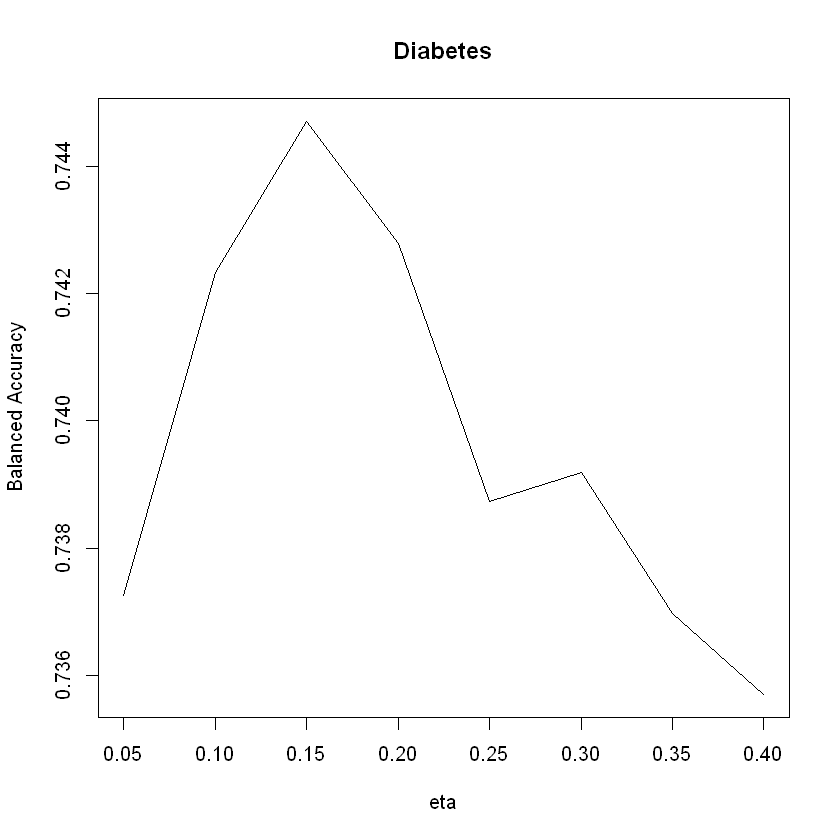

In [11]:
# Check eta
accuracy8<-c()
eta <- seq(0.05, 0.4, by=0.05)
for (i in eta){
index<-match(i,eta)
    #print(index)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=5, eta=i, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(eta, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Diabetes')
# Extract best value for eta
print(paste("Best eta:",eta[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best nrounds: 28"
[1] "New balanced accuracy: 0.747351446558844"


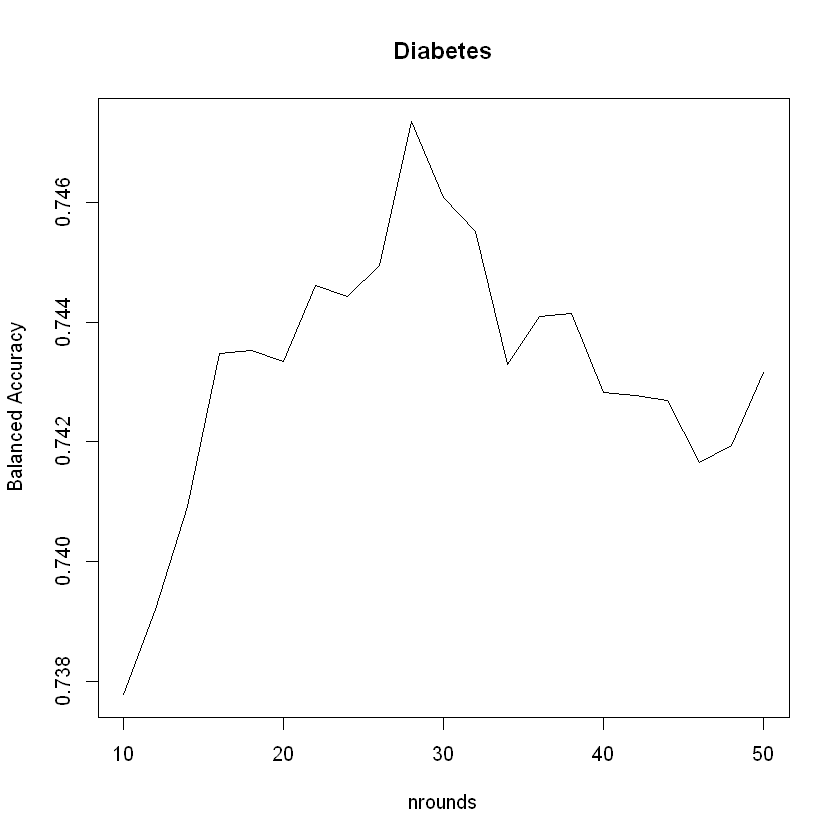

In [12]:
# Check nrounds
accuracy8<-c()
nrounds <- seq(10, 50, by=2)
for (i in nrounds){
index<-match(i,nrounds)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=i, max_depth=5, eta=0.15, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(nrounds, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Diabetes')
# Extract best value for nrounds
print(paste("Best nrounds:",nrounds[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))
    

$TP
[1] 11933

$FN
[1] 3669

$TN
[1] 77971

$FP
[1] 27015

$NPV
[1] 0.9551

$FPR
[1] 0.2573

$TPR
[1] 0.7648

$TNR
[1] 0.7427

$FNR
[1] 0.2352

$threatScore
[1] 0.28

$balancedacc
[1] 0.7538

$threshold
[1] 0.54

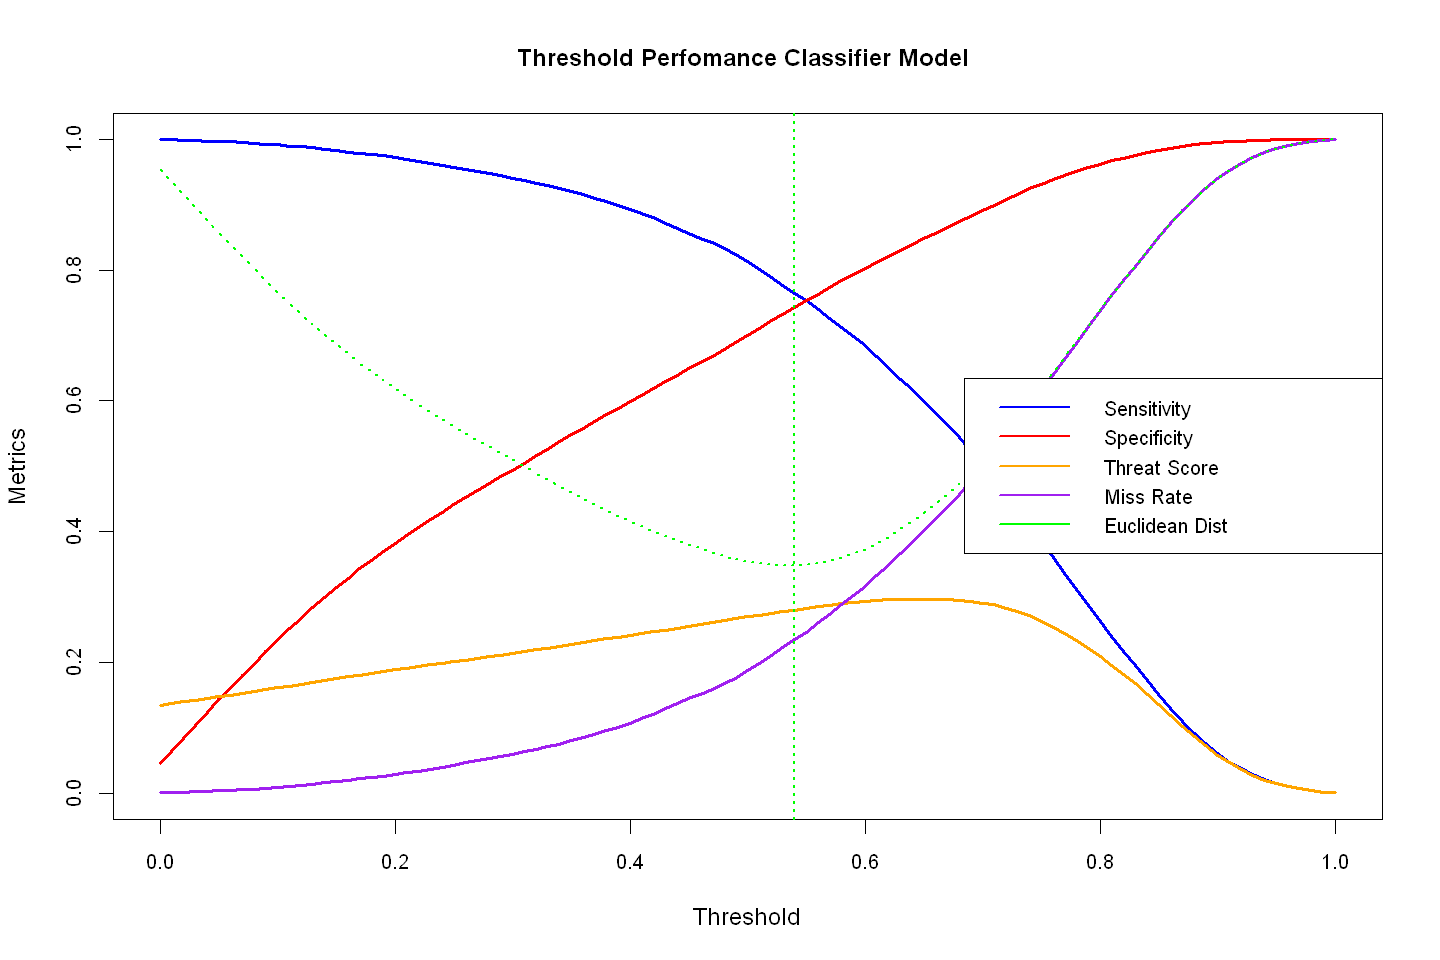

Time difference of 38.14189 secs


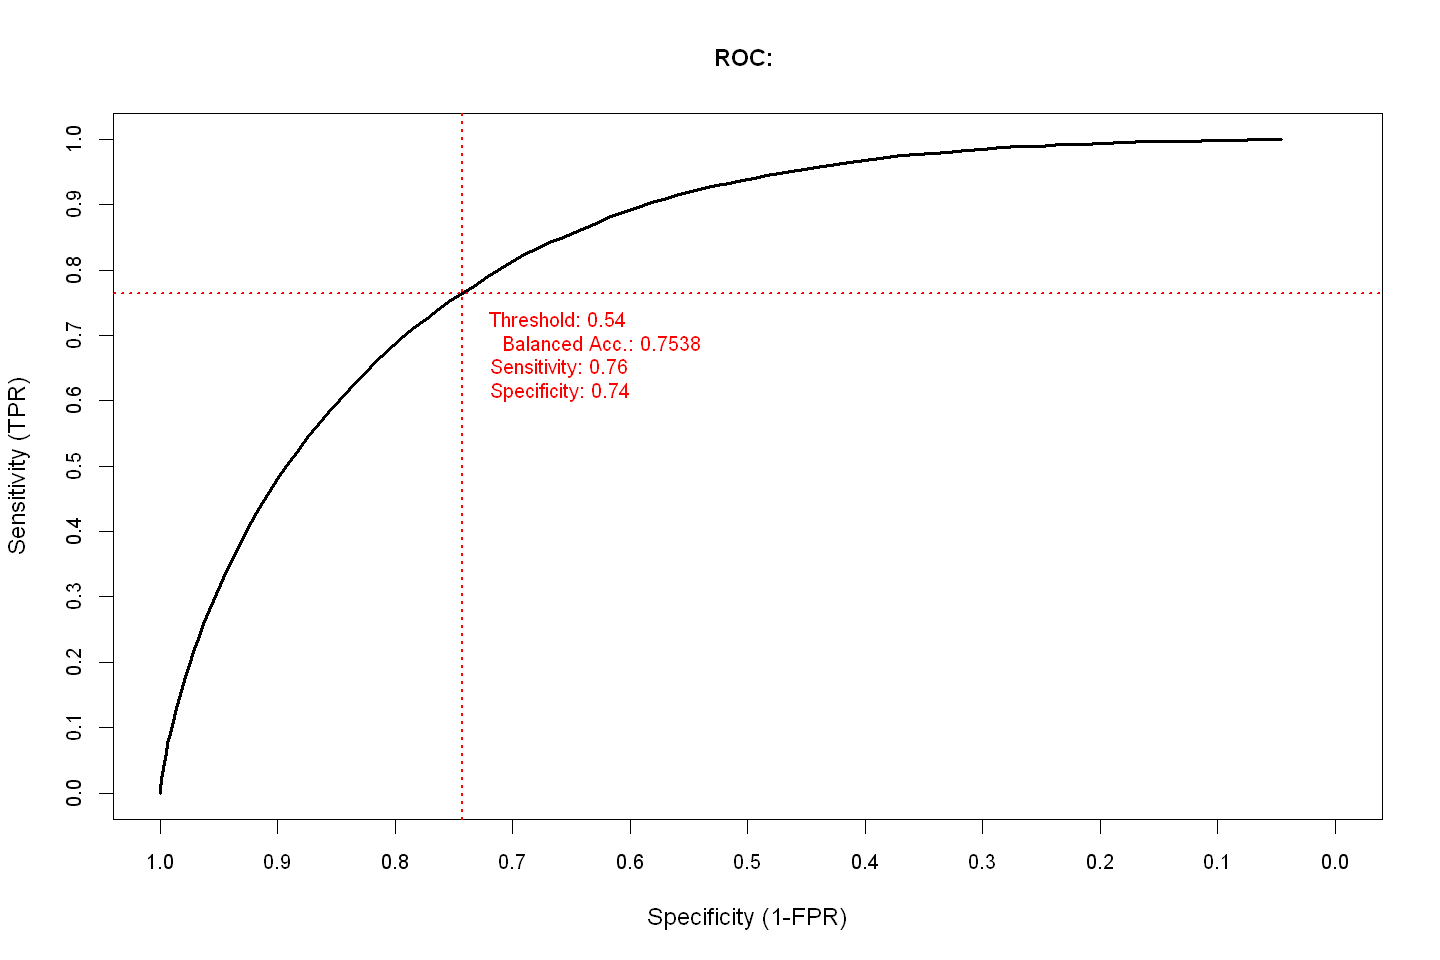

In [13]:
### Implement final model on big dataset with best parameters to determine threshold ###

start_time <- Sys.time()

# DIABETES
data_col_index = 21
train = undersampleDIAB2 # full training dataset
test = test2 # full testing dataset

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with best nrounds, max_depth, eta
xgbc = xgboost(data=xgb_train, nrounds=28, max_depth=5, eta=0.15, verbose=0)

# Fit the model
pred = predict(xgbc,xgb_test)

### Determine best threshold ###

#setting options for this cell for better viewing
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)

#calling function to plot graphs and view values
measures_Diabetes<-getTreeClassifications(myTree = xgbc,
                                           test_y,
                                           pred,
                                           title='',
                                           plot=TRUE)

end_time <- Sys.time()
print(end_time - start_time)

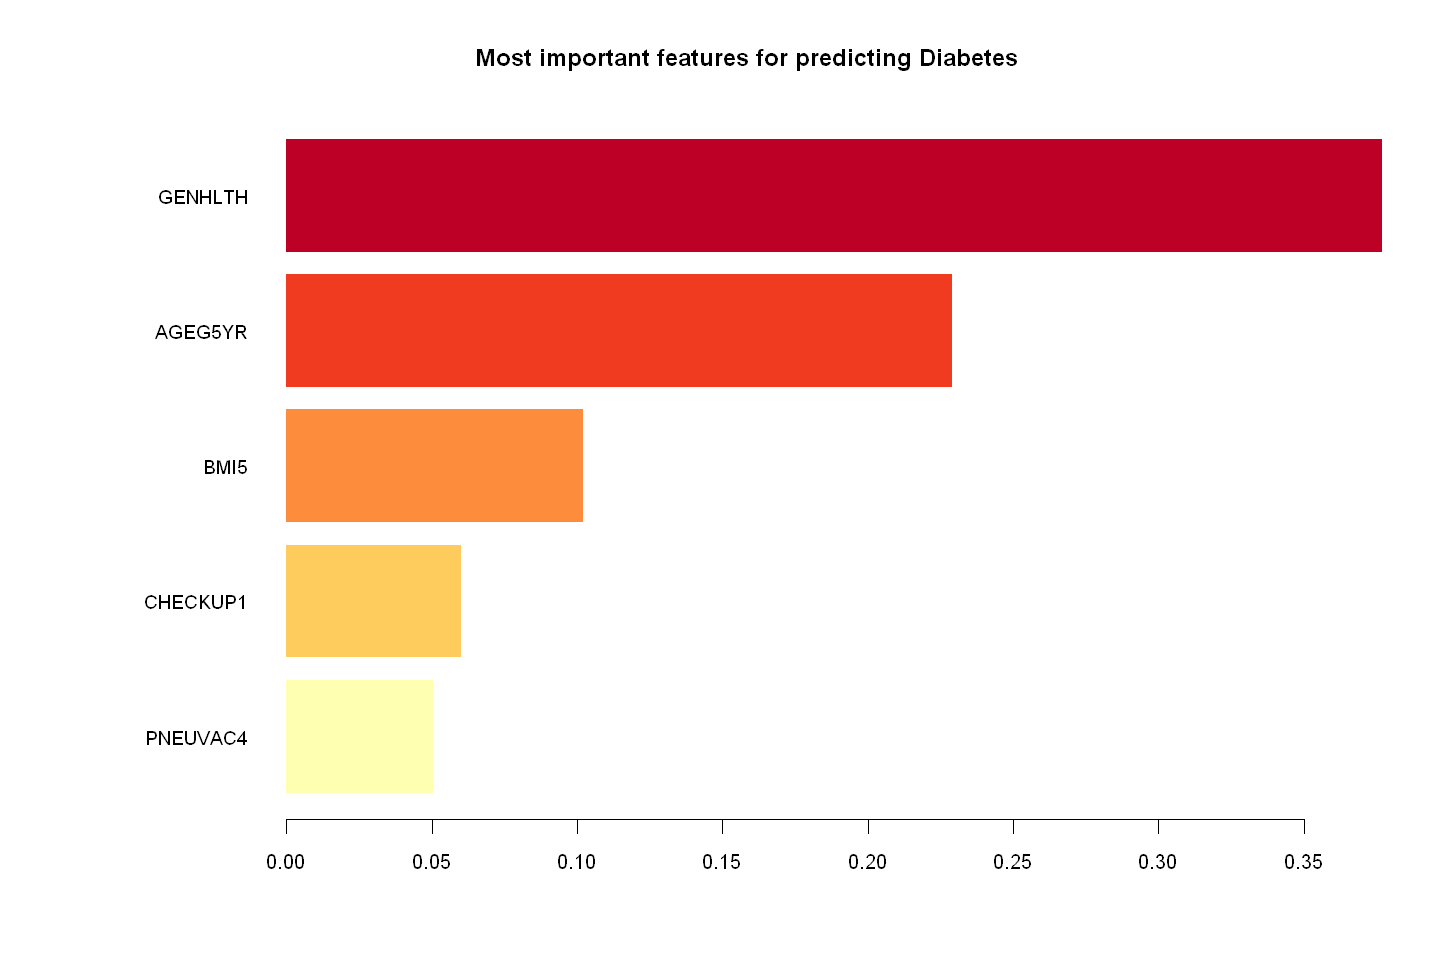

In [14]:
### Further Evaluation and Model Tweaking ###

# Compute feature importance matrix
importance_matrix = xgb.importance(colnames(xgb_train), model = xgbc)

# Plotting importances
xgb.plot.importance(importance_matrix[1:5,], col=p)
title("Most important features for predicting Diabetes")

## Pulmonary Disease Classifier

In [15]:
#PULMONARYDISEASE
data_col_index = 17
train = undersampleLUNG

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)

TN <- cm[1]
TP <- cm[4]
FP <- cm[2]
FN <- cm[3]

print(evaluation)
calcMeasures(TP,FN,FP,TN)

Confusion Matrix and Statistics

    obs
pred     0     1
   0 85416  2098
   1 25772  7302
                                          
               Accuracy : 0.7689          
                 95% CI : (0.7665, 0.7713)
    No Information Rate : 0.922           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2532          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7682          
            Specificity : 0.7768          
         Pos Pred Value : 0.9760          
         Neg Pred Value : 0.2208          
             Prevalence : 0.9220          
         Detection Rate : 0.7083          
   Detection Prevalence : 0.7257          
      Balanced Accuracy : 0.7725          
                                          
       'Positive' Class : 0               
                                          


Warning message in (TP + FP) * (TP + FN) * (TN + FP):
"NAs produced by integer overflow"


$TP
[1] 7302

$FN
[1] 2098

$TN
[1] 85416

$FP
[1] 25772

$accuracy
[1] 76.89

$precision
[1] 22.08

$NPV
[1] 97.6

$FPR
[1] 23.18

$TPR
[1] 77.68

$TNR
[1] 76.82

$MCC
[1] NA

$FNR
[1] 22.32

$F1
[1] 34.38

$ThreatScore
[1] 20.76

[1] "Best max_depth: 3"
[1] "New balanced accuracy: 0.786857031104688"


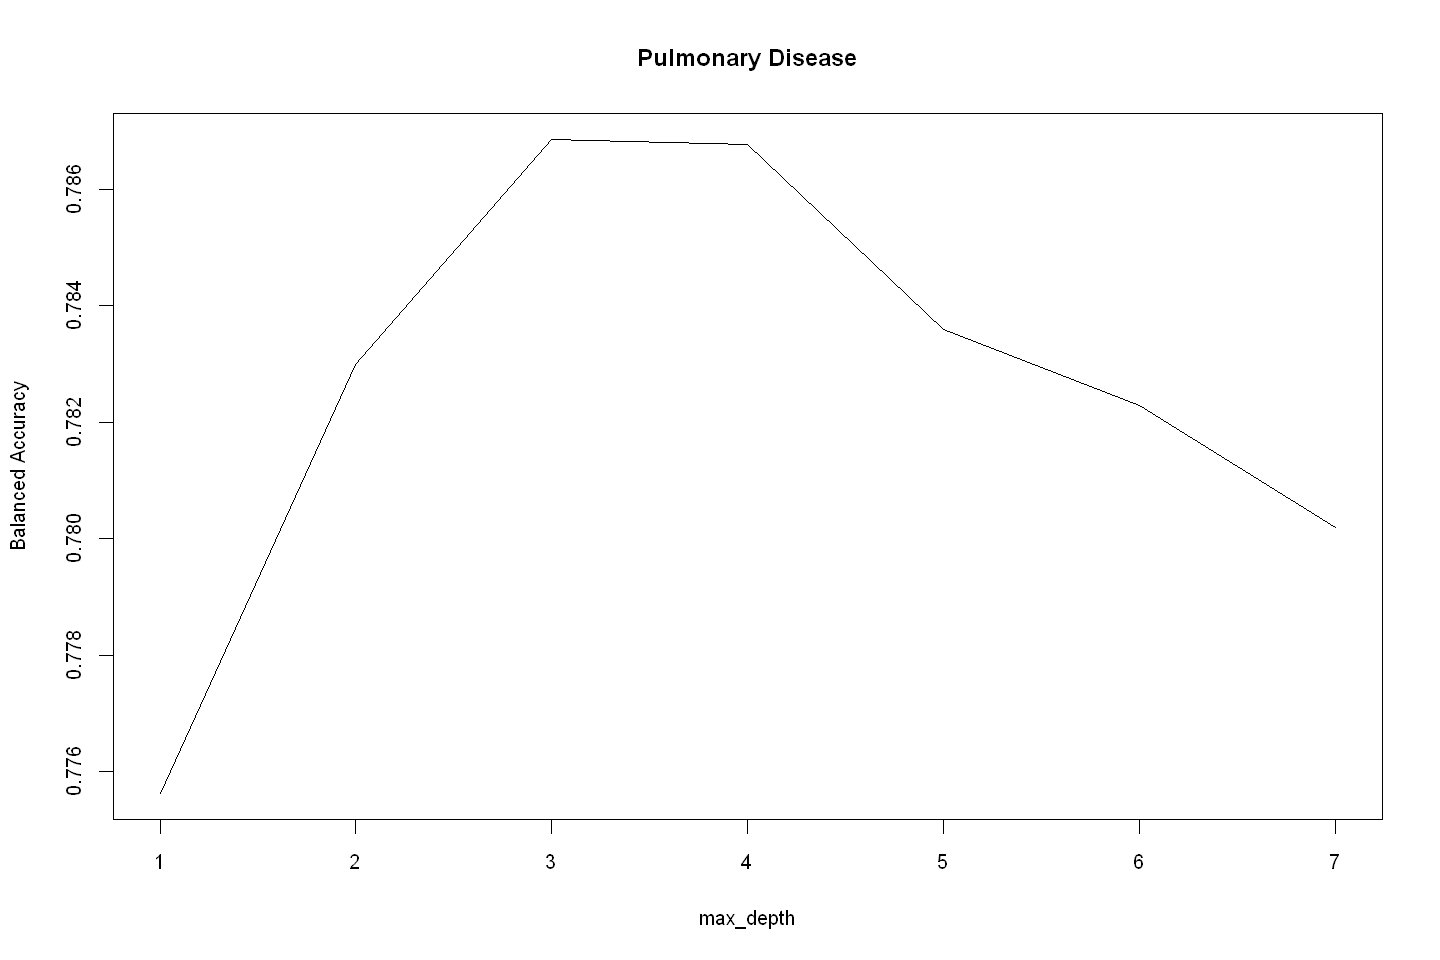

In [16]:
# Check max_depth
accuracy8<-c()
max_depth <- c(1:7)
for (i in 1:7){
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=i, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[i] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(max_depth, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Pulmonary Disease')
# Extract best value for max_depth
print(paste("Best max_depth:",max_depth[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best eta: 0.25"
[1] "New balanced accuracy: 0.789133338665813"


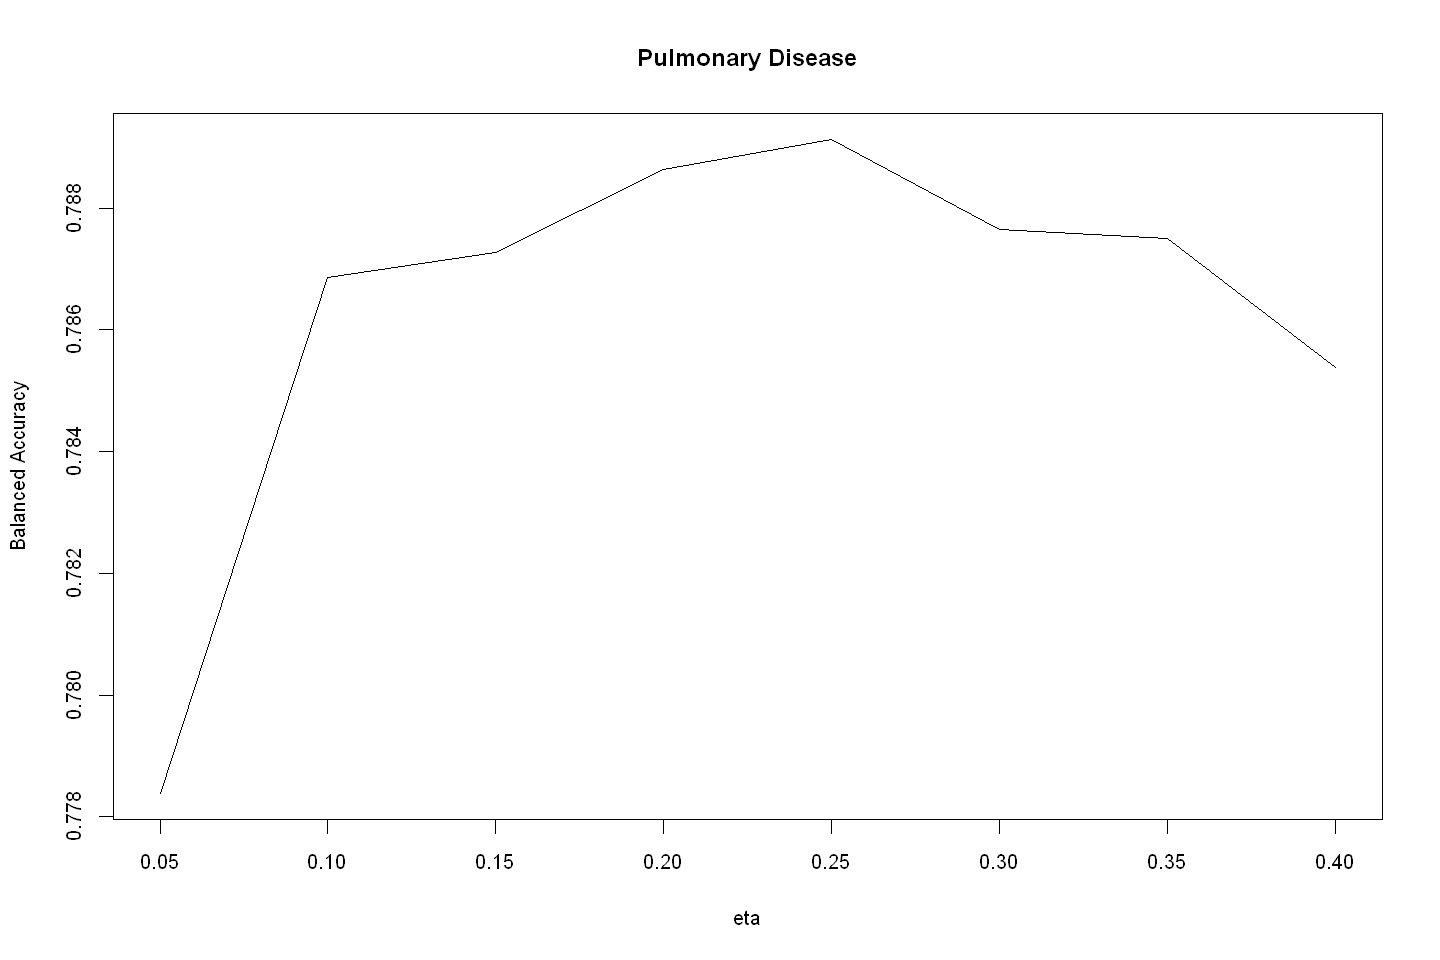

In [17]:
# Check eta
accuracy8<-c()
eta <- seq(0.05, 0.4, by=0.05)
for (i in eta){
index<-match(i,eta)
    #print(index)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=3, eta=i, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(eta, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Pulmonary Disease')
# Extract best value for eta
print(paste("Best eta:",eta[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best nrounds: 24"
[1] "New balanced accuracy: 0.789104814999935"


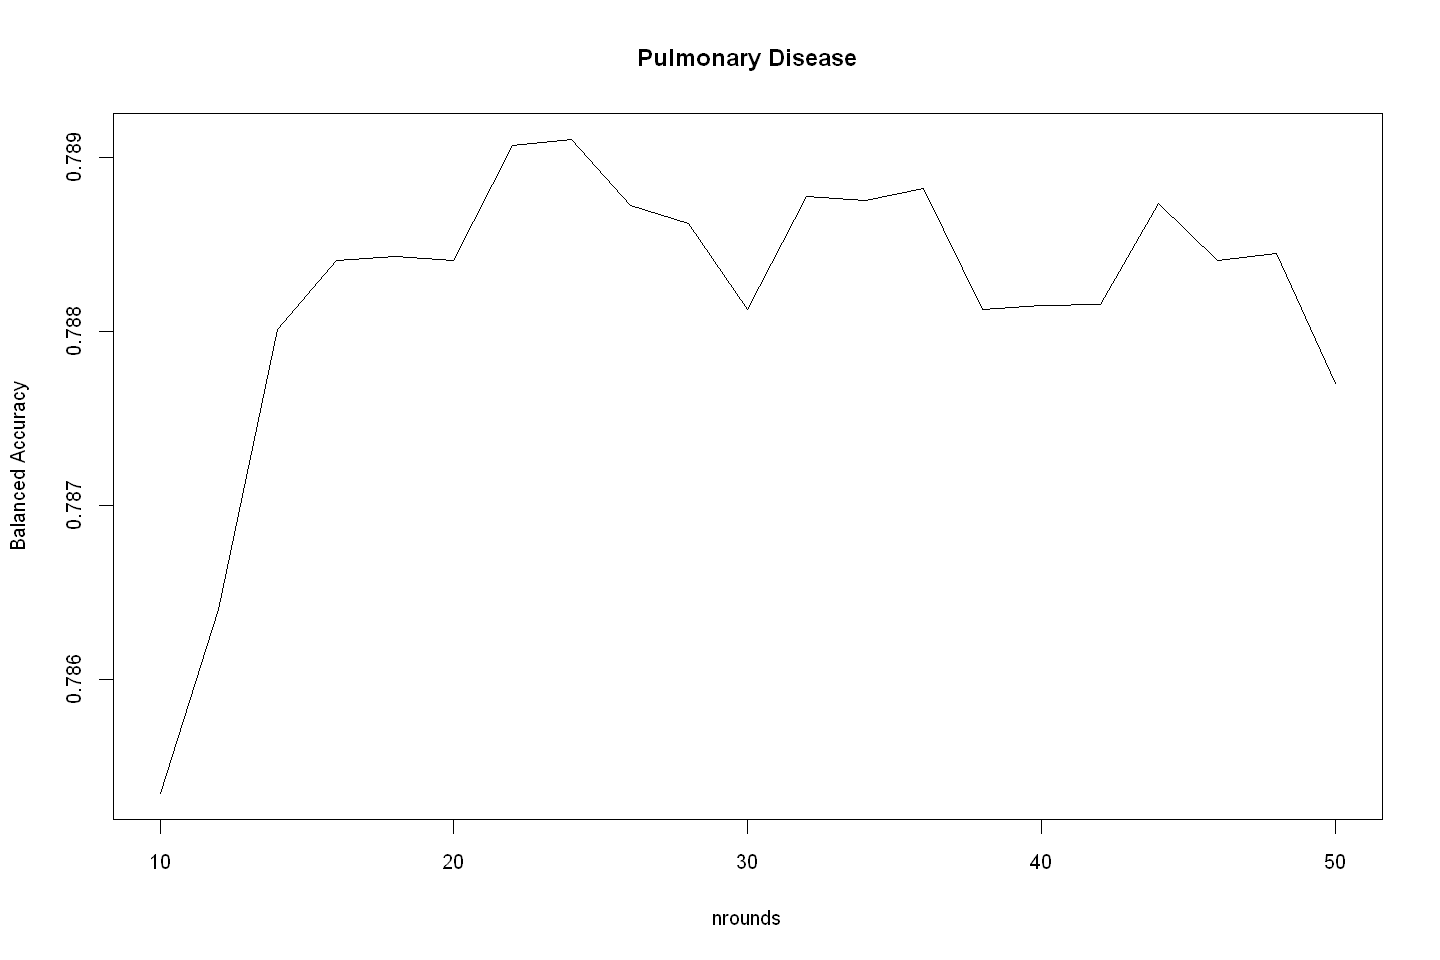

In [18]:
# Check nrounds
accuracy8<-c()
nrounds <- seq(10, 50, by=2)
for (i in nrounds){
index<-match(i,nrounds)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=i, max_depth=3, eta=0.25, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(nrounds, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Pulmonary Disease')
# Extract best value for nrounds
print(paste("Best nrounds:",nrounds[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))
    

$TP
[1] 7526

$FN
[1] 1874

$TN
[1] 87460

$FP
[1] 23728

$NPV
[1] 0.979

$FPR
[1] 0.2134

$TPR
[1] 0.8006

$TNR
[1] 0.7866

$FNR
[1] 0.1994

$threatScore
[1] 0.2272

$balancedacc
[1] 0.7936

$threshold
[1] 0.5

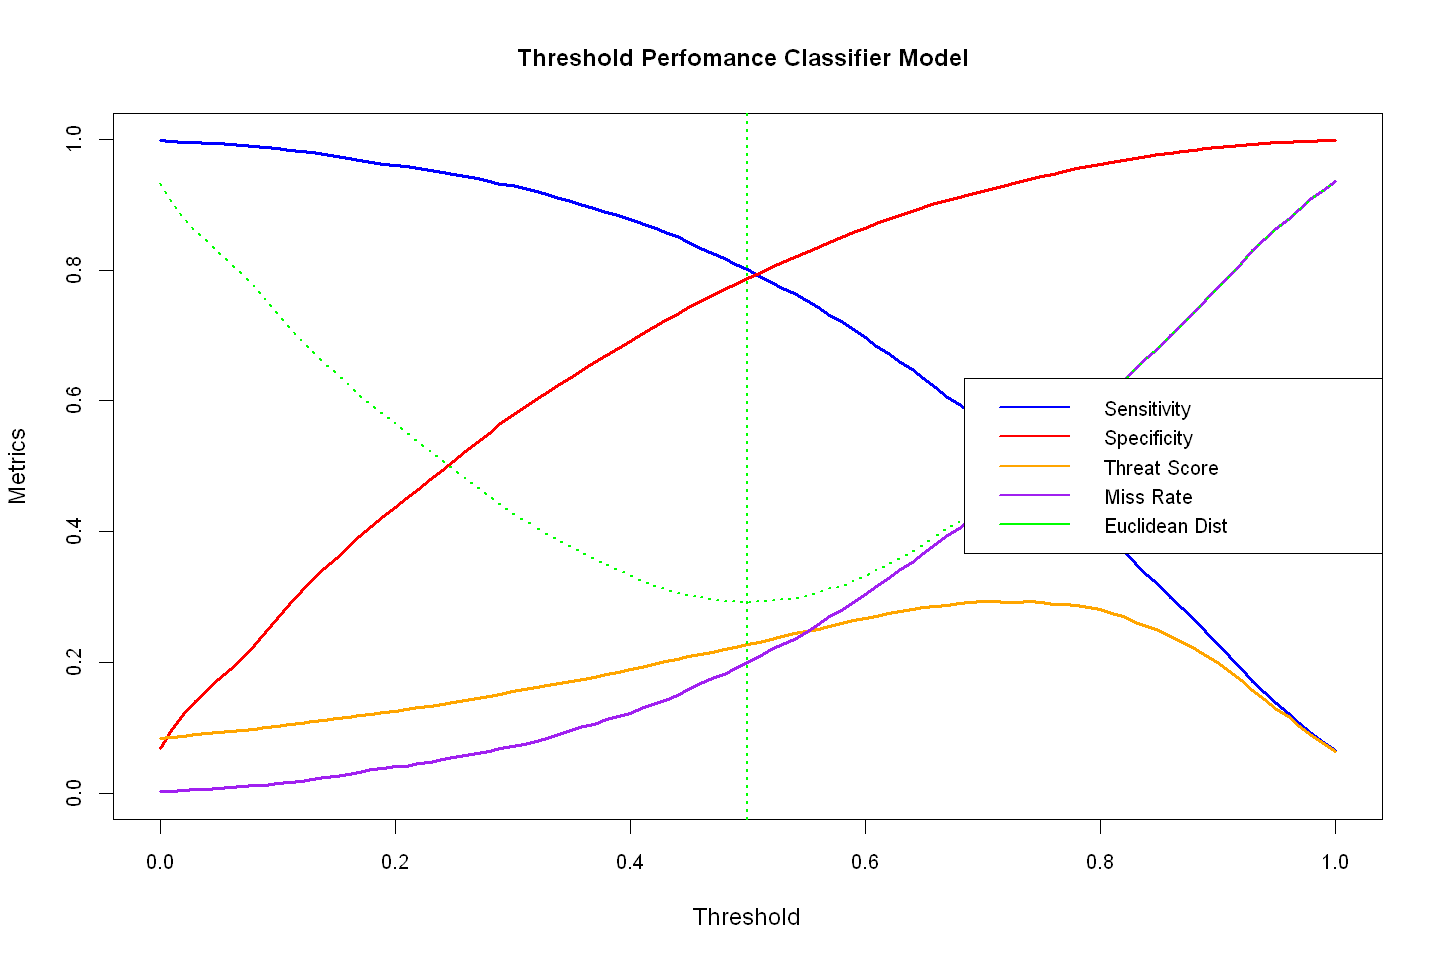

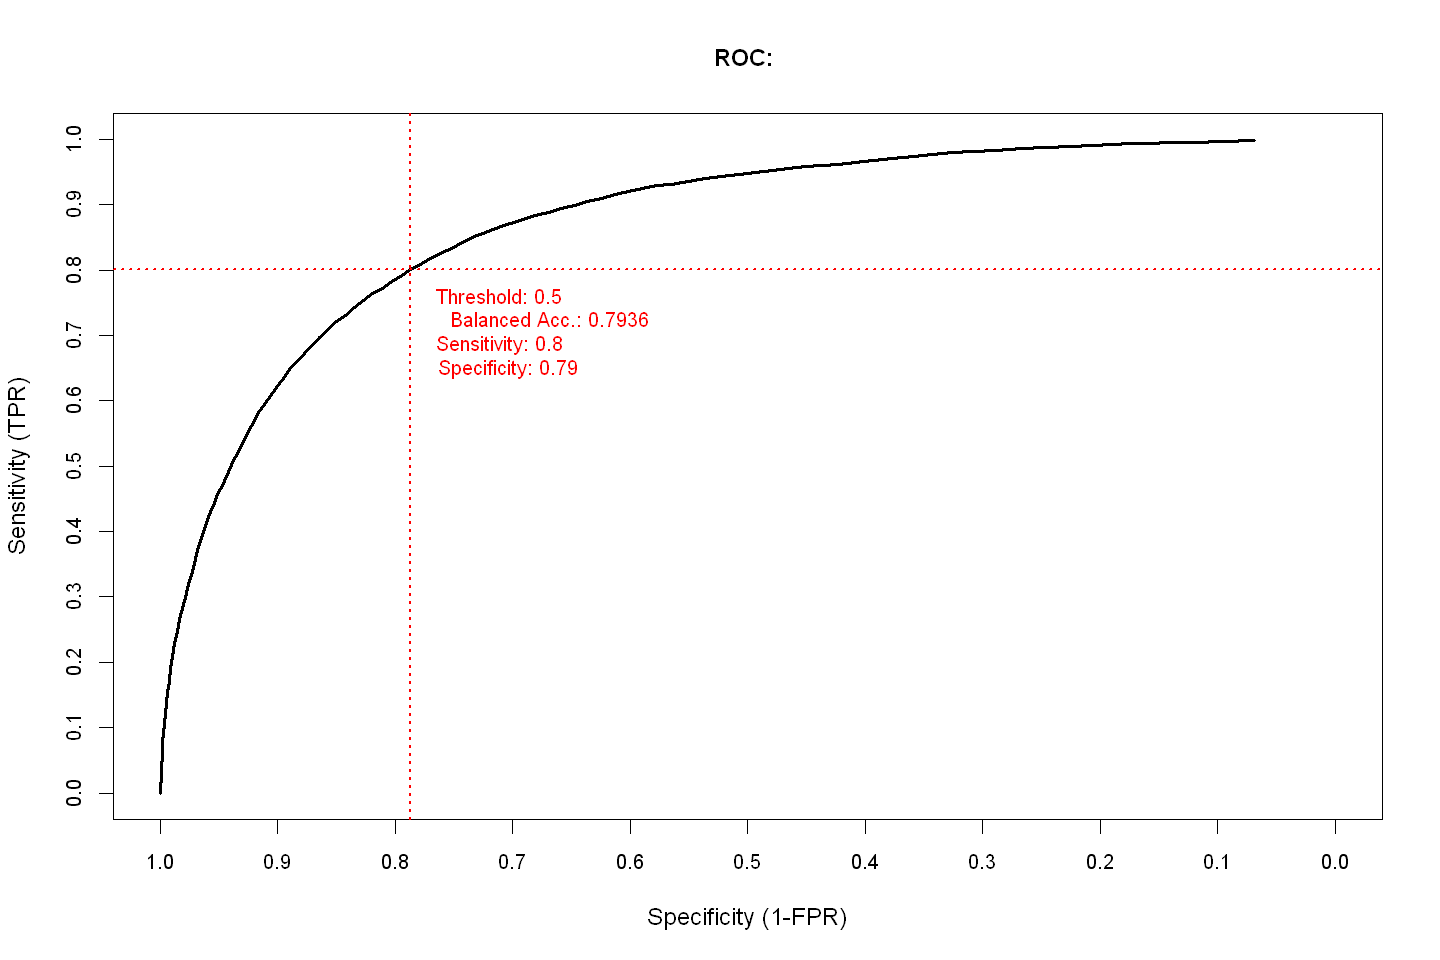

In [19]:
### Final model now trained on complete dataset ###

# PULMONARYDISEASE
data_col_index = 17
train = undersampleLUNG2 # full training dataset
test = test2 # full testing dataset

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with best nrounds, max_depth, eta
xgbc = xgboost(data=xgb_train, nrounds=24, max_depth=3, eta=0.25, verbose=0)

# Fit the model
pred = predict(xgbc,xgb_test)

### Determine best threshold ###

#setting options for this cell for better viewing
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)

#calling function to plot graphs and view values
measures_LUNG<-getTreeClassifications(myTree = xgbc,
                                           test_y,
                                           pred,
                                           title='',
                                           plot=TRUE)

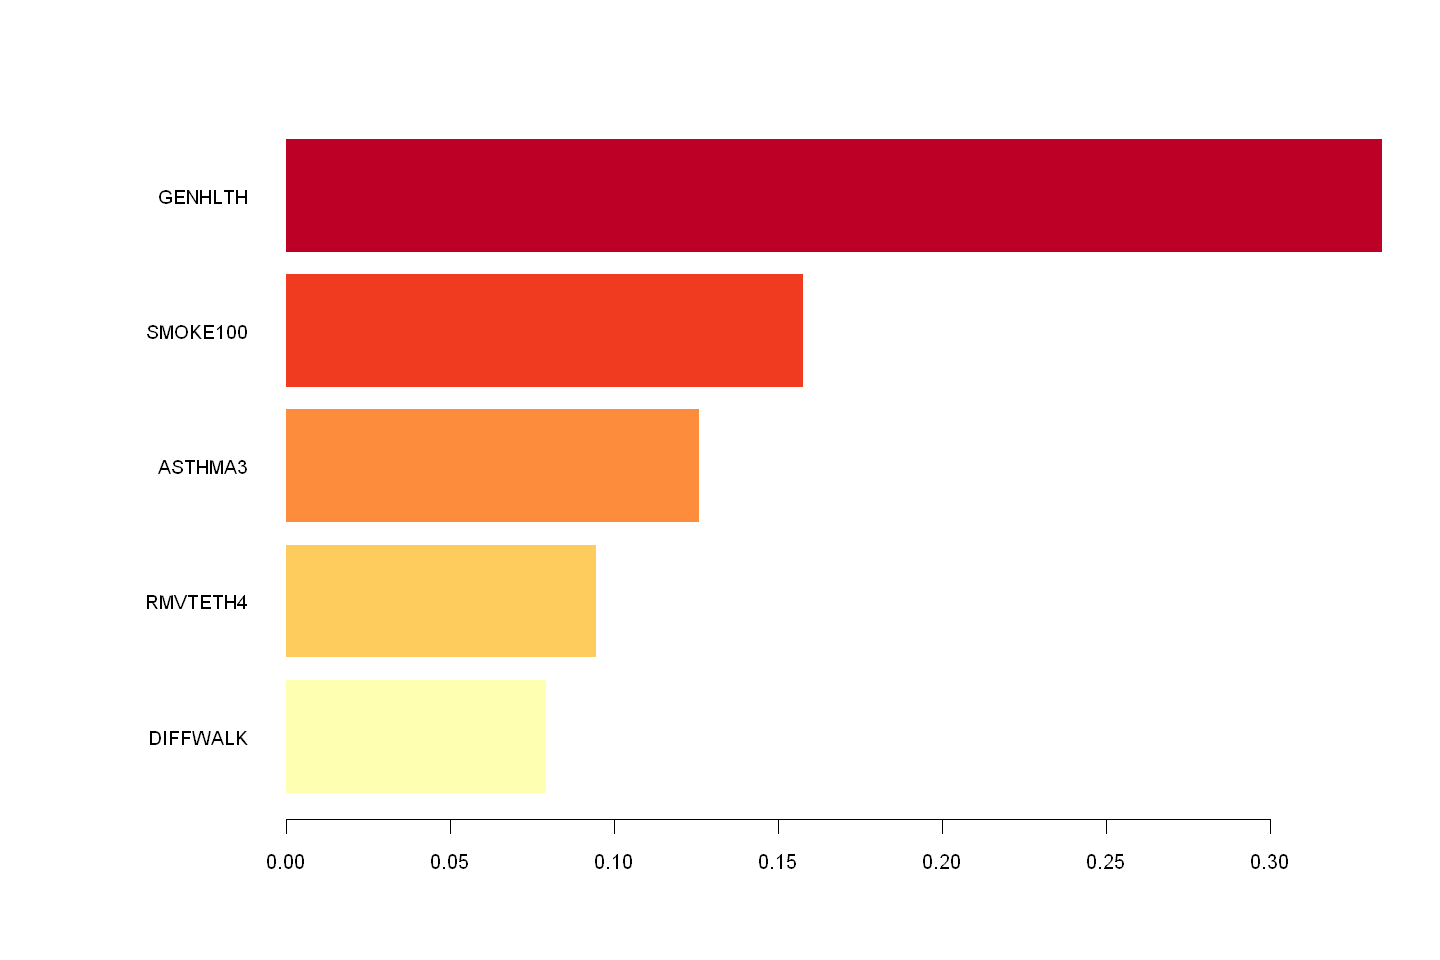

In [20]:
### Feature Importance ###

# Compute feature importance matrix
importance_matrix = xgb.importance(colnames(xgb_train), model = xgbc)

# Plotting importances
xgb.plot.importance(importance_matrix[1:5,], col=p)

## Other Cancers Classifier

In [21]:
#OTHERCANCERS
data_col_index = 16
train = undersampleCANCER

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)

TN <- cm[1]
TP <- cm[4]
FP <- cm[2]
FN <- cm[3]

print(evaluation)
calcMeasures(TP,FN,FP,TN)

Confusion Matrix and Statistics

    obs
pred     0     1
   0 71097  2948
   1 38505  8038
                                          
               Accuracy : 0.6562          
                 95% CI : (0.6536, 0.6589)
    No Information Rate : 0.9089          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1549          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6487          
            Specificity : 0.7317          
         Pos Pred Value : 0.9602          
         Neg Pred Value : 0.1727          
             Prevalence : 0.9089          
         Detection Rate : 0.5896          
   Detection Prevalence : 0.6140          
      Balanced Accuracy : 0.6902          
                                          
       'Positive' Class : 0               
                                          


Warning message in (TP + FP) * (TP + FN) * (TN + FP):
"NAs produced by integer overflow"


$TP
[1] 8038

$FN
[1] 2948

$TN
[1] 71097

$FP
[1] 38505

$accuracy
[1] 65.62

$precision
[1] 17.27

$NPV
[1] 96.02

$FPR
[1] 35.13

$TPR
[1] 73.17

$TNR
[1] 64.87

$MCC
[1] NA

$FNR
[1] 26.83

$F1
[1] 27.94

$ThreatScore
[1] 16.24

[1] "Best max_depth: 4"
[1] "New balanced accuracy: 0.705155145476412"


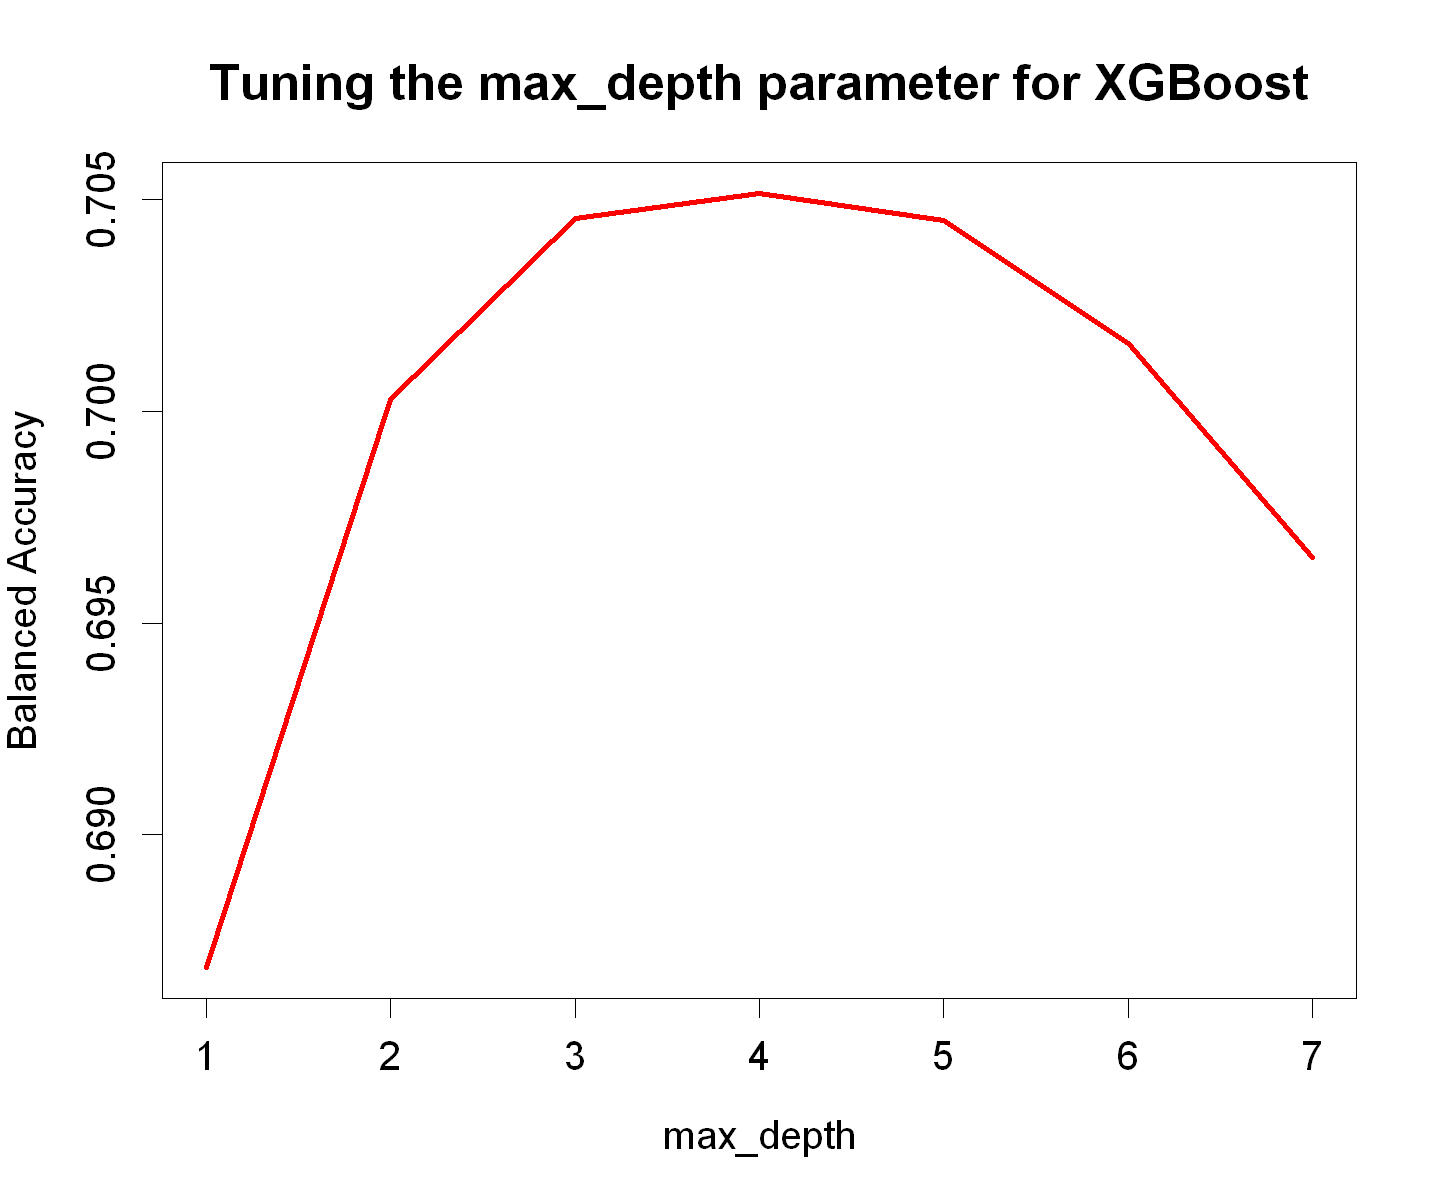

In [22]:
options(repr.plot.width=12, repr.plot.height=10, repr.plot.pointsize=20)
# Check max_depth
accuracy8<-c()
max_depth <- c(1:7)
for (i in 1:7){
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=i, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[i] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(max_depth, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Tuning the max_depth parameter for XGBoost', cex.main=2.5, cex.lab=2, cex.axis=2, col = "red", lwd=4)
# Extract best value for max_depth
print(paste("Best max_depth:",max_depth[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best eta: 0.15"
[1] "New balanced accuracy: 0.705888166080997"


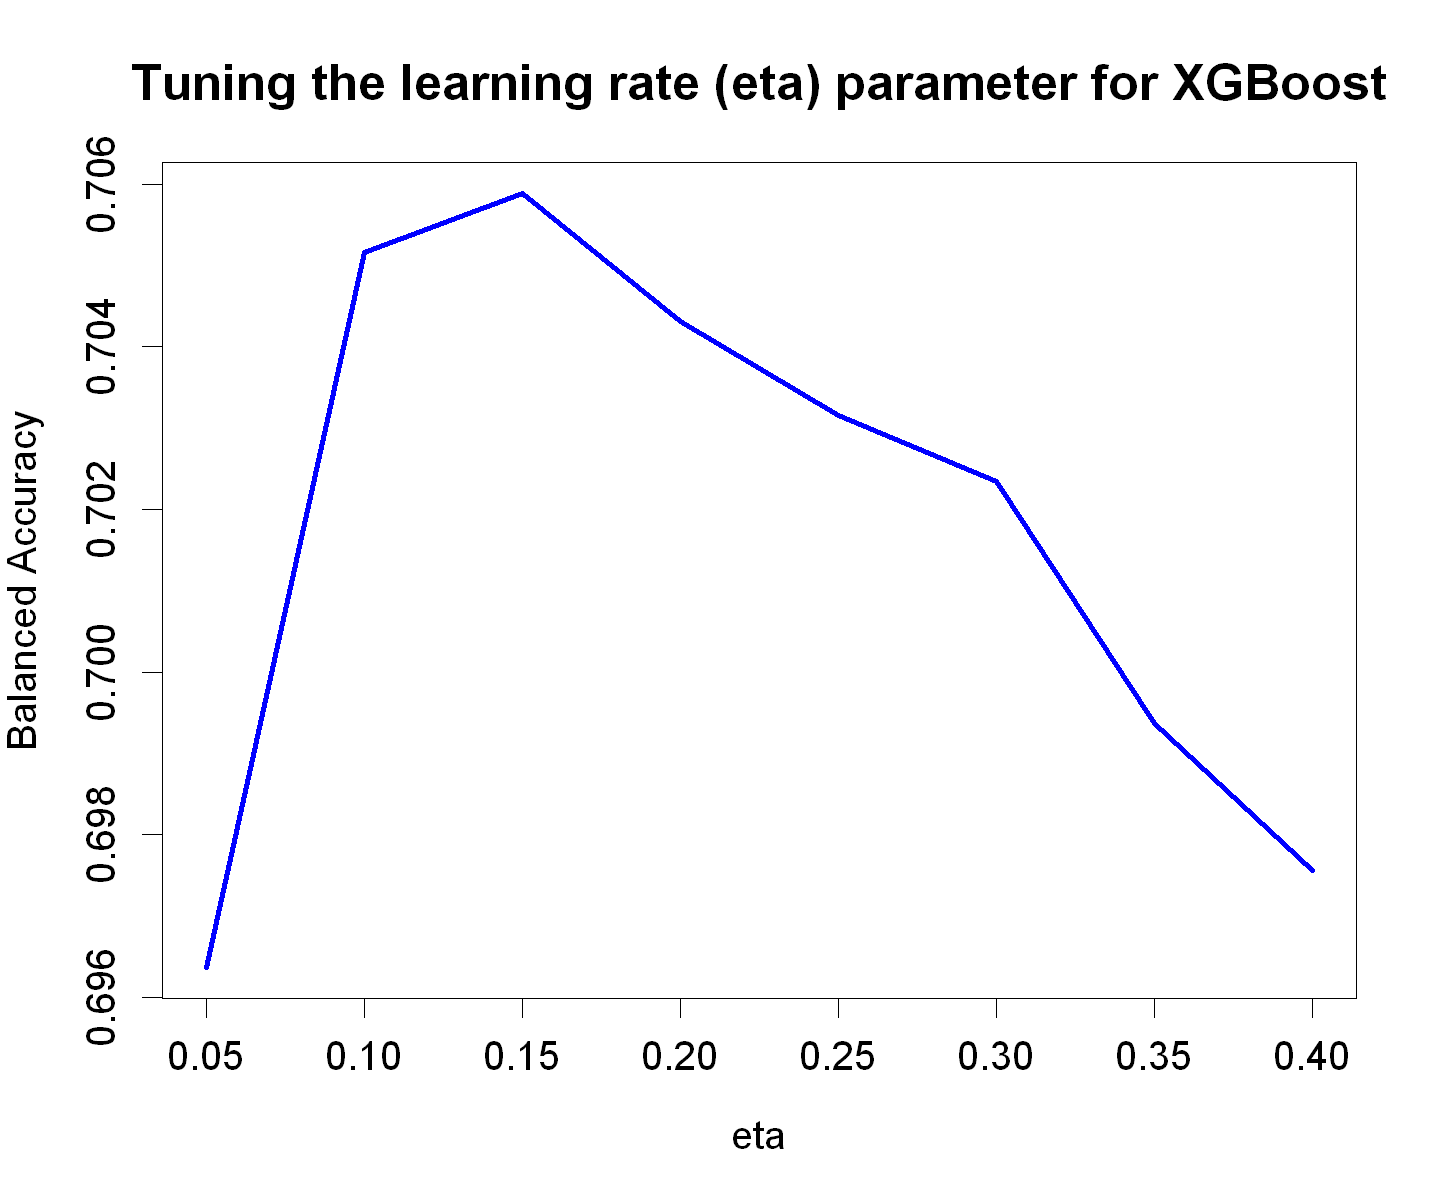

In [23]:
# Check eta
accuracy8<-c()
eta <- seq(0.05, 0.4, by=0.05)
for (i in eta){
index<-match(i,eta)
    #print(index)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=4, eta=i, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(eta, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Tuning the learning rate (eta) parameter for XGBoost', cex.main=2.5, cex.lab=2, cex.axis=2, col = "blue", lwd=4)
# Extract best value for eta
print(paste("Best eta:",eta[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best nrounds: 28"
[1] "New balanced accuracy: 0.706572138758027"


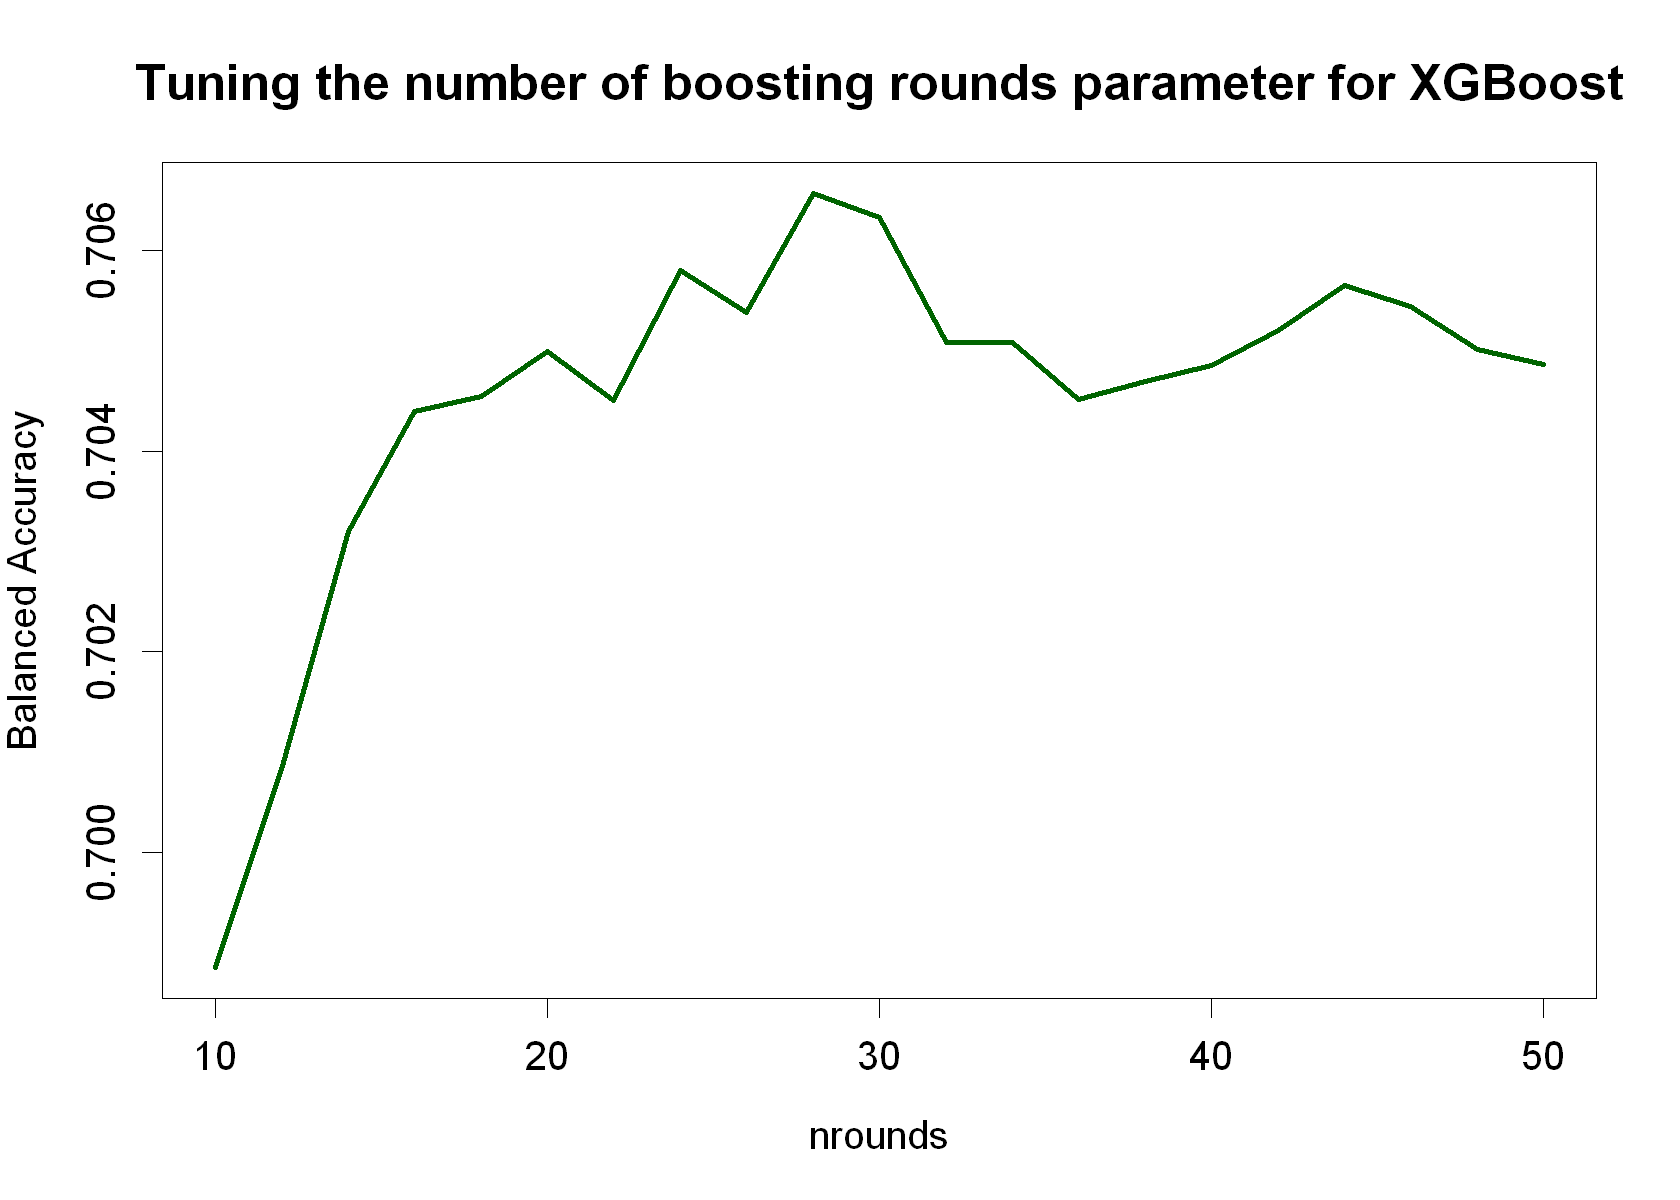

In [24]:
# Check nrounds
accuracy8<-c()
nrounds <- seq(10, 50, by=2)
for (i in nrounds){
index<-match(i,nrounds)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=i, max_depth=4, eta=0.15, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

options(repr.plot.width=14, repr.plot.pointsize=20)
plot(nrounds, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Tuning the number of boosting rounds parameter for XGBoost', cex.main=2.5, cex.lab=2, cex.axis=2, col = "darkgreen", lwd=4)
# Extract best value for nrounds
print(paste("Best nrounds:",nrounds[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))
    

$TP
[1] 8298

$FN
[1] 2688

$TN
[1] 73479

$FP
[1] 36123

$NPV
[1] 0.9647

$FPR
[1] 0.3296

$TPR
[1] 0.7553

$TNR
[1] 0.6704

$FNR
[1] 0.2447

$threatScore
[1] 0.1761

$balancedacc
[1] 0.7128

$threshold
[1] 0.53

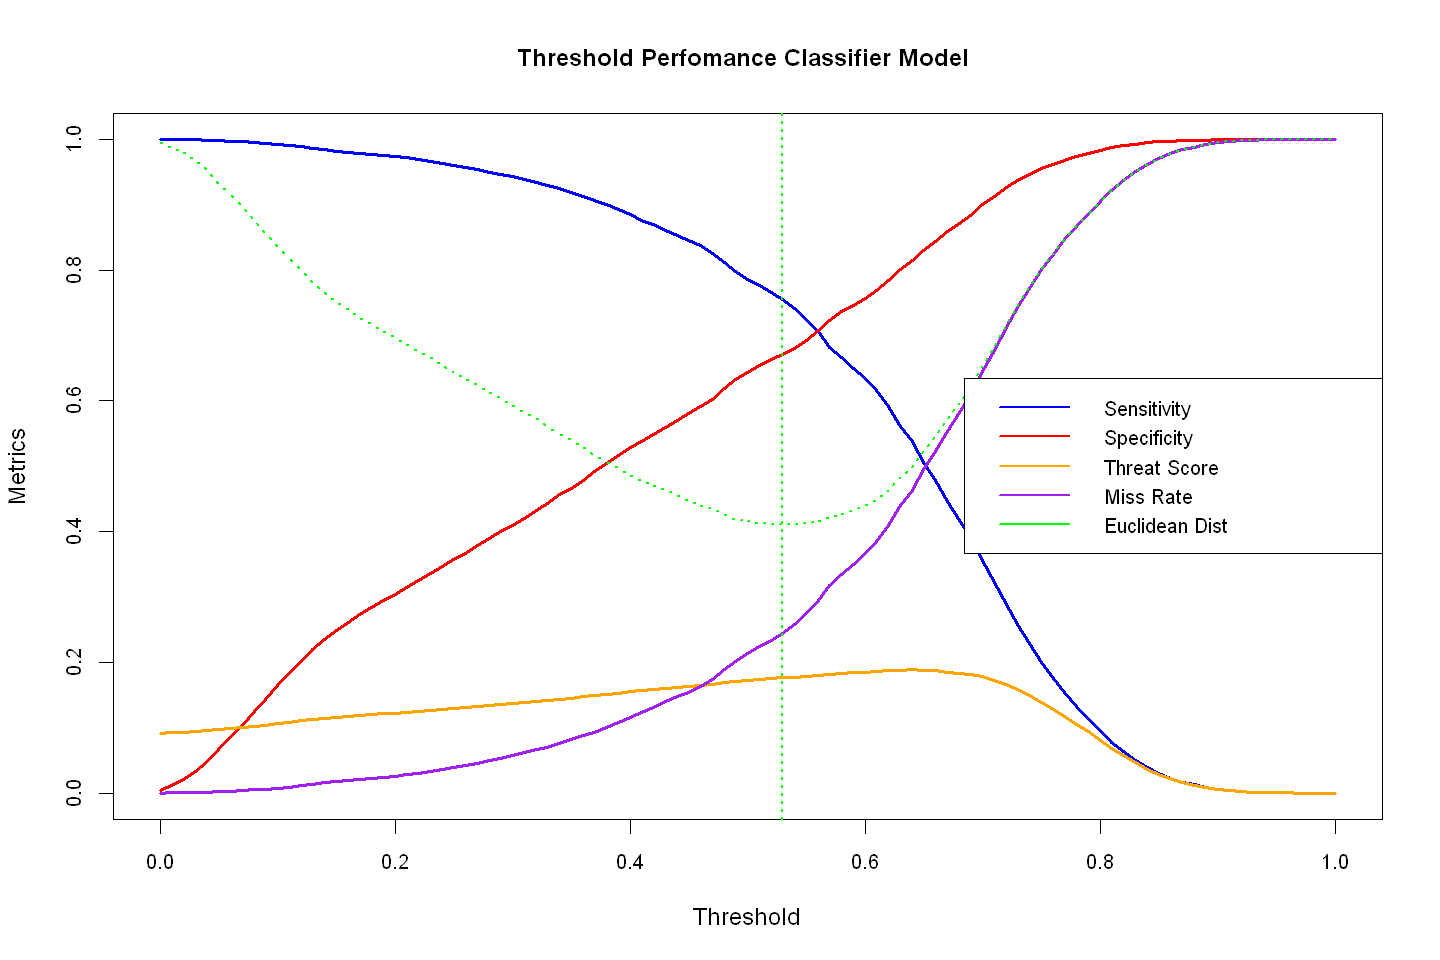

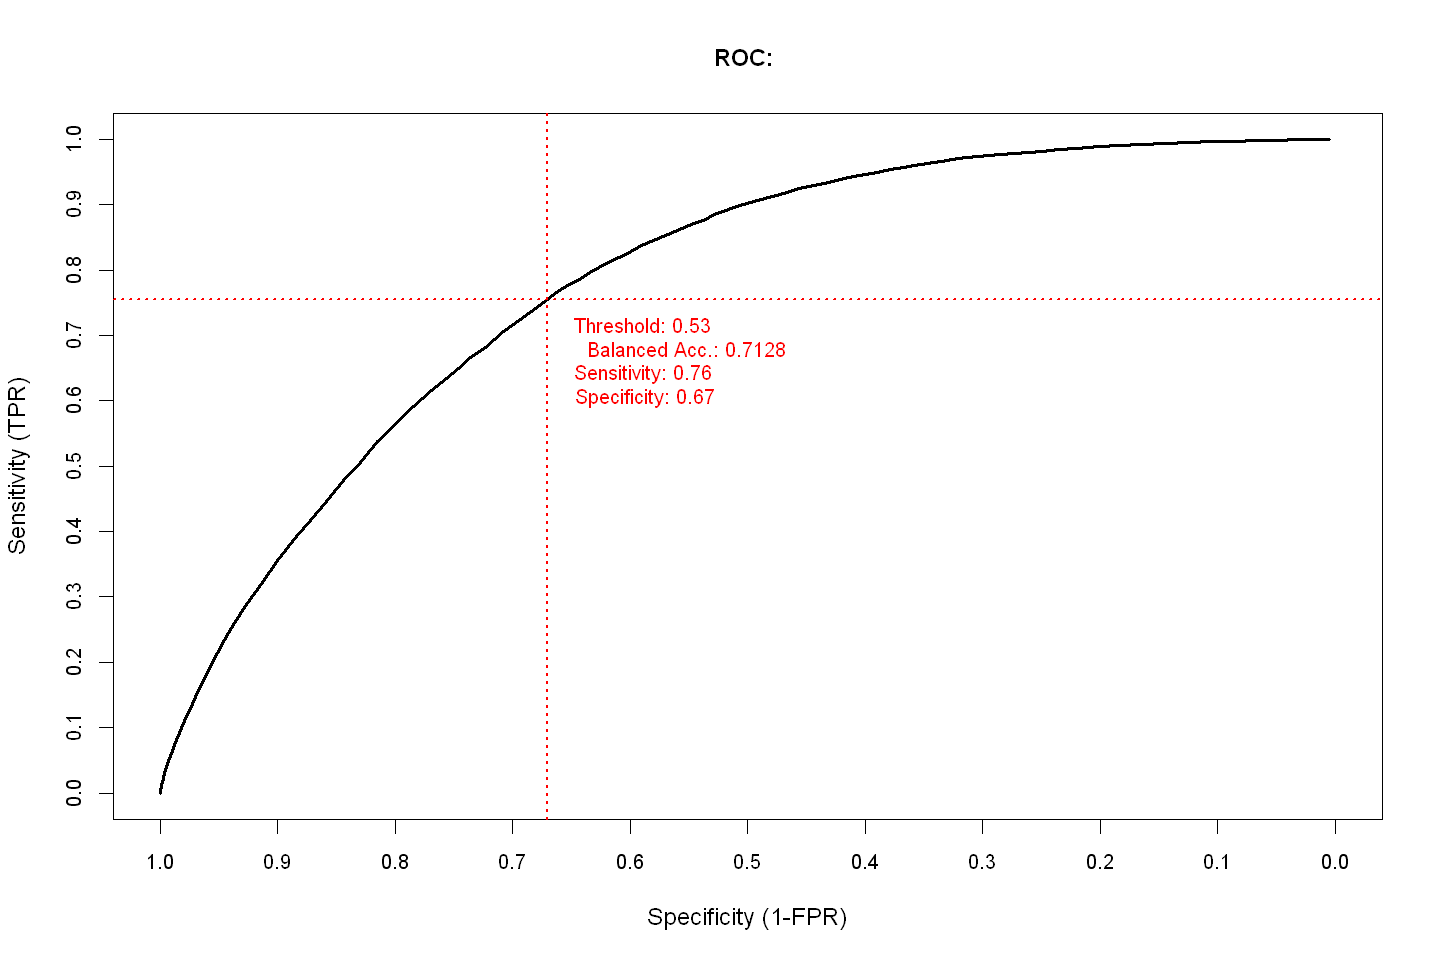

In [25]:
### Final model now trained on complete dataset ###

# OTHERCANCERS
data_col_index = 16
train = undersampleCANCER2 # full training dataset
test = test2 # full testing dataset

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with best nrounds, max_depth, eta
xgbc = xgboost(data=xgb_train, nrounds=28, max_depth=4, eta=0.15, verbose=0)

# Fit the model
pred = predict(xgbc,xgb_test)

### Determine best threshold ###

#setting options for this cell for better viewing
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)

#calling function to plot graphs and view values
measures_CANCER<-getTreeClassifications(myTree = xgbc,
                                           test_y,
                                           pred,
                                           title='',
                                           plot=TRUE)

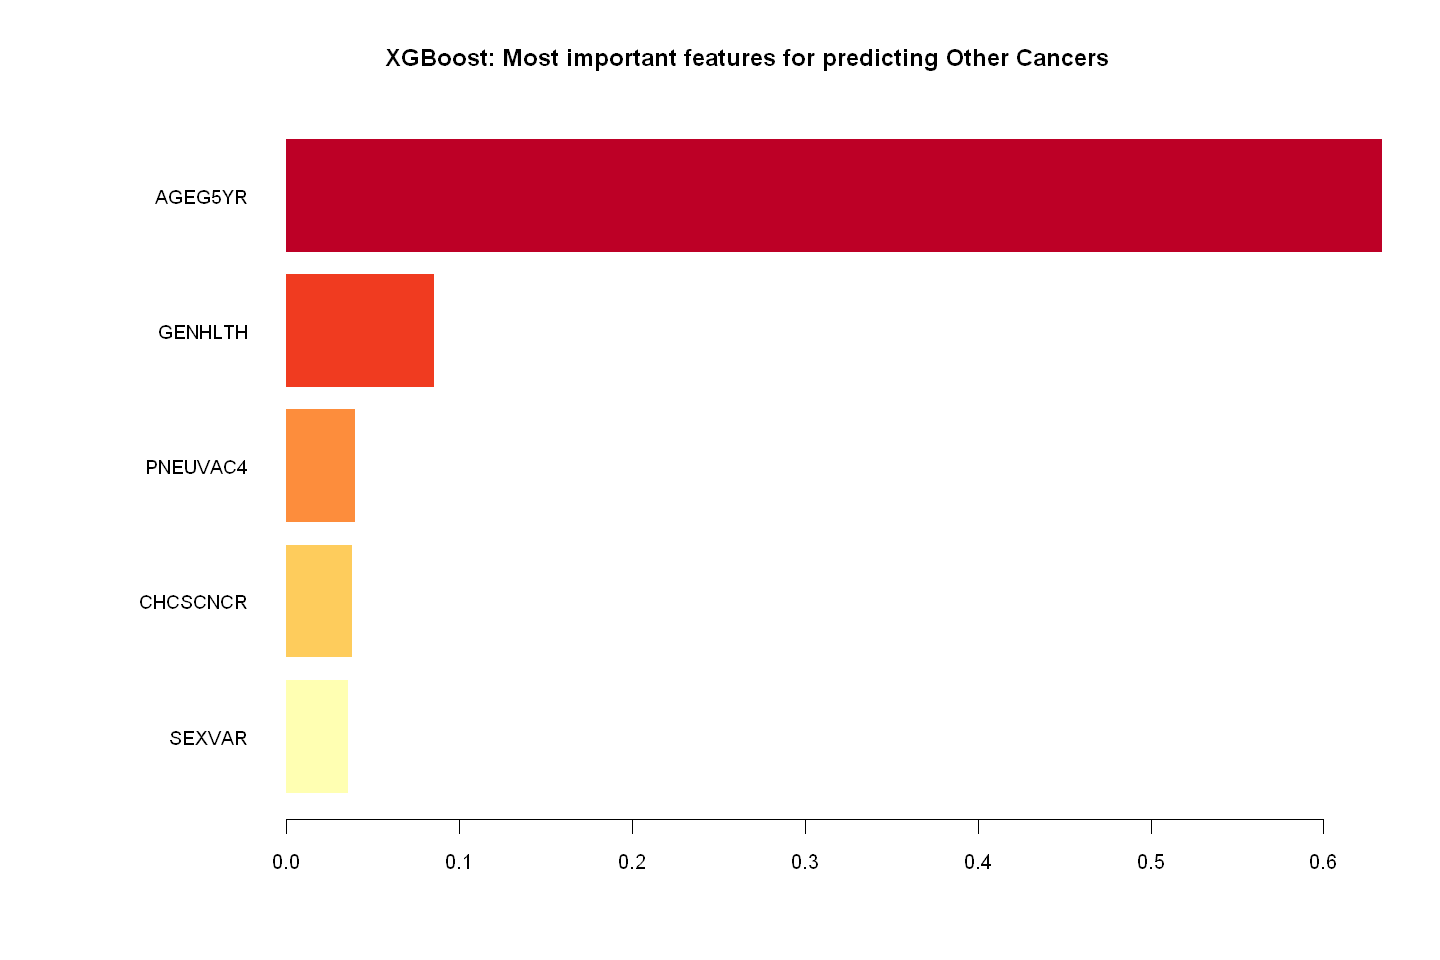

In [26]:
### Feature Importance ###

# Compute feature importance matrix
importance_matrix = xgb.importance(colnames(xgb_train), model = xgbc)

# Plotting importances
xgb.plot.importance(importance_matrix[1:5,], col=p)
title("XGBoost: Most important features for predicting Other Cancers")

## Arthritis Classifier

In [27]:
#ARTHRITIS
data_col_index = 18
train = undersampleARTH

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)

TN <- cm[1]
TP <- cm[4]
FP <- cm[2]
FN <- cm[3]

print(evaluation)
calcMeasures(TP,FN,FP,TN)

Confusion Matrix and Statistics

    obs
pred     0     1
   0 58722  8674
   1 24701 28491
                                          
               Accuracy : 0.7232          
                 95% CI : (0.7207, 0.7258)
    No Information Rate : 0.6918          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4203          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7039          
            Specificity : 0.7666          
         Pos Pred Value : 0.8713          
         Neg Pred Value : 0.5356          
             Prevalence : 0.6918          
         Detection Rate : 0.4870          
   Detection Prevalence : 0.5589          
      Balanced Accuracy : 0.7353          
                                          
       'Positive' Class : 0               
                                          


Warning message in (TP + FP) * (TP + FN) * (TN + FP):
"NAs produced by integer overflow"


$TP
[1] 28491

$FN
[1] 8674

$TN
[1] 58722

$FP
[1] 24701

$accuracy
[1] 72.32

$precision
[1] 53.56

$NPV
[1] 87.13

$FPR
[1] 29.61

$TPR
[1] 76.66

$TNR
[1] 70.39

$MCC
[1] NA

$FNR
[1] 23.34

$F1
[1] 63.06

$ThreatScore
[1] 46.05

[1] "Best max_depth: 5"
[1] "New balanced accuracy: 0.736525395297827"


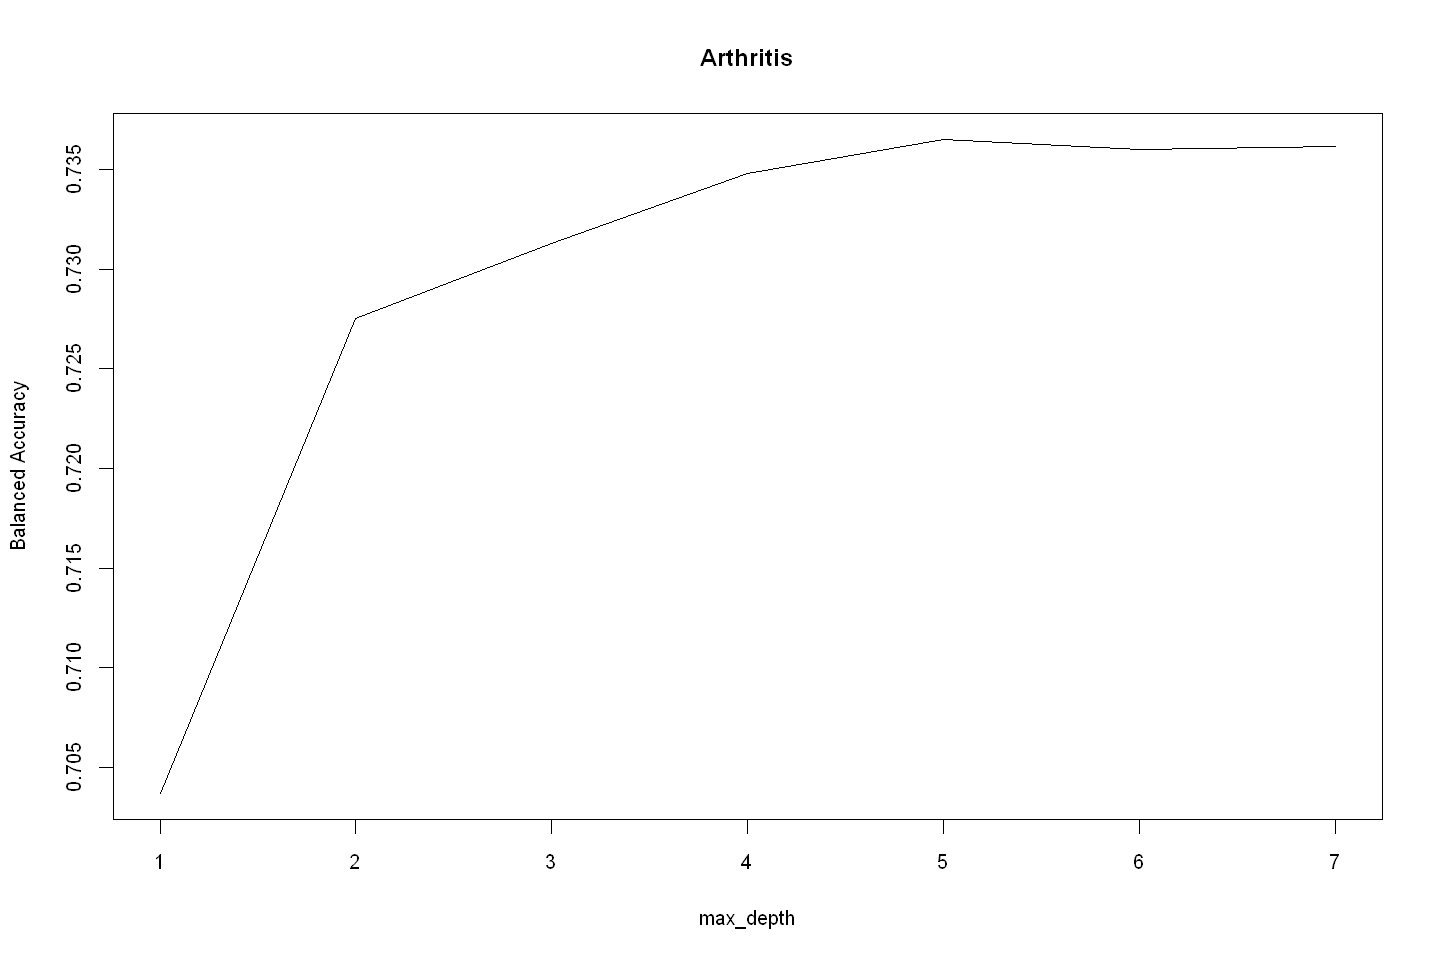

In [28]:
# Check max_depth
accuracy8<-c()
max_depth <- c(1:7)
for (i in 1:7){
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=i, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[i] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(max_depth, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Arthritis')
# Extract best value for max_depth
print(paste("Best max_depth:",max_depth[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best eta: 0.2"
[1] "New balanced accuracy: 0.738778731773298"


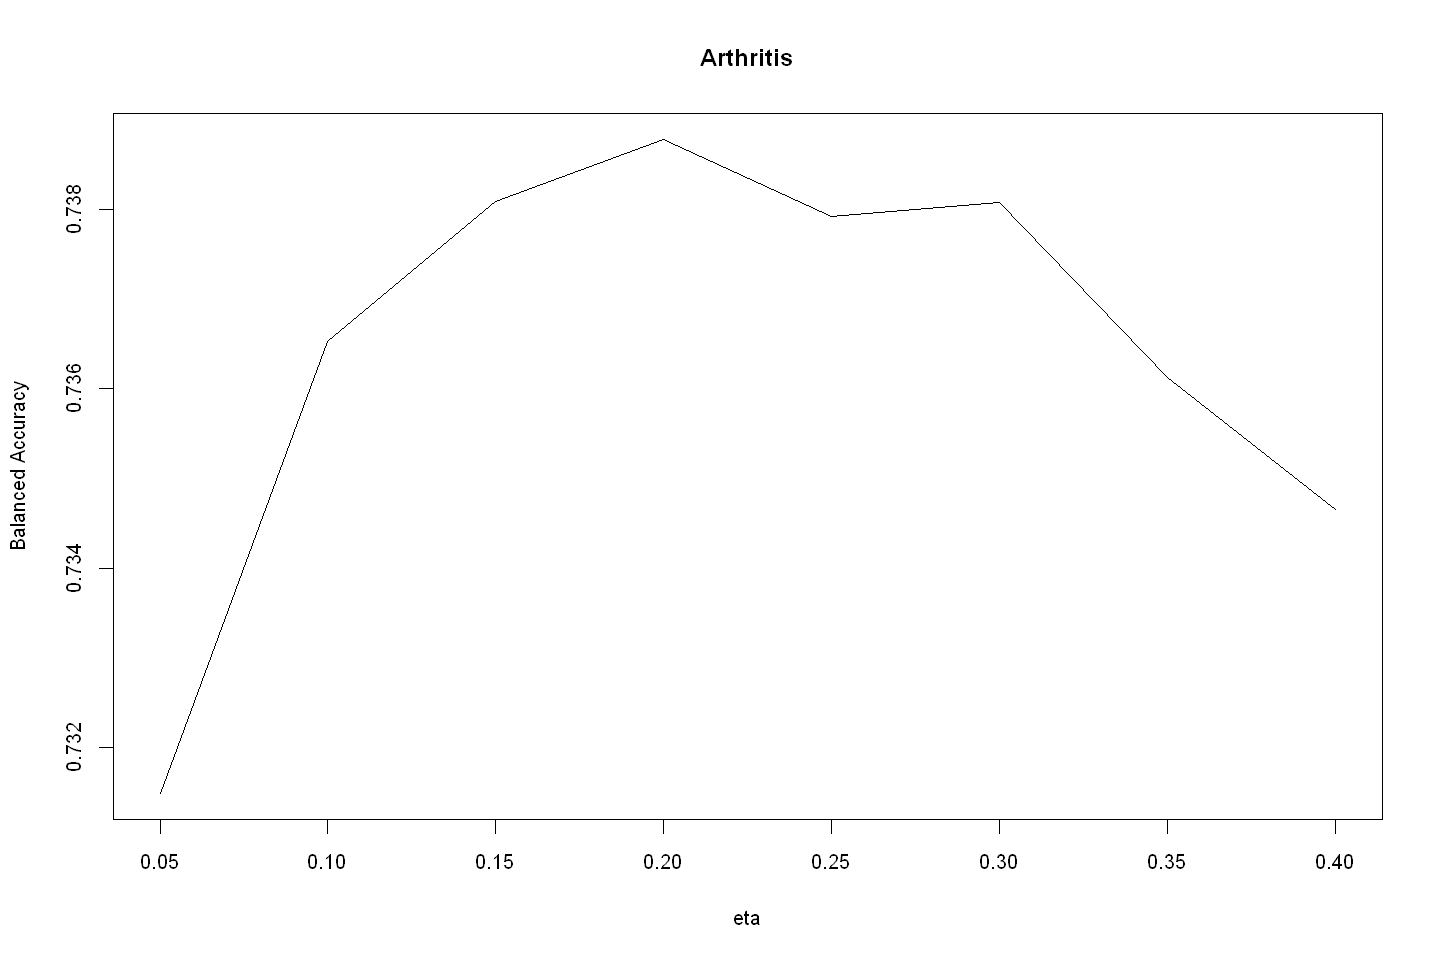

In [29]:
# Check eta
accuracy8<-c()
eta <- seq(0.05, 0.4, by=0.05)
for (i in eta){
index<-match(i,eta)
    #print(index)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=5, eta=i, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(eta, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Arthritis')
# Extract best value for eta
print(paste("Best eta:",eta[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best nrounds: 34"
[1] "New balanced accuracy: 0.739485271684342"


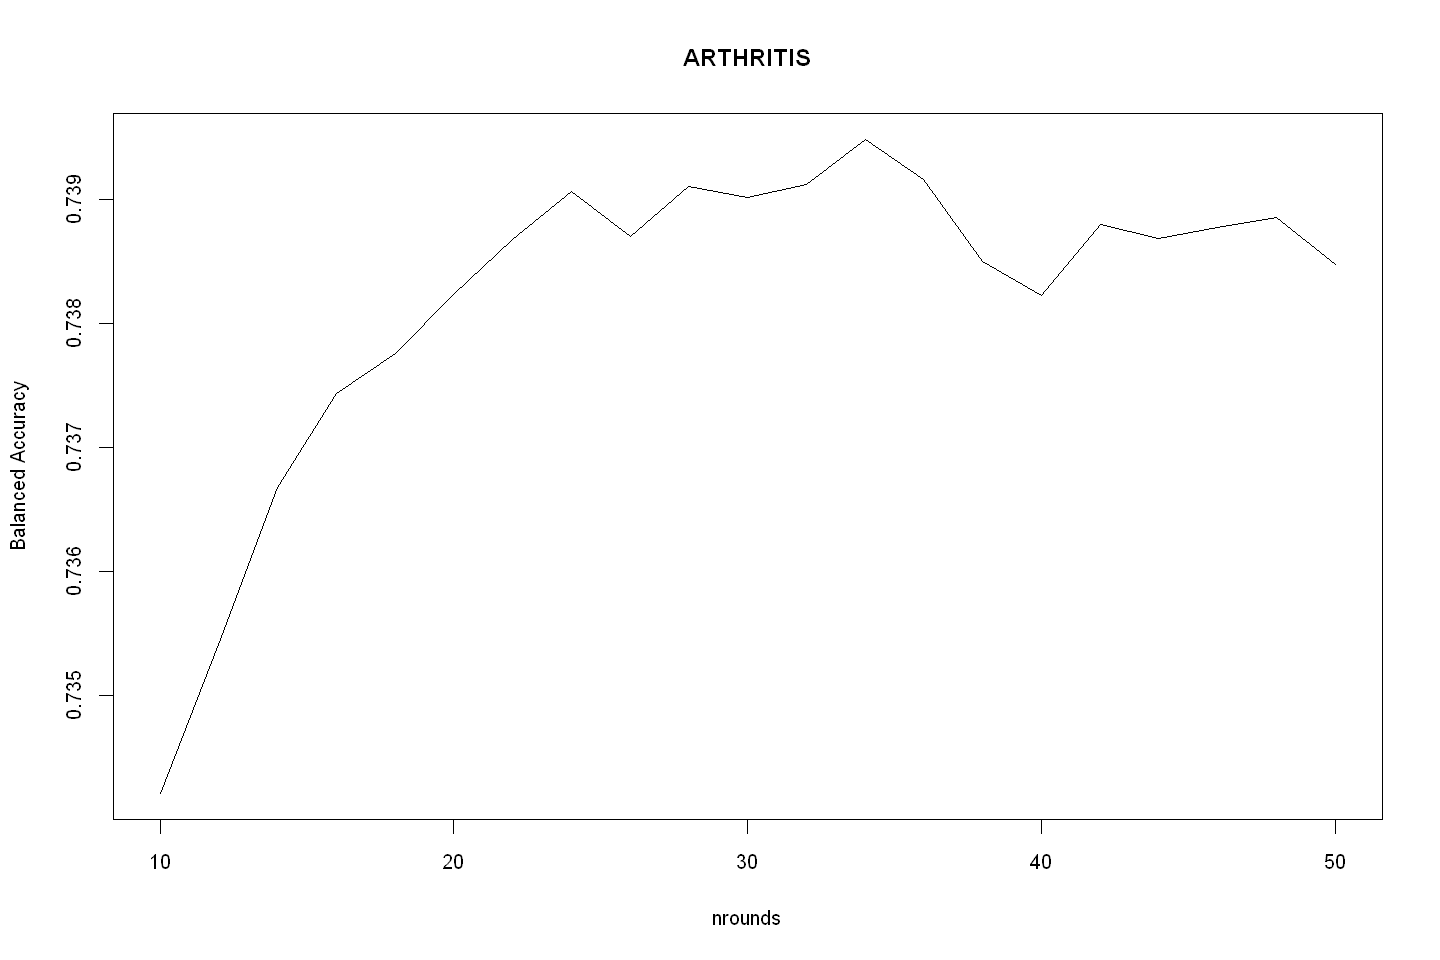

In [30]:
# Check nrounds
accuracy8<-c()
nrounds <- seq(10, 50, by=2)
for (i in nrounds){
index<-match(i,nrounds)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=i, max_depth=5, eta=0.2, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(nrounds, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'ARTHRITIS')
# Extract best value for nrounds
print(paste("Best nrounds:",nrounds[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))
    

$TP
[1] 28068

$FN
[1] 9097

$TN
[1] 60875

$FP
[1] 22548

$NPV
[1] 0.87

$FPR
[1] 0.2703

$TPR
[1] 0.7552

$TNR
[1] 0.7297

$FNR
[1] 0.2448

$threatScore
[1] 0.47

$balancedacc
[1] 0.7425

$threshold
[1] 0.52

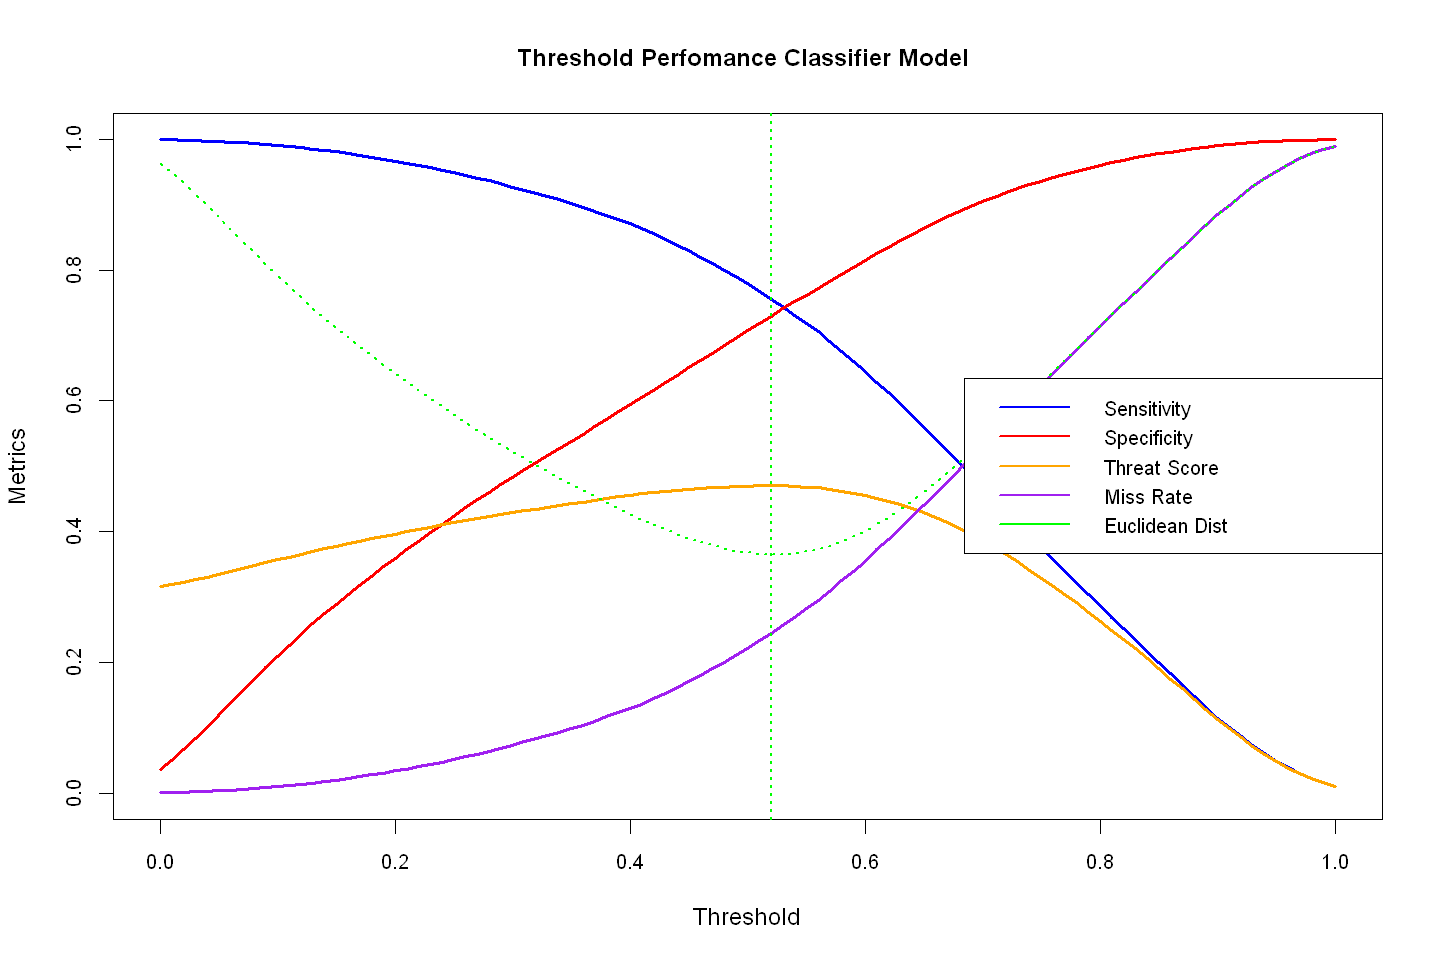

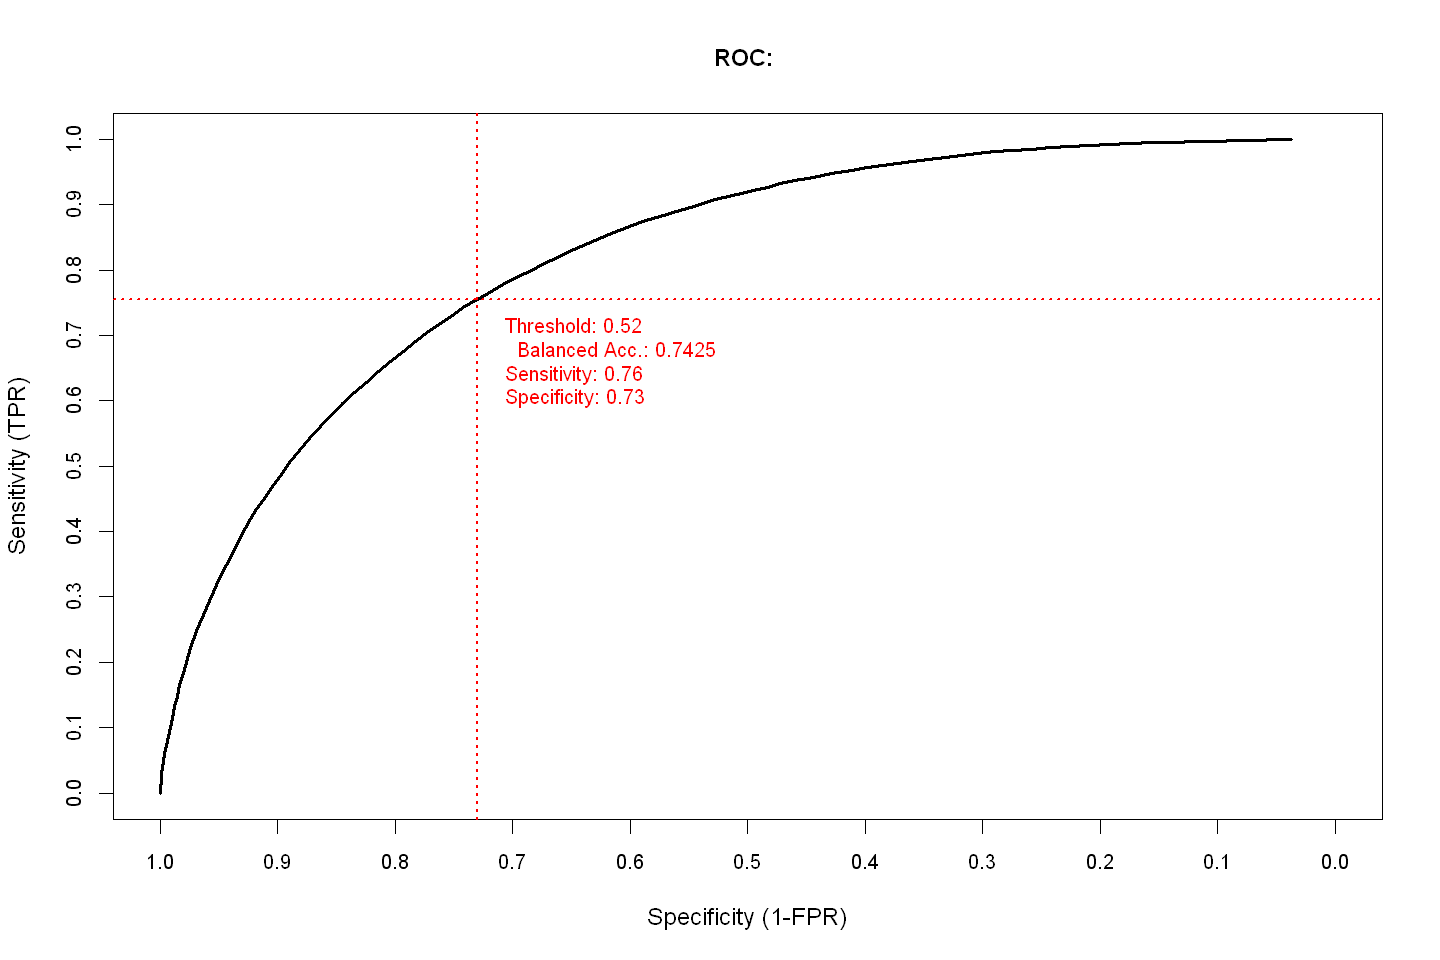

In [31]:
### Final model now trained on complete dataset ###

# ARTHRITIS
data_col_index = 18
train = undersampleARTH2 # full training dataset
test = test2 # full testing dataset

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with best nrounds, max_depth, eta
xgbc = xgboost(data=xgb_train, nrounds=34, max_depth=5, eta=0.2, verbose=0)

# Fit the model
pred = predict(xgbc,xgb_test)

### Determine best threshold ###

#setting options for this cell for better viewing
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)

#calling function to plot graphs and view values
measures_ARTH<-getTreeClassifications(myTree = xgbc,
                                           test_y,
                                           pred,
                                           title='',
                                           plot=TRUE)

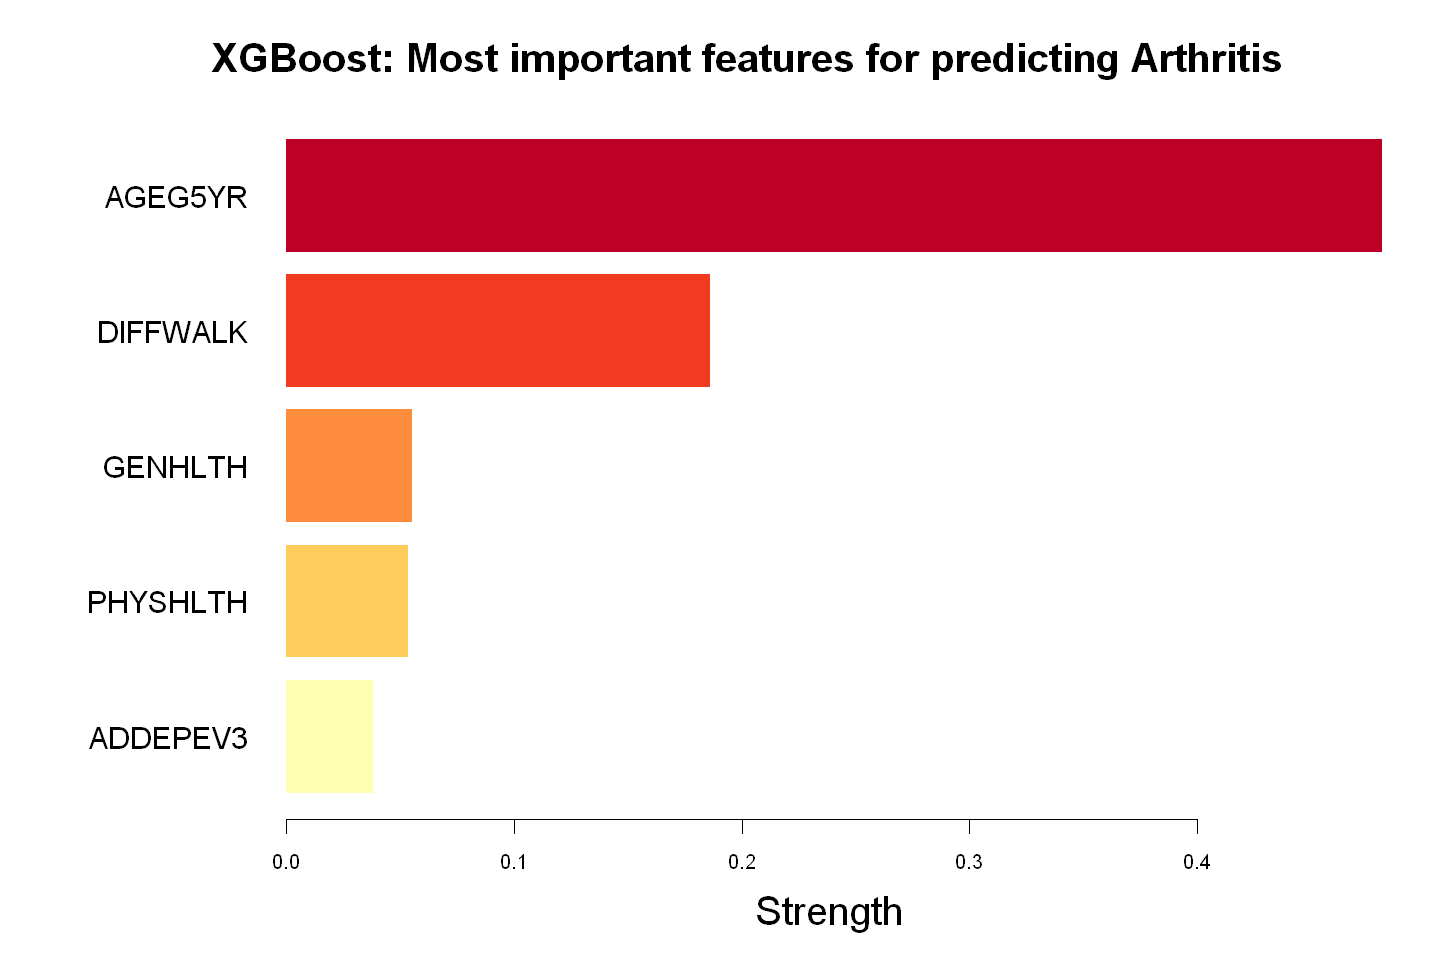

In [32]:
### Feature Importance ###

# Compute feature importance matrix
importance_matrix = xgb.importance(colnames(xgb_train), model = xgbc)

# Plotting importances
xgb.plot.importance(importance_matrix[1:5,], col=p, cex=1.5, xlab="Strength", cex.lab=2)
title("XGBoost: Most important features for predicting Arthritis", cex.main=2)

## Kidney Disease Classifier

In [33]:
#KidneyDisease
data_col_index = 20
train = undersampleKIDNEY

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)

TN <- cm[1]
TP <- cm[4]
FP <- cm[2]
FN <- cm[3]

print(evaluation)
calcMeasures(TP,FN,FP,TN)

Confusion Matrix and Statistics

    obs
pred     0     1
   0 82473  1224
   1 33683  3208
                                         
               Accuracy : 0.7105         
                 95% CI : (0.708, 0.7131)
    No Information Rate : 0.9632         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0959         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.71002        
            Specificity : 0.72383        
         Pos Pred Value : 0.98538        
         Neg Pred Value : 0.08696        
             Prevalence : 0.96325        
         Detection Rate : 0.68392        
   Detection Prevalence : 0.69407        
      Balanced Accuracy : 0.71692        
                                         
       'Positive' Class : 0              
                                         


Warning message in (TP + FP) * (TP + FN) * (TN + FP):
"NAs produced by integer overflow"


$TP
[1] 3208

$FN
[1] 1224

$TN
[1] 82473

$FP
[1] 33683

$accuracy
[1] 71.05

$precision
[1] 8.7

$NPV
[1] 98.54

$FPR
[1] 29

$TPR
[1] 72.38

$TNR
[1] 71

$MCC
[1] NA

$FNR
[1] 27.62

$F1
[1] 15.53

$ThreatScore
[1] 8.42

[1] "Best max_depth: 3"
[1] "New balanced accuracy: 0.740743973186564"


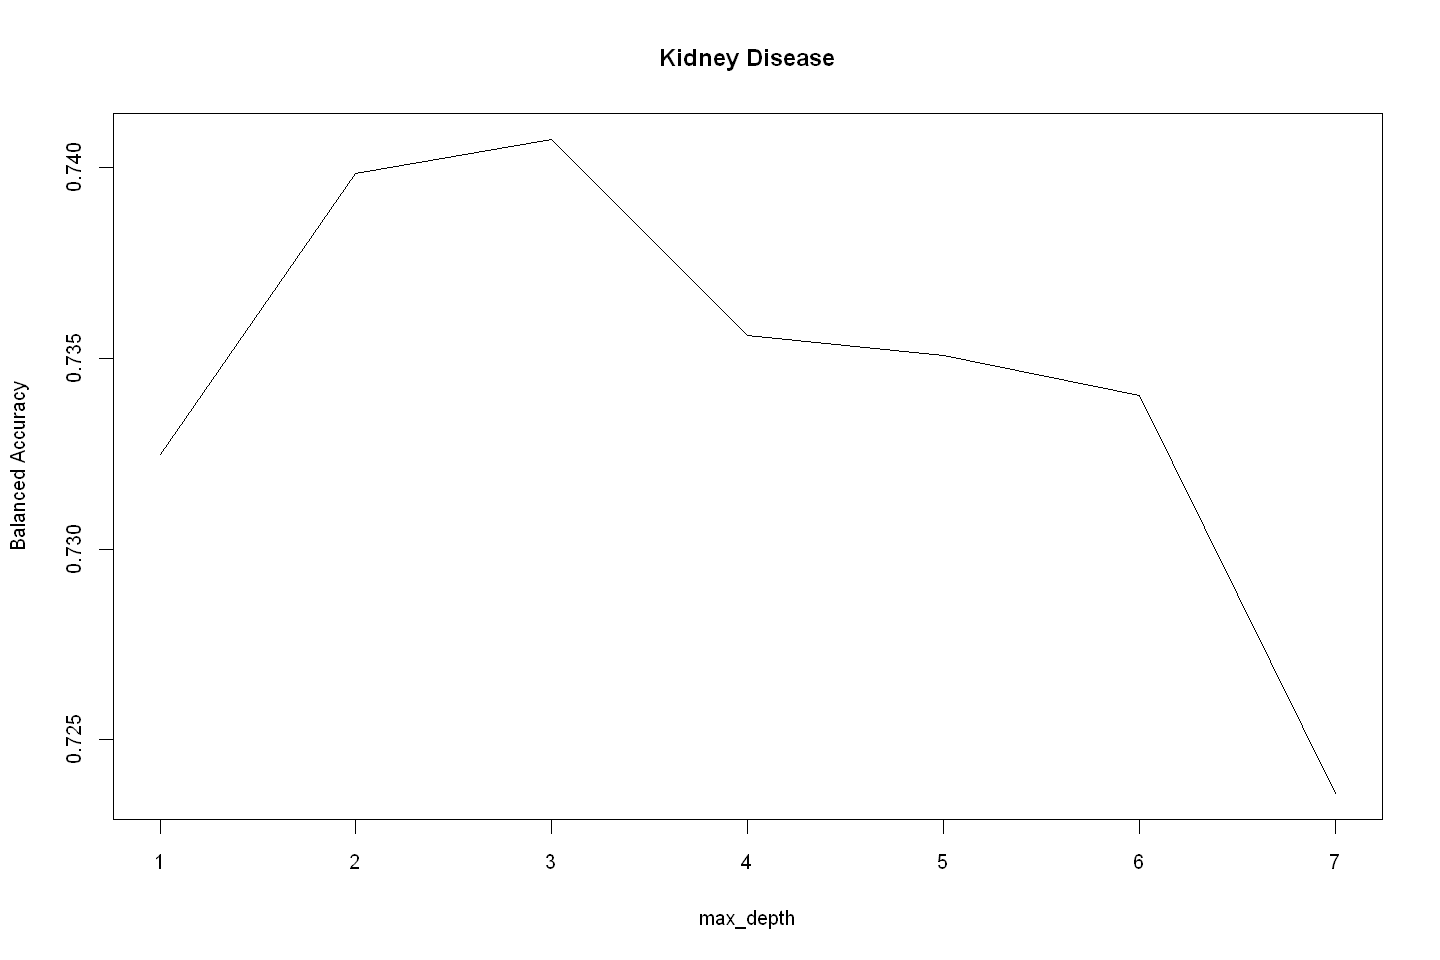

In [34]:
# Check max_depth
accuracy8<-c()
max_depth <- c(1:7)
for (i in 1:7){
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=i, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[i] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(max_depth, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Kidney Disease')
# Extract best value for max_depth
print(paste("Best max_depth:",max_depth[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best eta: 0.1"
[1] "New balanced accuracy: 0.740743973186564"


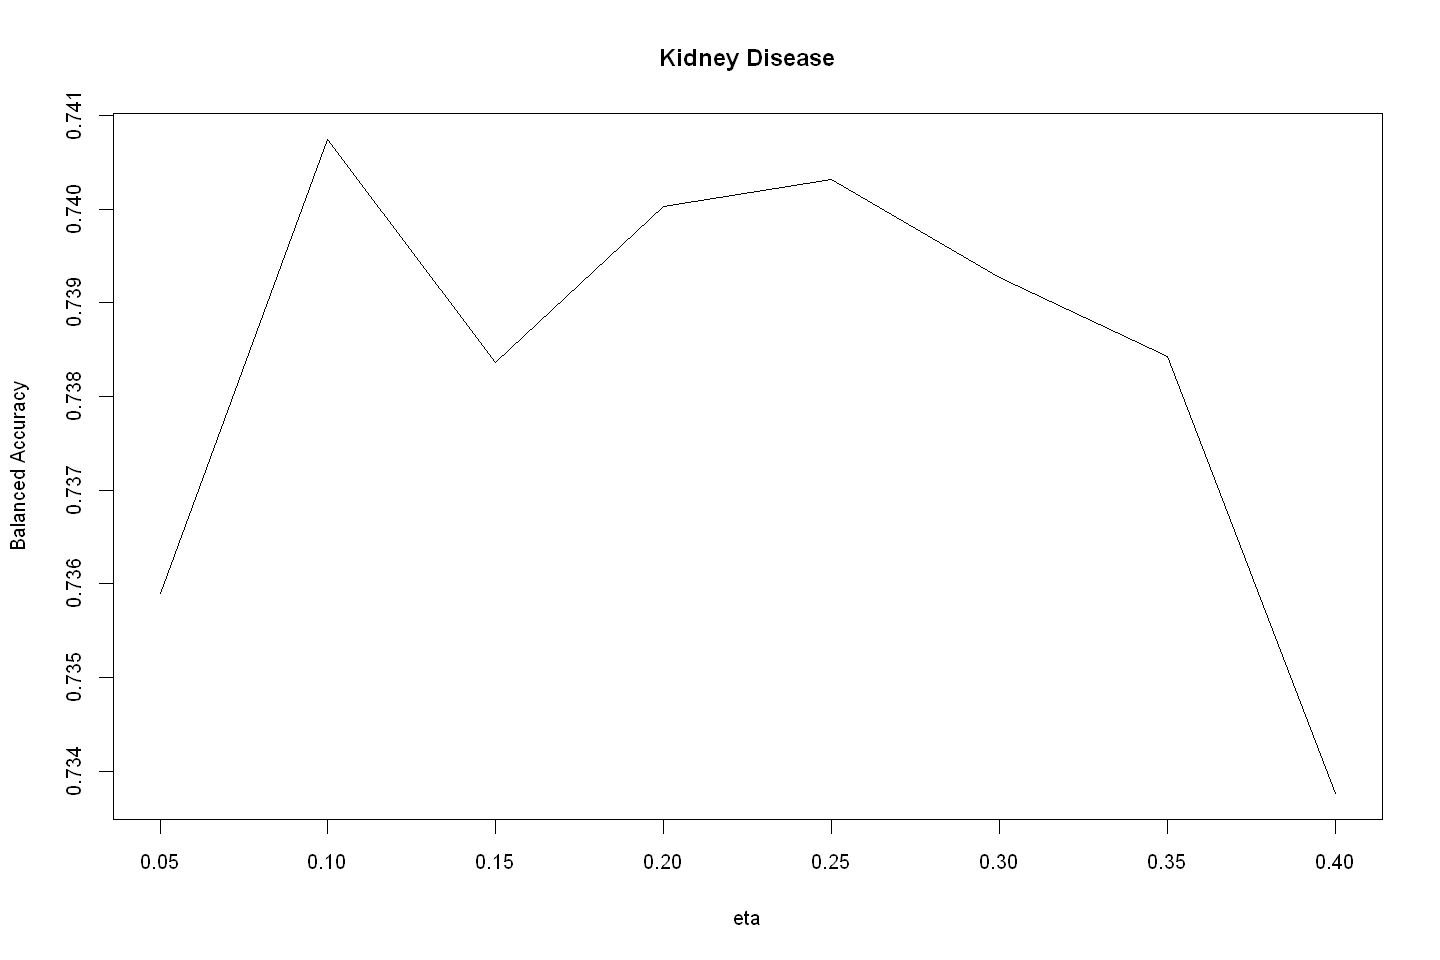

In [35]:
# Check eta
accuracy8<-c()
eta <- seq(0.05, 0.4, by=0.05)
for (i in eta){
index<-match(i,eta)
    #print(index)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=3, eta=i, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(eta, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Kidney Disease')
# Extract best value for eta
print(paste("Best eta:",eta[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best nrounds: 36"
[1] "New balanced accuracy: 0.741637708556512"


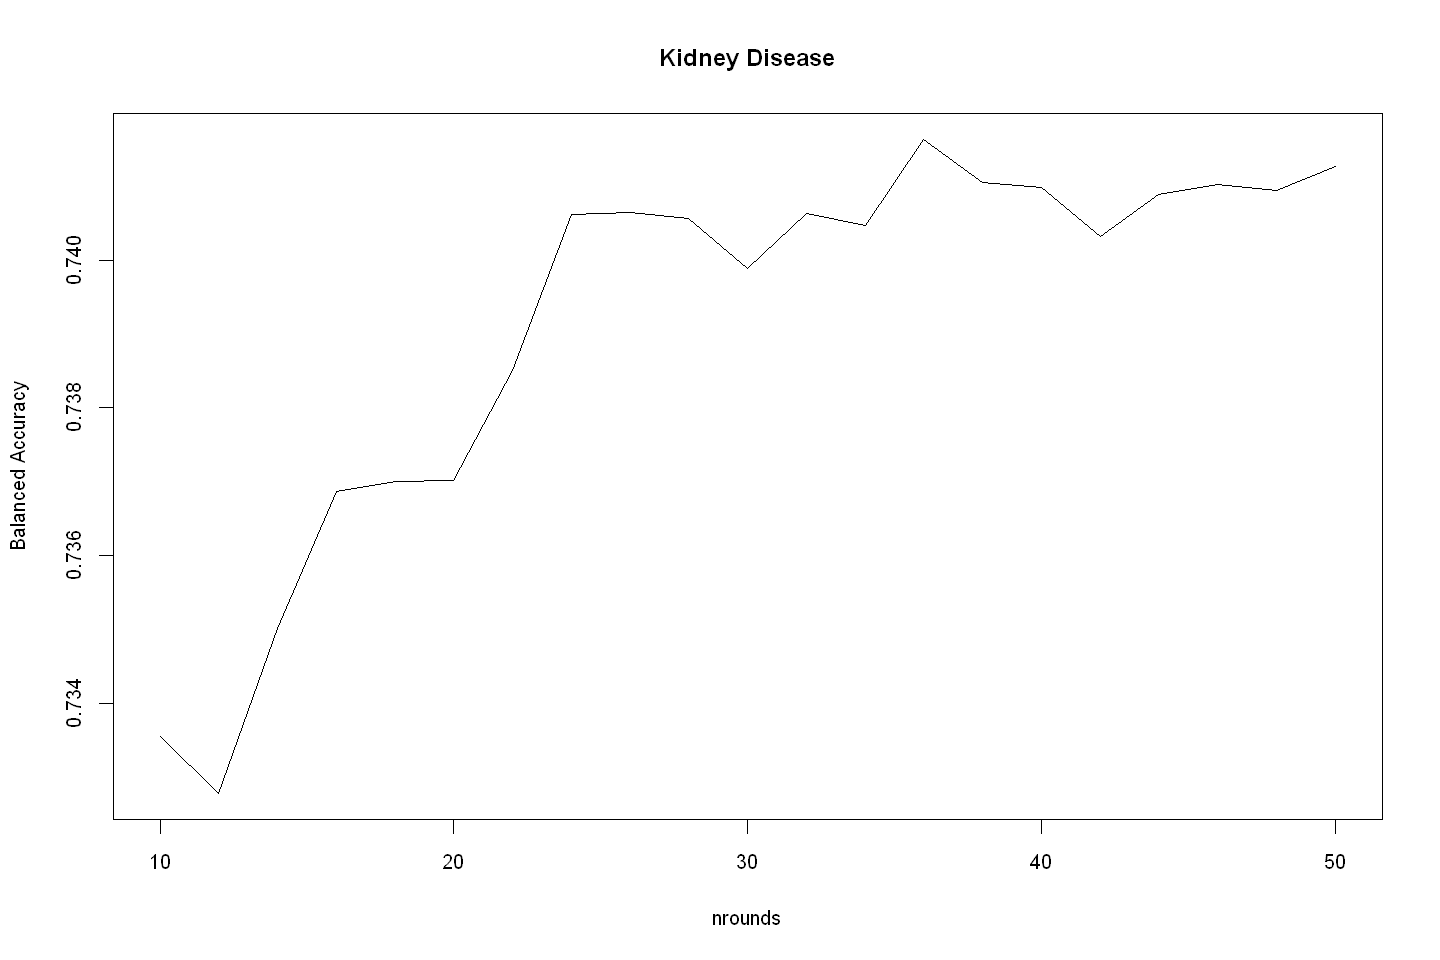

In [36]:
# Check nrounds
accuracy8<-c()
nrounds <- seq(10, 50, by=2)
for (i in nrounds){
index<-match(i,nrounds)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=i, max_depth=3, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(nrounds, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Kidney Disease')
# Extract best value for nrounds
print(paste("Best nrounds:",nrounds[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))
    

$TP
[1] 3383

$FN
[1] 1049

$TN
[1] 84552

$FP
[1] 31604

$NPV
[1] 0.9877

$FPR
[1] 0.2721

$TPR
[1] 0.7633

$TNR
[1] 0.7279

$FNR
[1] 0.2367

$threatScore
[1] 0.0939

$balancedacc
[1] 0.7456

$threshold
[1] 0.5

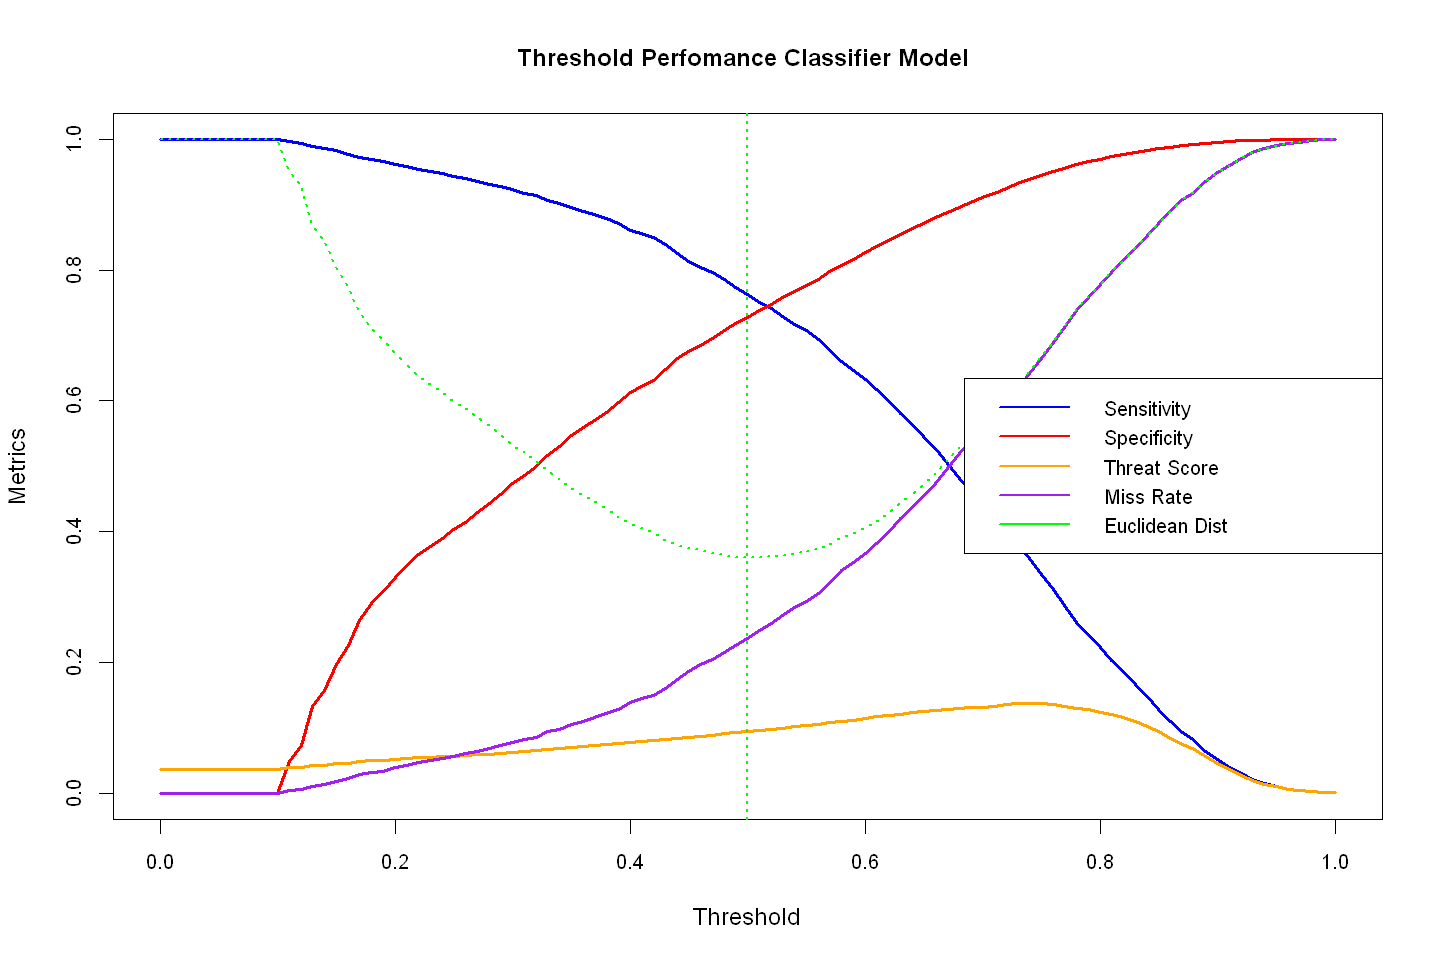

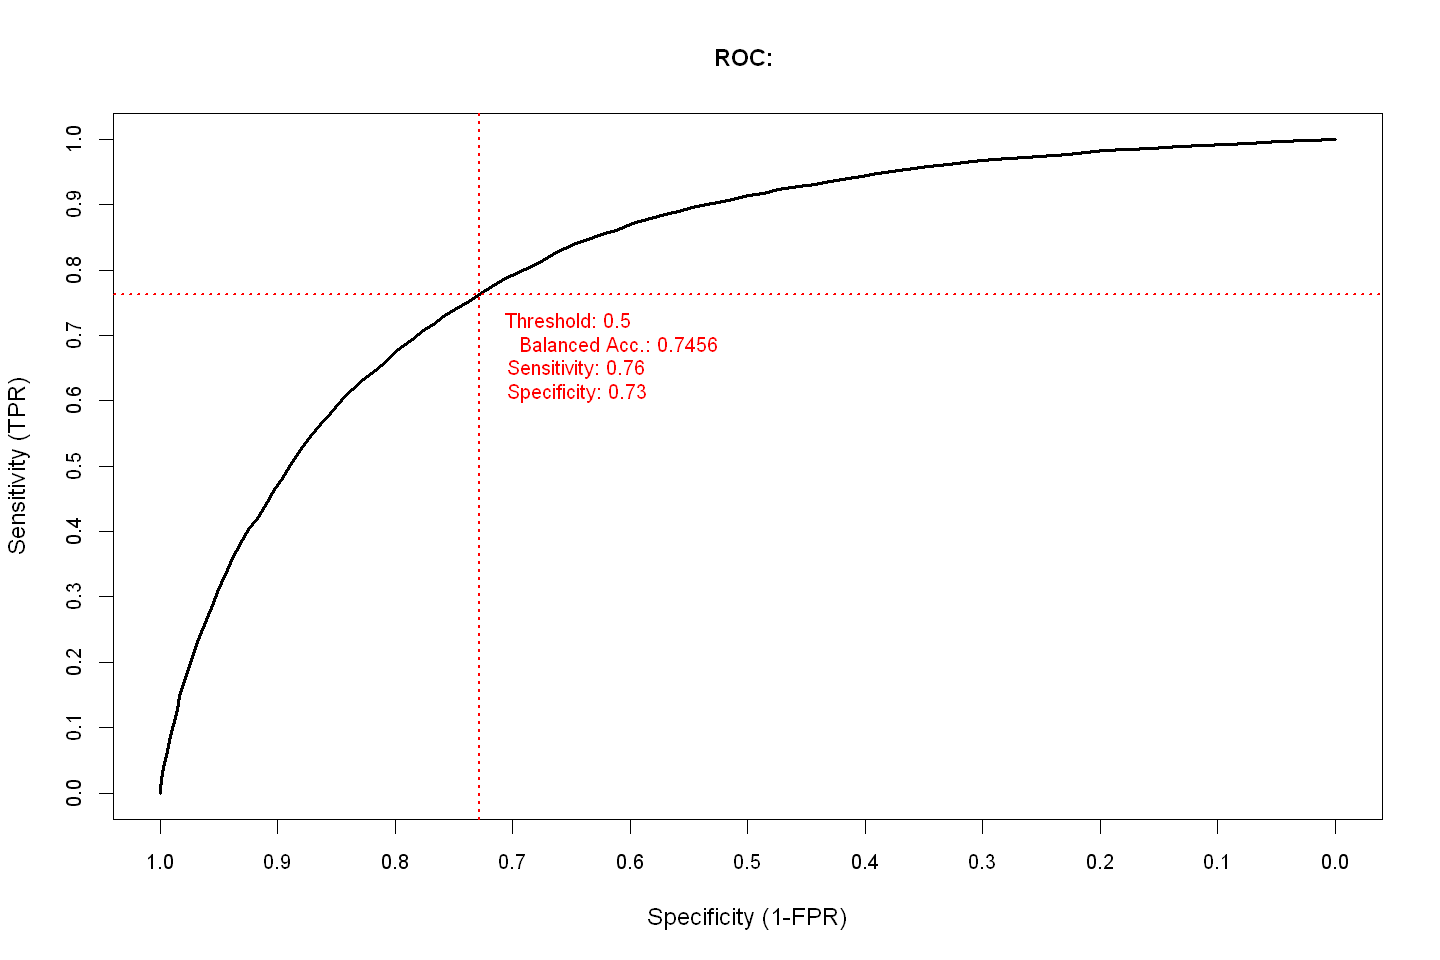

In [37]:
### Final model now trained on complete dataset ###

# KIDNEYDISEASE
data_col_index = 20
train = undersampleKIDNEY2 # full training dataset
test = test2 # full testing dataset

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with best nrounds, max_depth, eta
xgbc = xgboost(data=xgb_train, nrounds=36, max_depth=3, eta=0.1, verbose=0)

# Fit the model
pred = predict(xgbc,xgb_test)

### Determine best threshold ###

#setting options for this cell for better viewing
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)

#calling function to plot graphs and view values
measures_KIDNEY<-getTreeClassifications(myTree = xgbc,
                                           test_y,
                                           pred,
                                           title='',
                                           plot=TRUE)

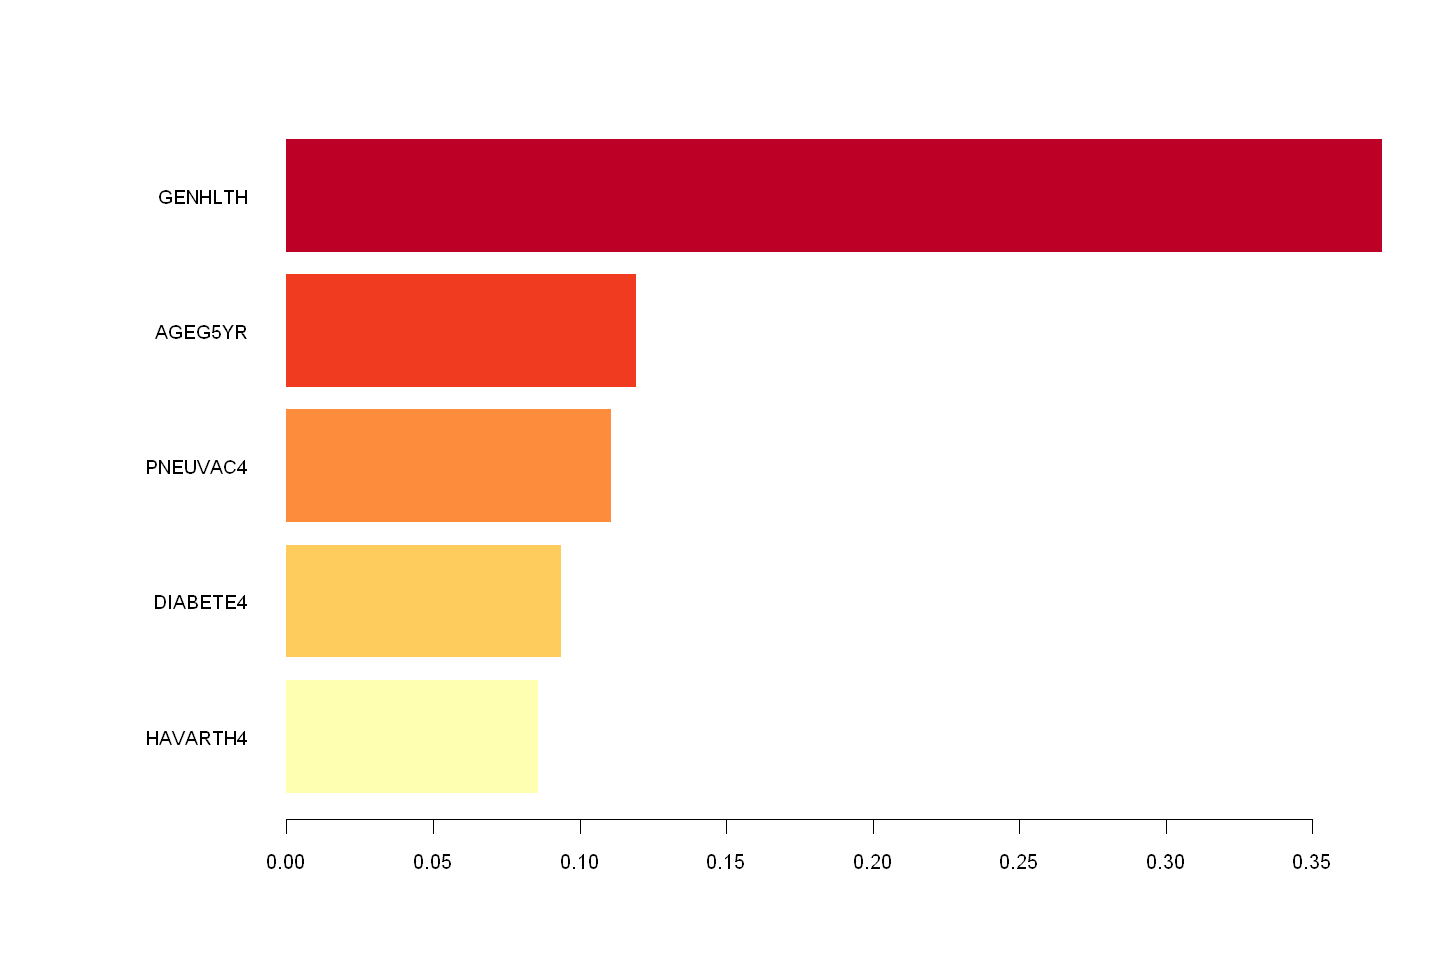

In [38]:
### Feature Importance ###

# Compute feature importance matrix
importance_matrix = xgb.importance(colnames(xgb_train), model = xgbc)

# Plotting importances
xgb.plot.importance(importance_matrix[1:5,], col=p)

## Skin Cancer Classifier

In [39]:
#SKINCANCER
data_col_index = 15
train = undersampleSKIN

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)

TN <- cm[1]
TP <- cm[4]
FP <- cm[2]
FN <- cm[3]

print(evaluation)
calcMeasures(TP,FN,FP,TN)

Confusion Matrix and Statistics

    obs
pred     0     1
   0 72031  2432
   1 37752  8373
                                          
               Accuracy : 0.6668          
                 95% CI : (0.6641, 0.6694)
    No Information Rate : 0.9104          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1743          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6561          
            Specificity : 0.7749          
         Pos Pred Value : 0.9673          
         Neg Pred Value : 0.1815          
             Prevalence : 0.9104          
         Detection Rate : 0.5973          
   Detection Prevalence : 0.6175          
      Balanced Accuracy : 0.7155          
                                          
       'Positive' Class : 0               
                                          


Warning message in (TP + FP) * (TP + FN) * (TN + FP):
"NAs produced by integer overflow"


$TP
[1] 8373

$FN
[1] 2432

$TN
[1] 72031

$FP
[1] 37752

$accuracy
[1] 66.68

$precision
[1] 18.15

$NPV
[1] 96.73

$FPR
[1] 34.39

$TPR
[1] 77.49

$TNR
[1] 65.61

$MCC
[1] NA

$FNR
[1] 22.51

$F1
[1] 29.42

$ThreatScore
[1] 17.24

[1] "Best max_depth: 4"
[1] "New balanced accuracy: 0.730618391302689"


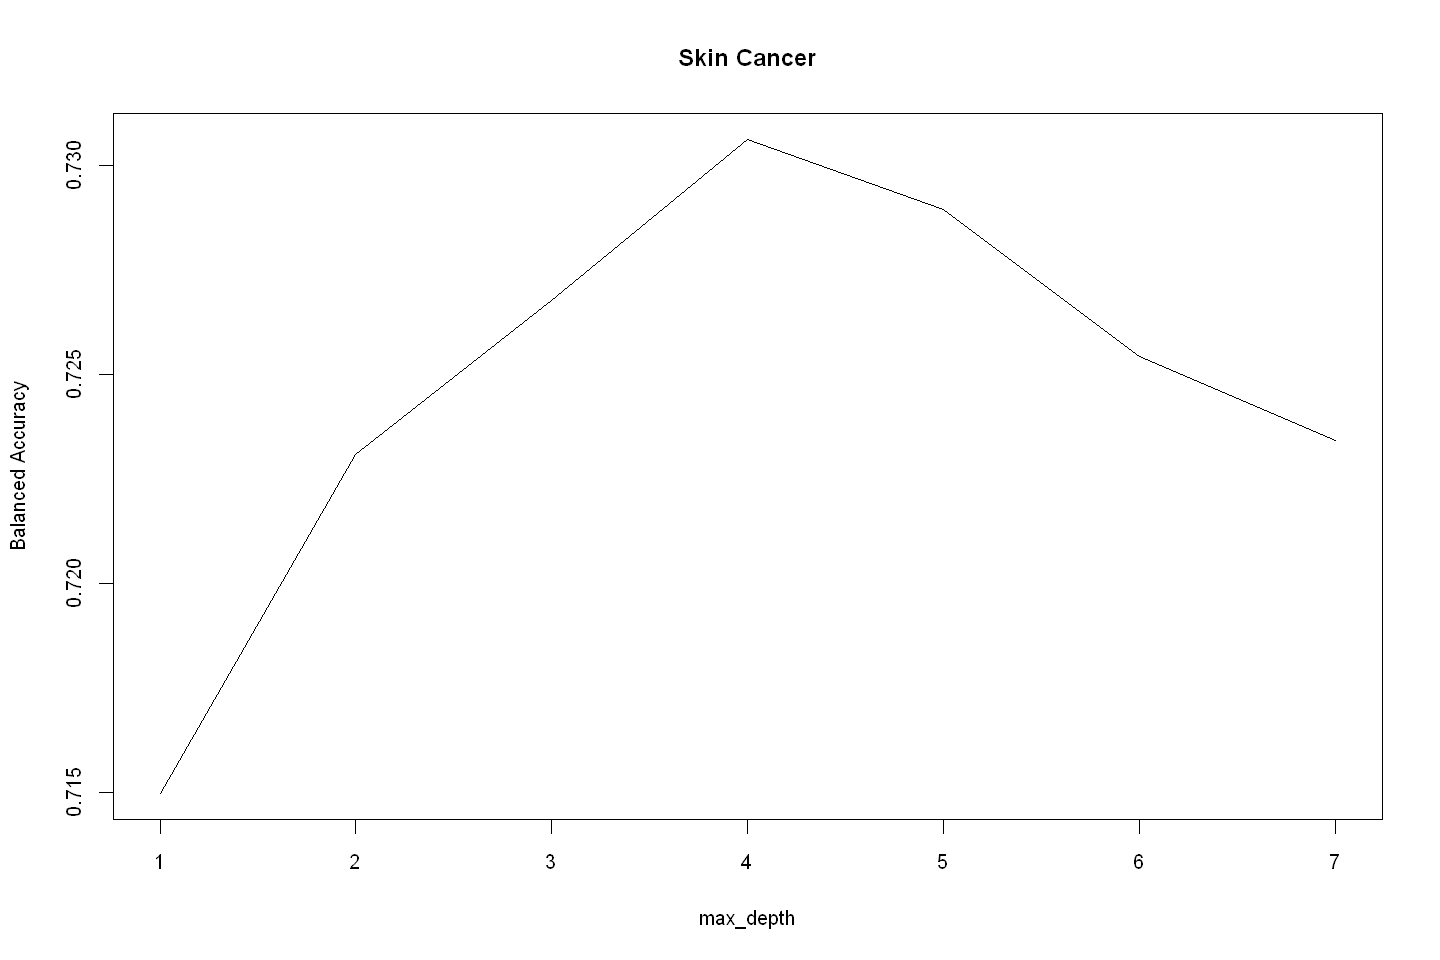

In [40]:
# Check max_depth
accuracy8<-c()
max_depth <- c(1:7)
for (i in 1:7){
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=i, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[i] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(max_depth, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Skin Cancer')
# Extract best value for max_depth
print(paste("Best max_depth:",max_depth[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best eta: 0.15"
[1] "New balanced accuracy: 0.731474321542726"


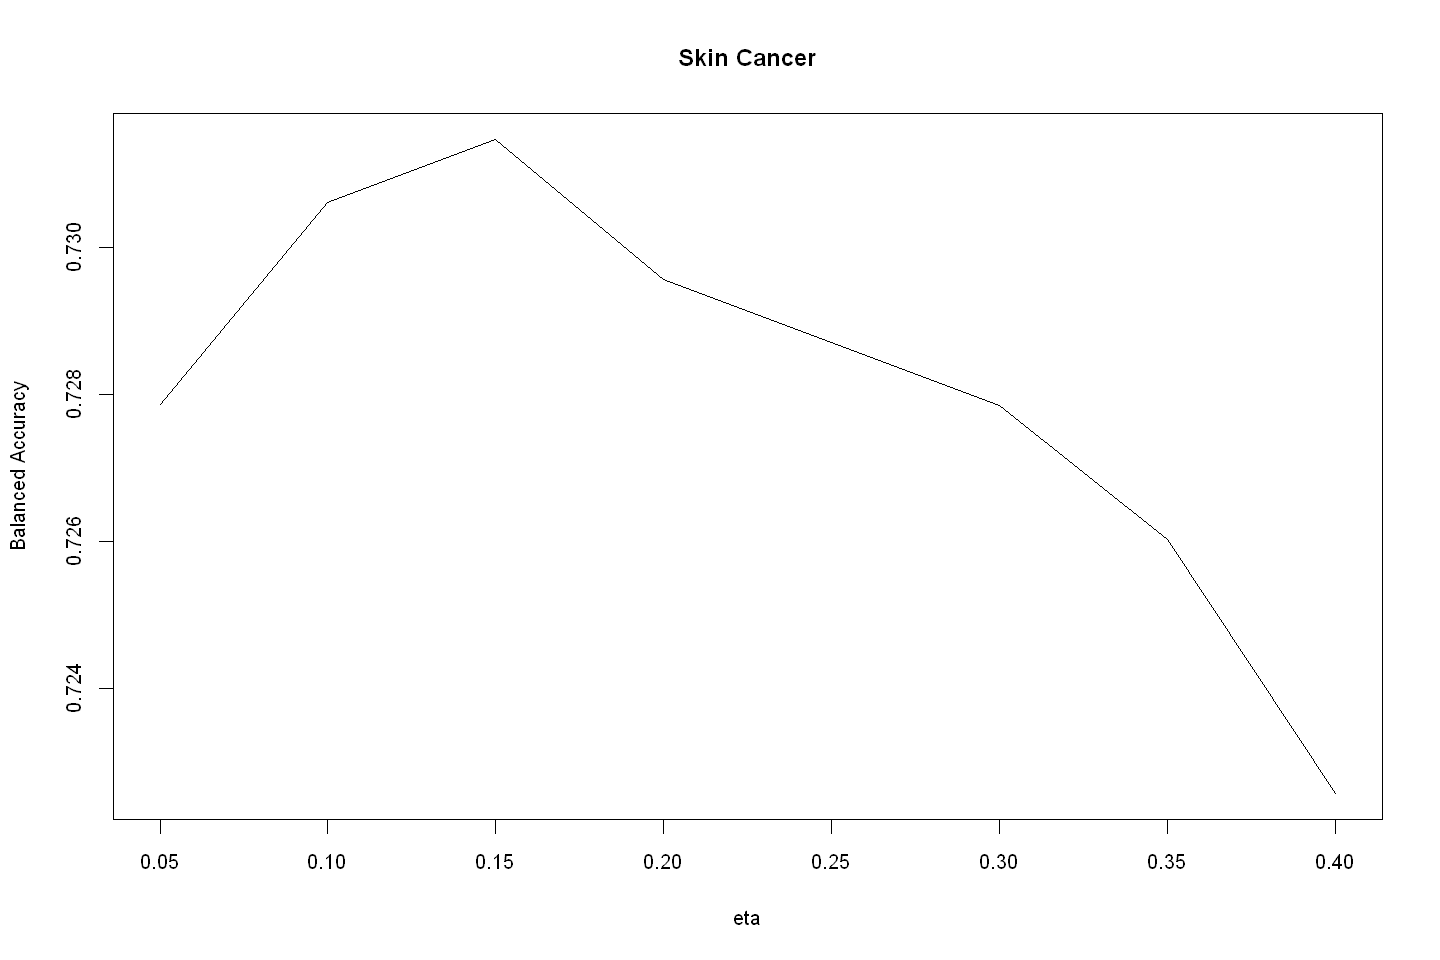

In [41]:
# Check eta
accuracy8<-c()
eta <- seq(0.05, 0.4, by=0.05)
for (i in eta){
index<-match(i,eta)
    #print(index)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=4, eta=i, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(eta, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Skin Cancer')
# Extract best value for eta
print(paste("Best eta:",eta[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best nrounds: 50"
[1] "New balanced accuracy: 0.732205223258505"


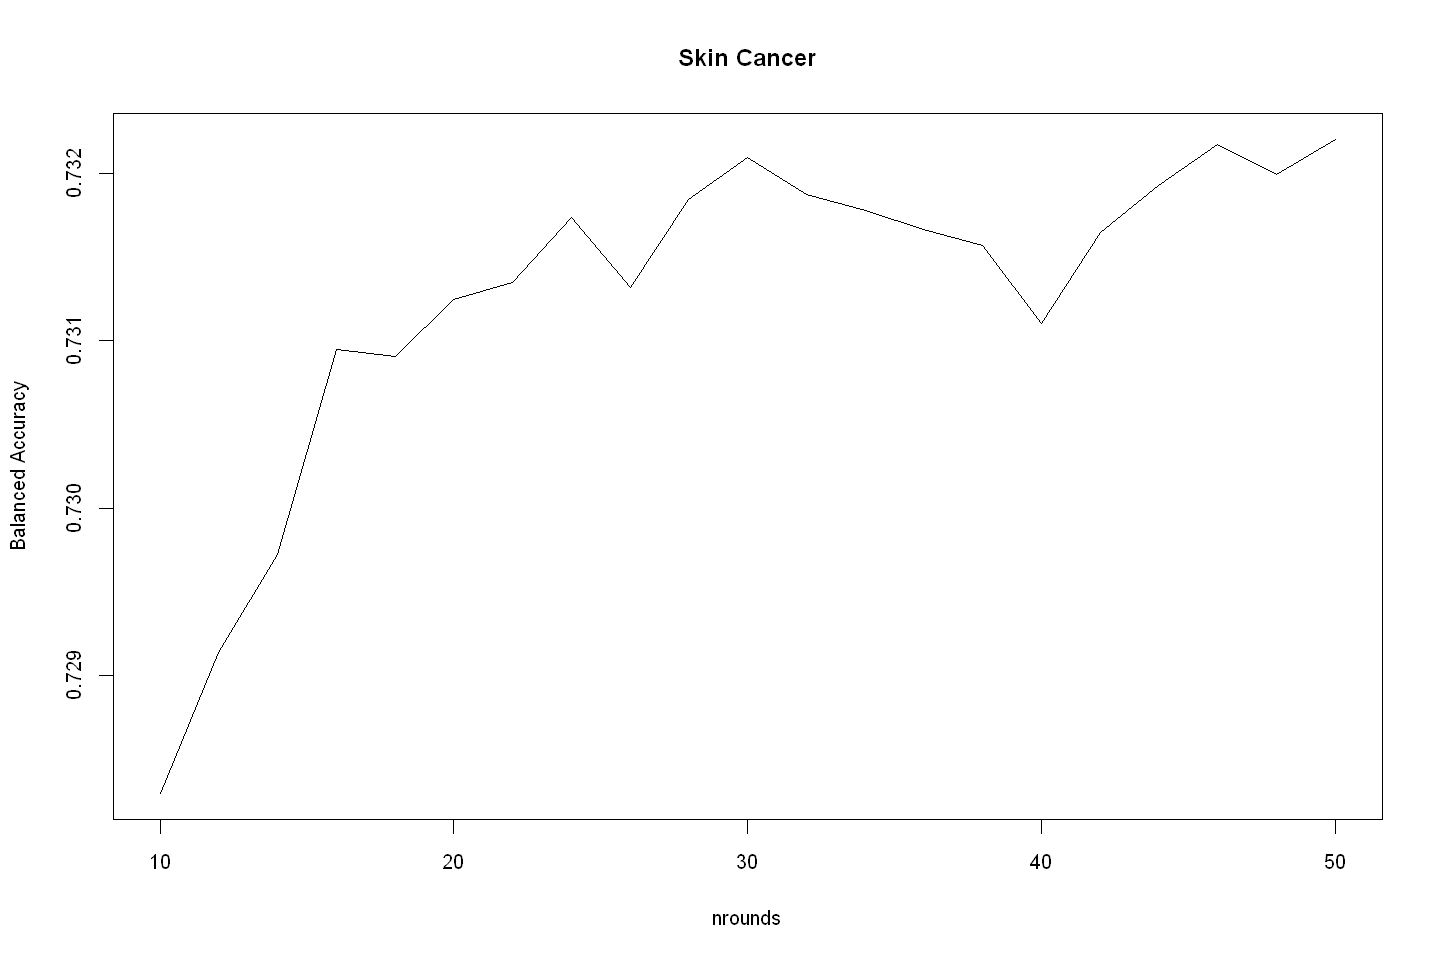

In [42]:
# Check nrounds
accuracy8<-c()
nrounds <- seq(10, 50, by=2)
for (i in nrounds){
index<-match(i,nrounds)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=i, max_depth=4, eta=0.15, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(nrounds, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Skin Cancer')
# Extract best value for nrounds
print(paste("Best nrounds:",nrounds[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))
    

$TP
[1] 8305

$FN
[1] 2500

$TN
[1] 77299

$FP
[1] 32484

$NPV
[1] 0.9687

$FPR
[1] 0.2959

$TPR
[1] 0.7686

$TNR
[1] 0.7041

$FNR
[1] 0.2314

$threatScore
[1] 0.1919

$balancedacc
[1] 0.7363

$threshold
[1] 0.54

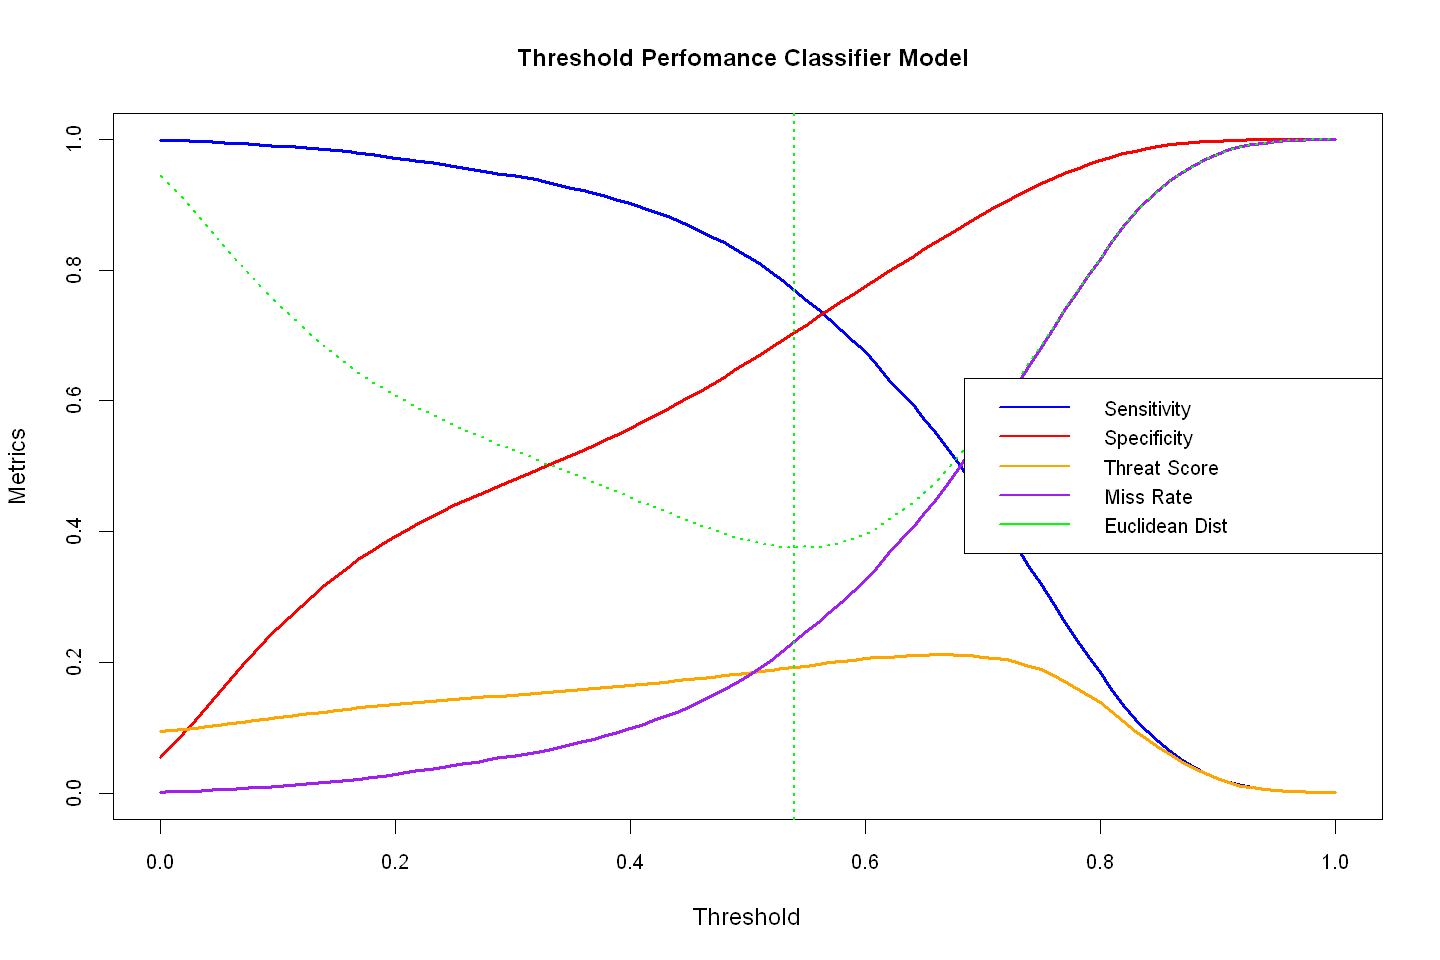

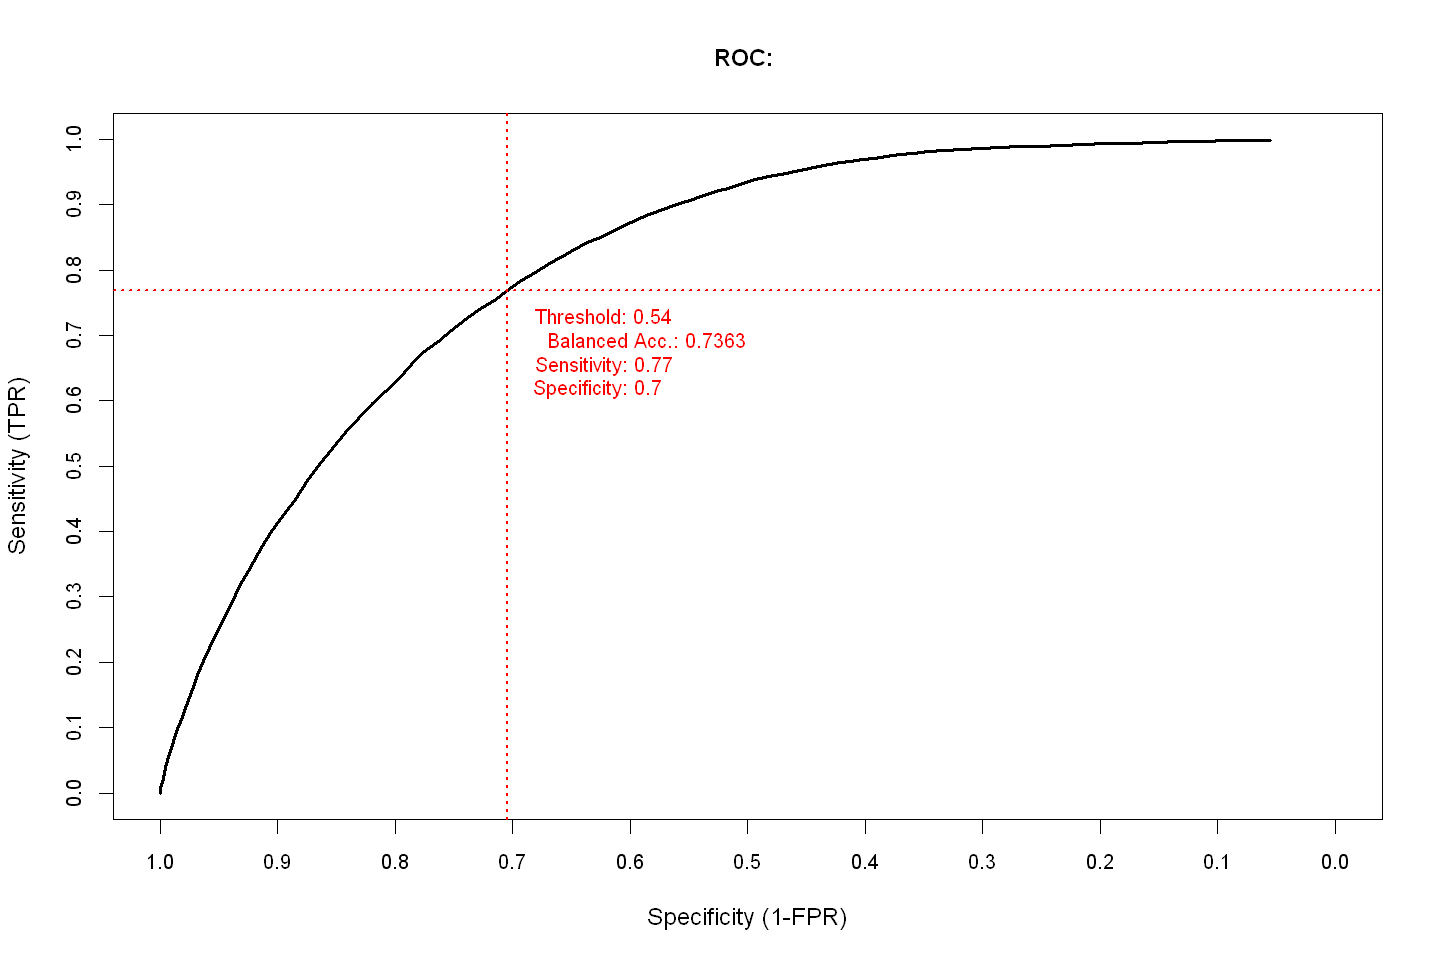

In [43]:
### Final model now trained on complete dataset ###

# SKINCANCER
data_col_index = 15
train = undersampleSKIN2 # full training dataset
test = test2 # full testing dataset

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with best nrounds, max_depth, eta
xgbc = xgboost(data=xgb_train, nrounds=50, max_depth=4, eta=0.15, verbose=0)

# Fit the model
pred = predict(xgbc,xgb_test)

### Determine best threshold ###

#setting options for this cell for better viewing
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)

#calling function to plot graphs and view values
measures_SKIN<-getTreeClassifications(myTree = xgbc,
                                           test_y,
                                           pred,
                                           title='',
                                           plot=TRUE)

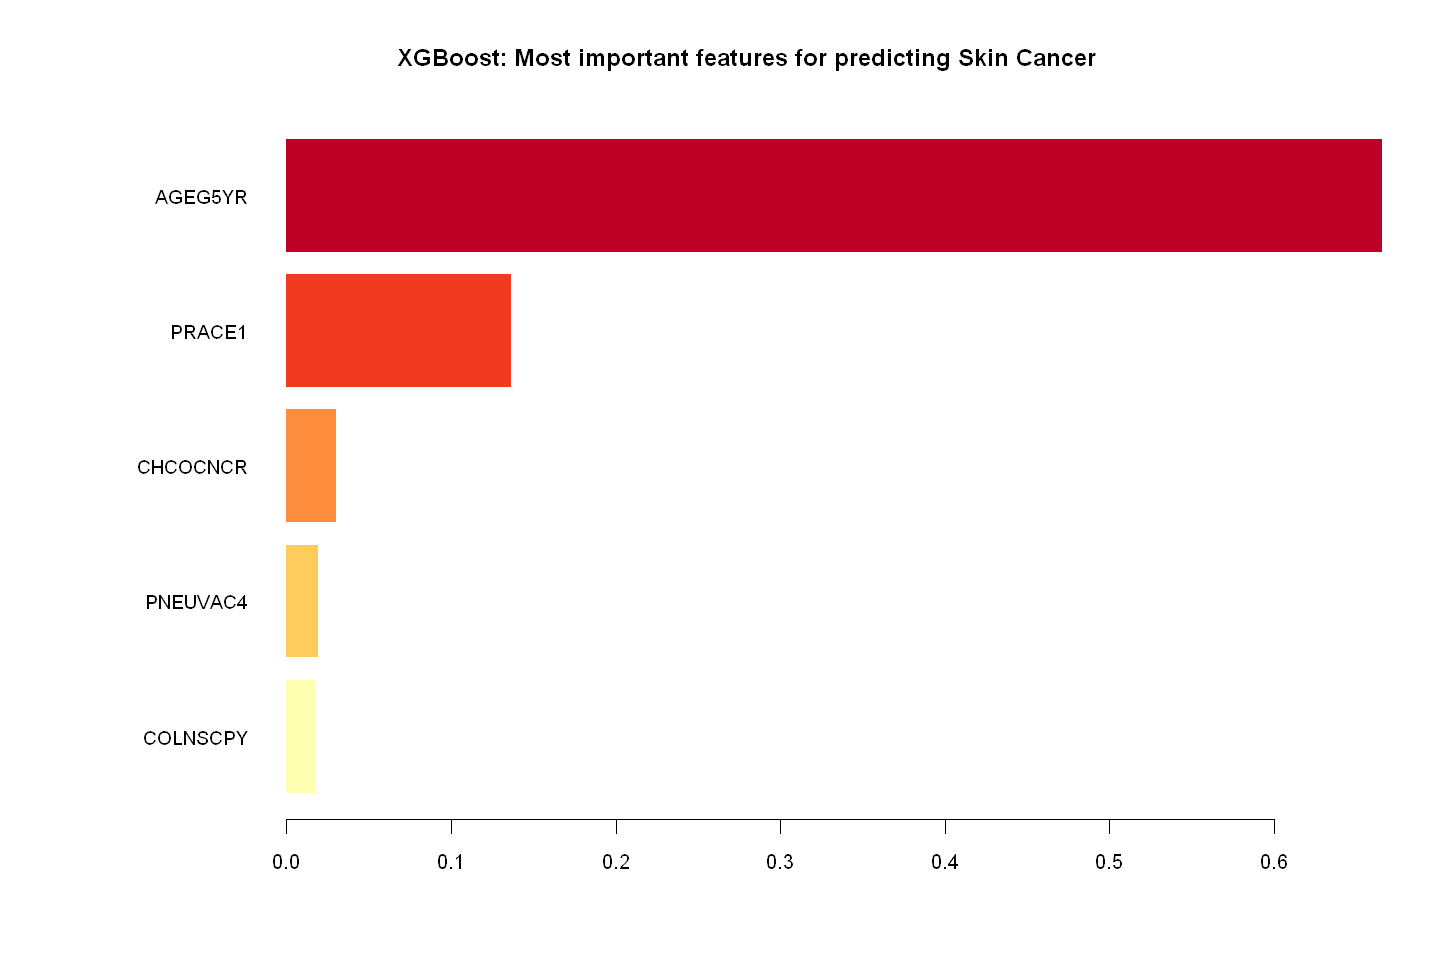

In [44]:
### Feature Importance ###

# Compute feature importance matrix
importance_matrix = xgb.importance(colnames(xgb_train), model = xgbc)

# Plotting importances
xgb.plot.importance(importance_matrix[1:5,], col=p)
title("XGBoost: Most important features for predicting Skin Cancer")

## CVD Classifier

In [45]:
#CVD
data_col_index = 12
train = undersampleHEART

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)

TN <- cm[1]
TP <- cm[4]
FP <- cm[2]
FN <- cm[3]

print(evaluation)
calcMeasures(TP,FN,FP,TN)

Confusion Matrix and Statistics

    obs
pred     0     1
   0 89729  1507
   1 24021  5331
                                         
               Accuracy : 0.7883         
                 95% CI : (0.786, 0.7906)
    No Information Rate : 0.9433         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.2232         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.7888         
            Specificity : 0.7796         
         Pos Pred Value : 0.9835         
         Neg Pred Value : 0.1816         
             Prevalence : 0.9433         
         Detection Rate : 0.7441         
   Detection Prevalence : 0.7566         
      Balanced Accuracy : 0.7842         
                                         
       'Positive' Class : 0              
                                         


Warning message in (TP + FP) * (TP + FN) * (TN + FP):
"NAs produced by integer overflow"


$TP
[1] 5331

$FN
[1] 1507

$TN
[1] 89729

$FP
[1] 24021

$accuracy
[1] 78.83

$precision
[1] 18.16

$NPV
[1] 98.35

$FPR
[1] 21.12

$TPR
[1] 77.96

$TNR
[1] 78.88

$MCC
[1] NA

$FNR
[1] 22.04

$F1
[1] 29.46

$ThreatScore
[1] 17.28

[1] "Best max_depth: 5"
[1] "New balanced accuracy: 0.794958843437931"


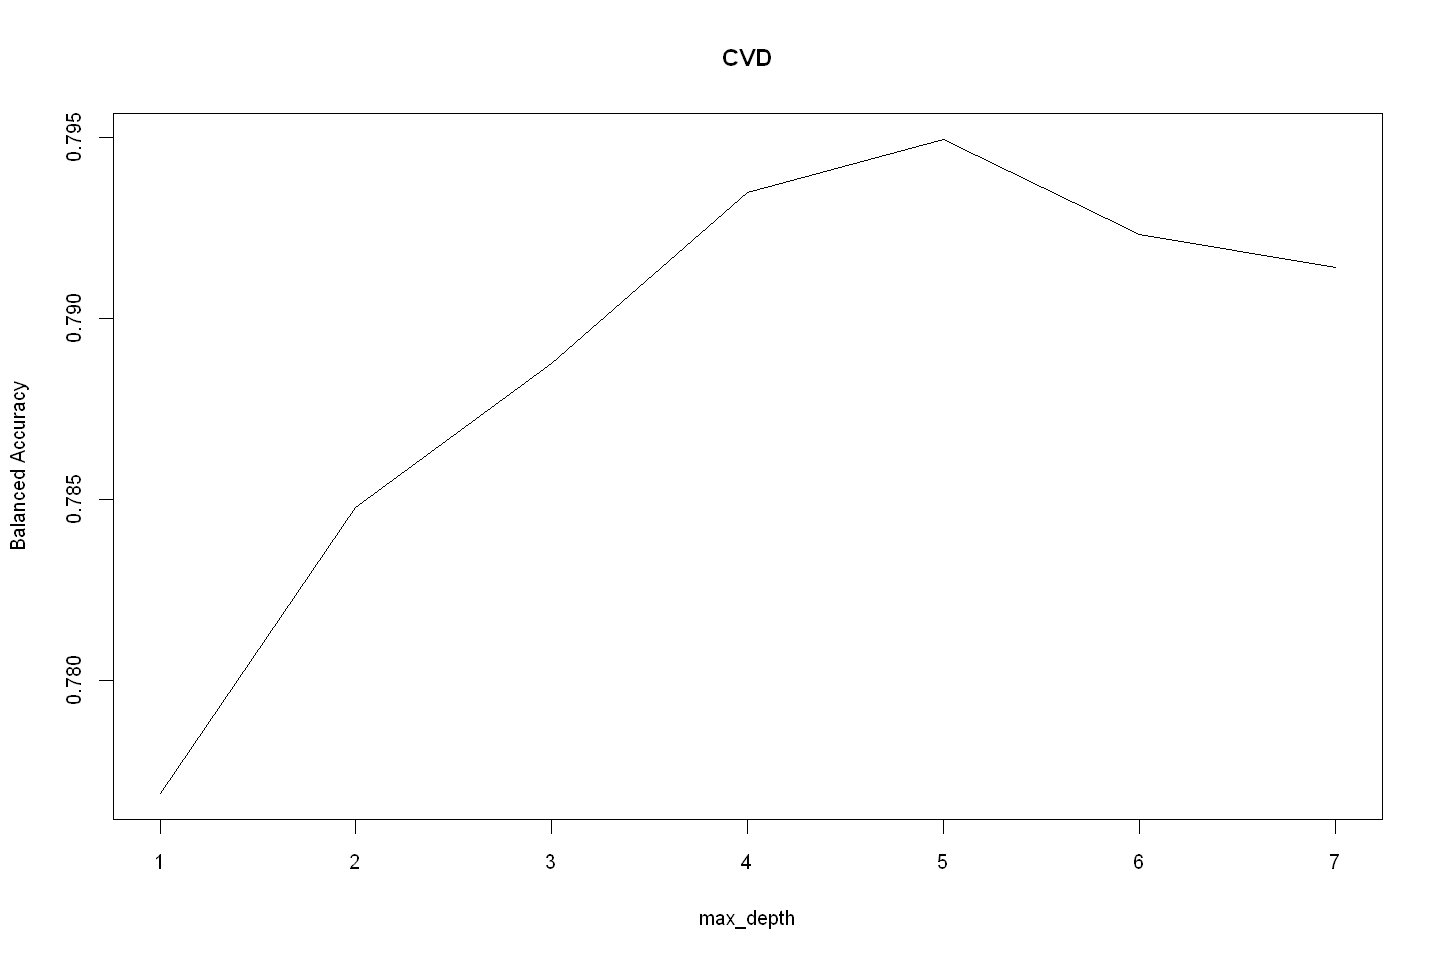

In [46]:
# Check max_depth
accuracy8<-c()
max_depth <- c(1:7)
for (i in 1:7){
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=i, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[i] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(max_depth, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'CVD')
# Extract best value for max_depth
print(paste("Best max_depth:",max_depth[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best eta: 0.1"
[1] "New balanced accuracy: 0.794958843437931"


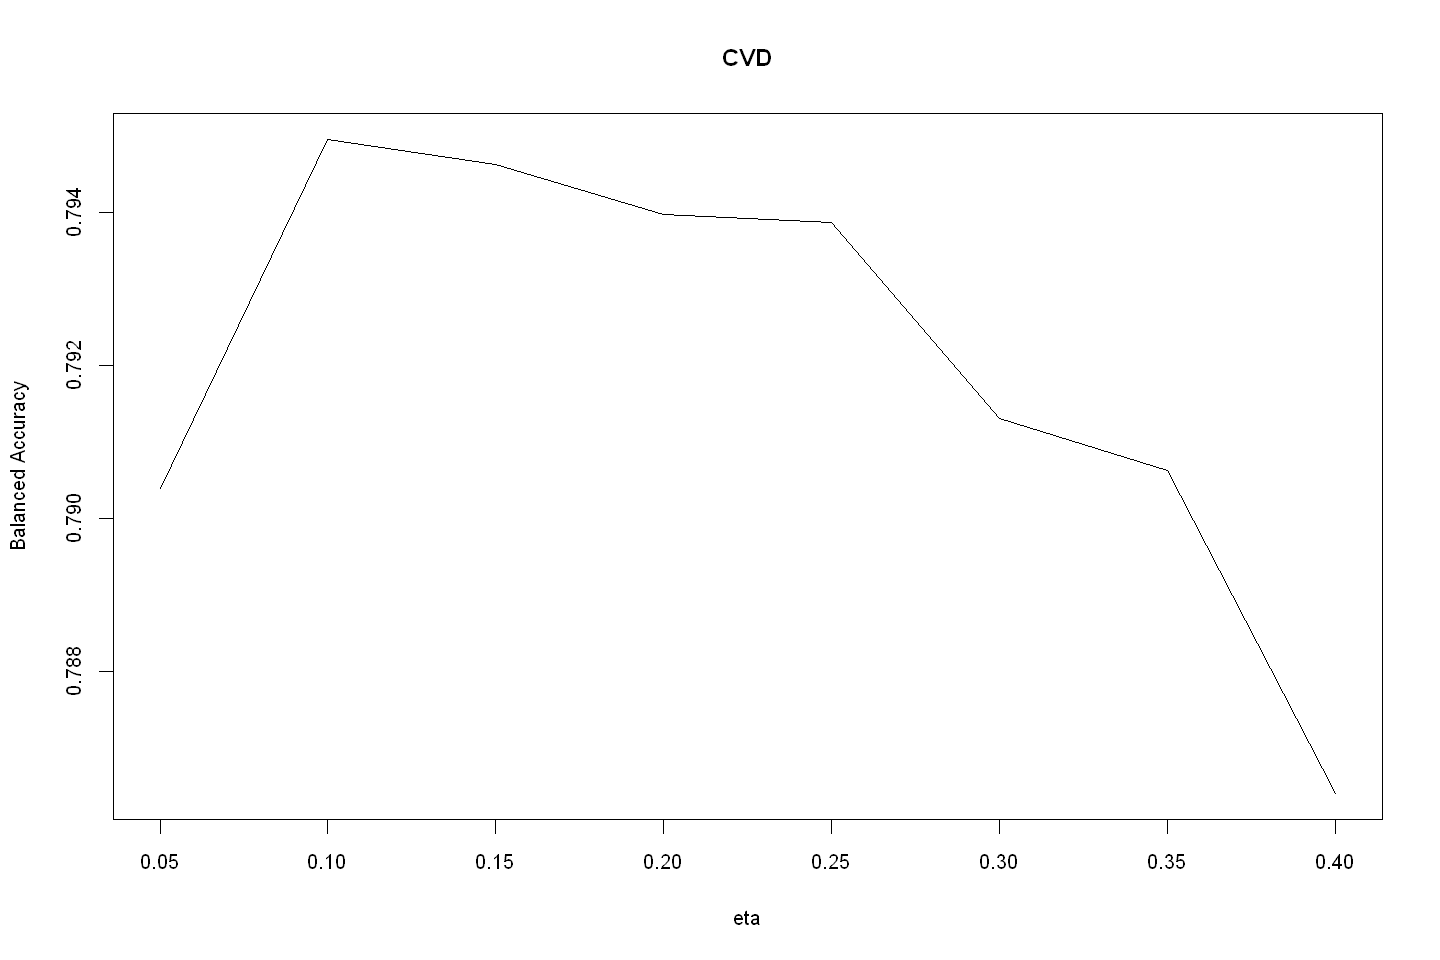

In [47]:
# Check eta
accuracy8<-c()
eta <- seq(0.05, 0.4, by=0.05)
for (i in eta){
index<-match(i,eta)
    #print(index)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=5, eta=i, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(eta, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'CVD')
# Extract best value for eta
print(paste("Best eta:",eta[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best nrounds: 38"
[1] "New balanced accuracy: 0.795848226298416"


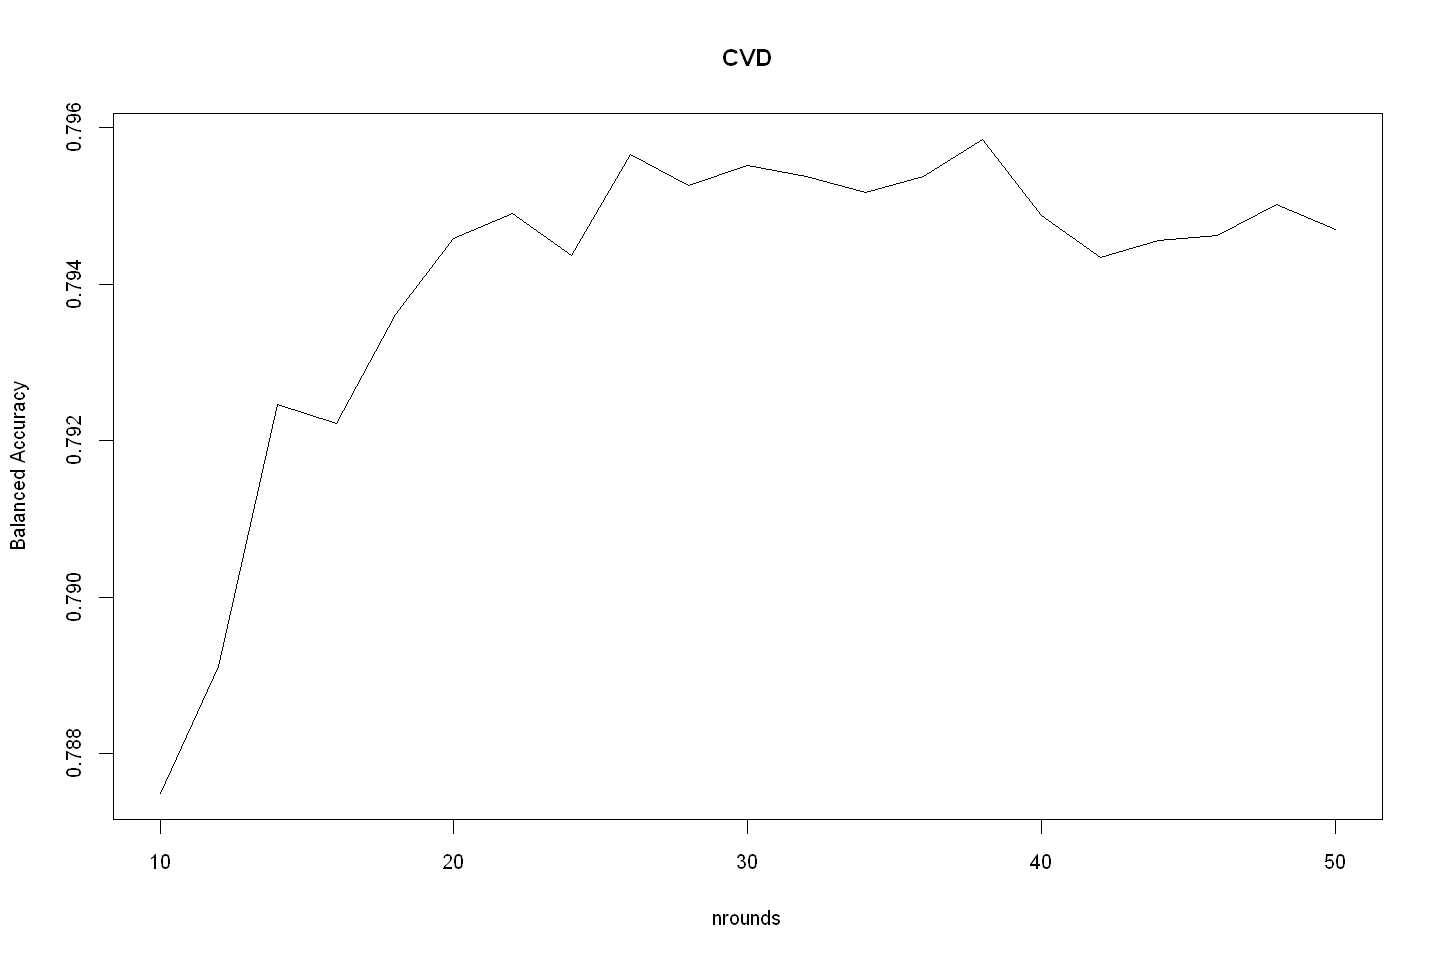

In [48]:
# Check nrounds
accuracy8<-c()
nrounds <- seq(10, 50, by=2)
for (i in nrounds){
index<-match(i,nrounds)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=i, max_depth=5, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(nrounds, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'CVD')
# Extract best value for nrounds
print(paste("Best nrounds:",nrounds[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))
    

$TP
[1] 5481

$FN
[1] 1357

$TN
[1] 91203

$FP
[1] 22547

$NPV
[1] 0.9853

$FPR
[1] 0.1982

$TPR
[1] 0.8016

$TNR
[1] 0.8018

$FNR
[1] 0.1984

$threatScore
[1] 0.1865

$balancedacc
[1] 0.8017

$threshold
[1] 0.5

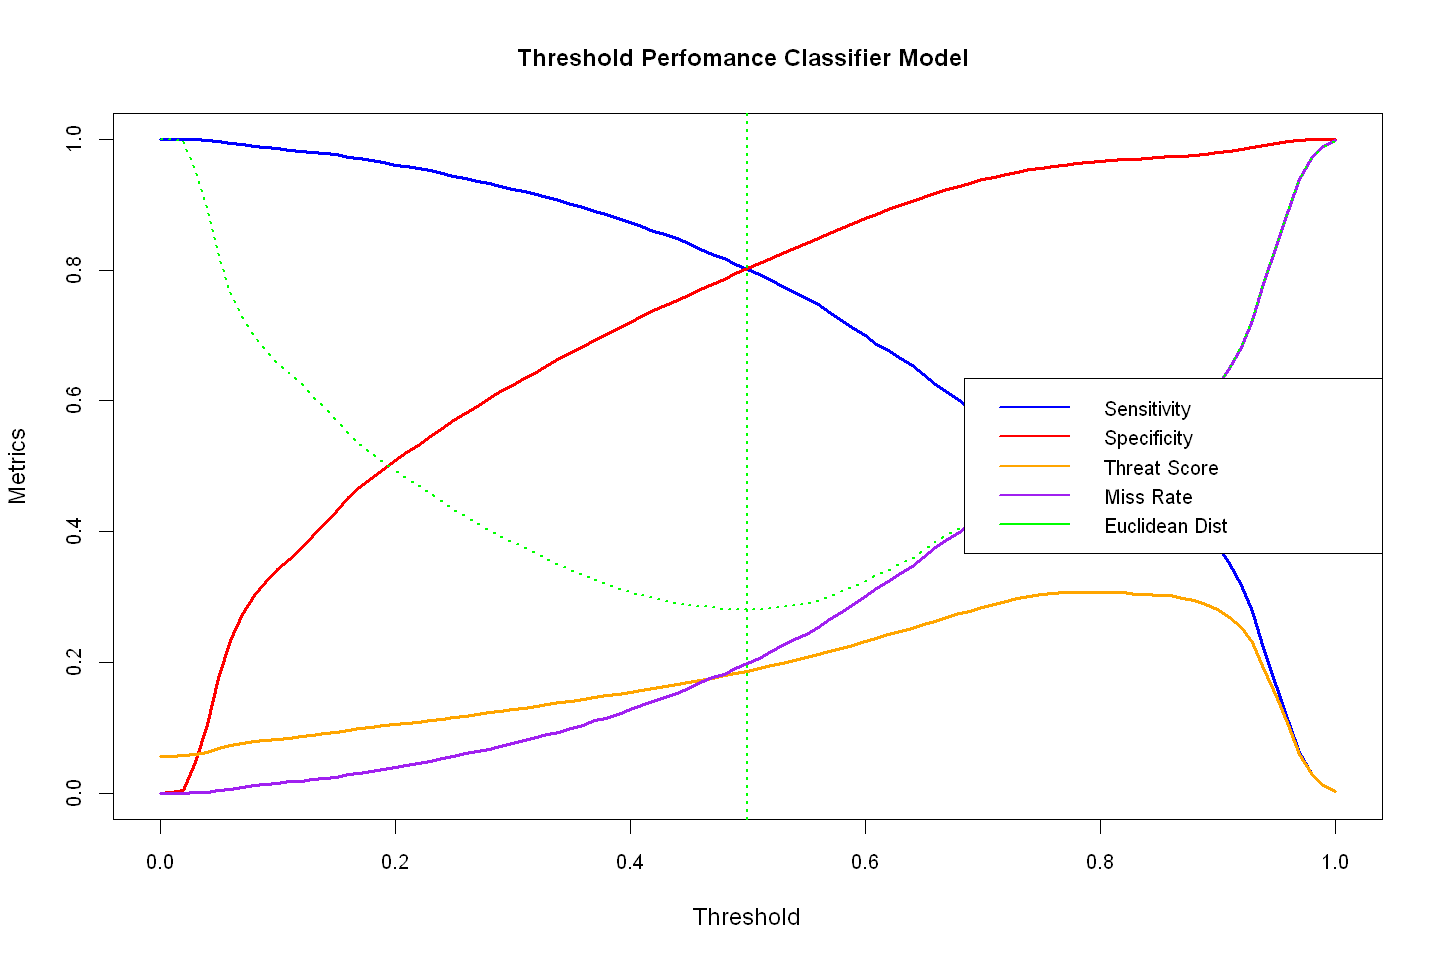

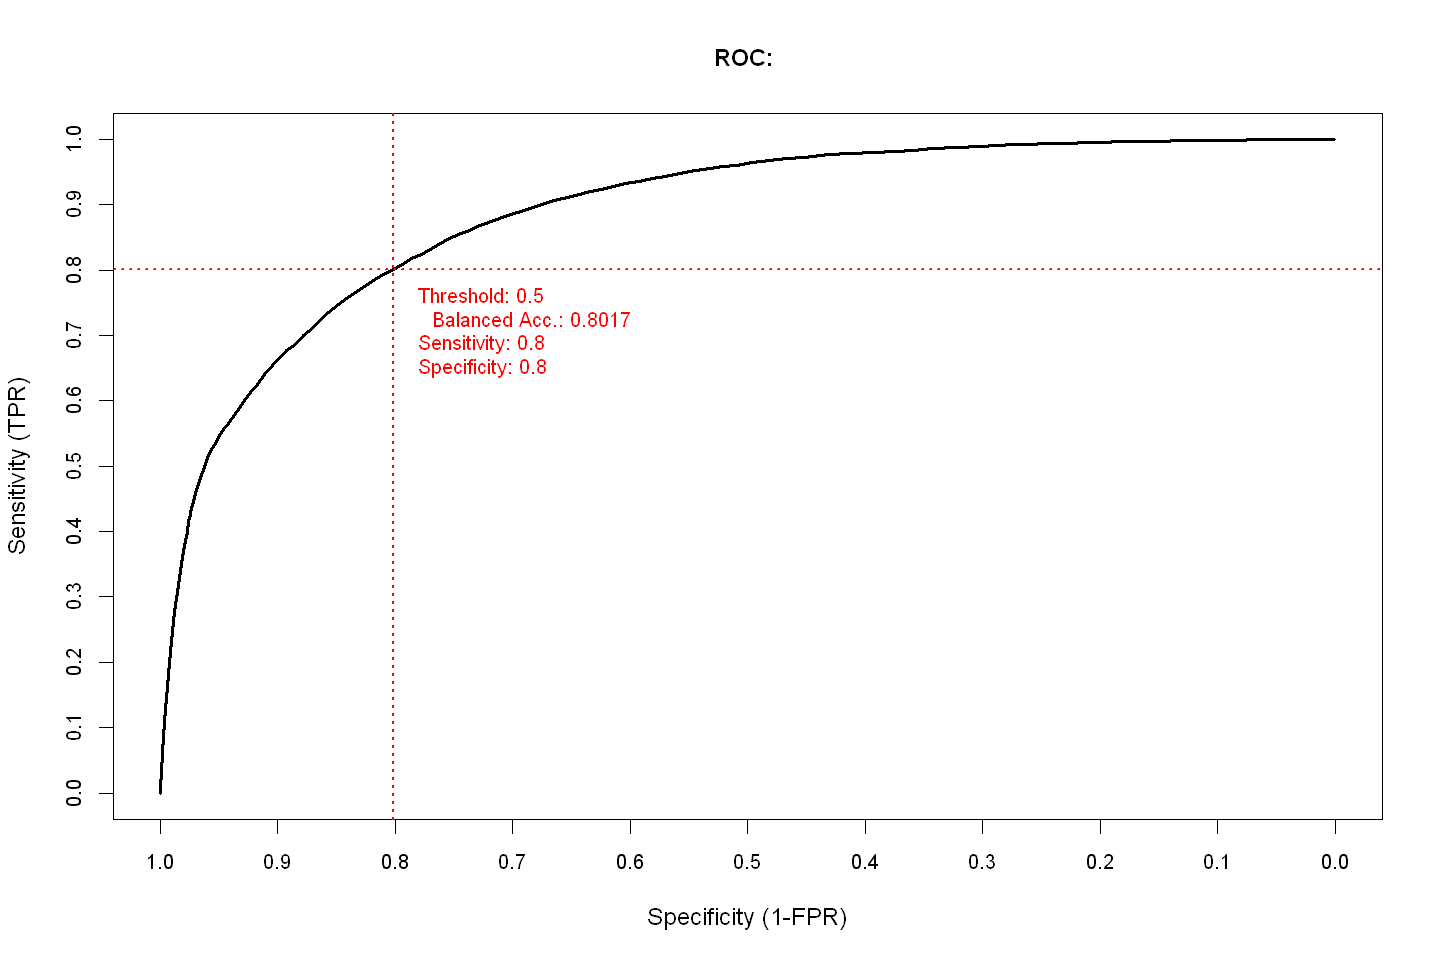

In [49]:
### Final model now trained on complete dataset ###

# CVD
data_col_index = 12
train = undersampleHEART2 # full training dataset
test = test2 # full testing dataset

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with best nrounds, max_depth, eta
xgbc = xgboost(data=xgb_train, nrounds=38, max_depth=5, eta=0.1, verbose=0)

# Fit the model
pred = predict(xgbc,xgb_test)

### Determine best threshold ###

#setting options for this cell for better viewing
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)

#calling function to plot graphs and view values
measures_CVD<-getTreeClassifications(myTree = xgbc,
                                           test_y,
                                           pred,
                                           title='',
                                           plot=TRUE)

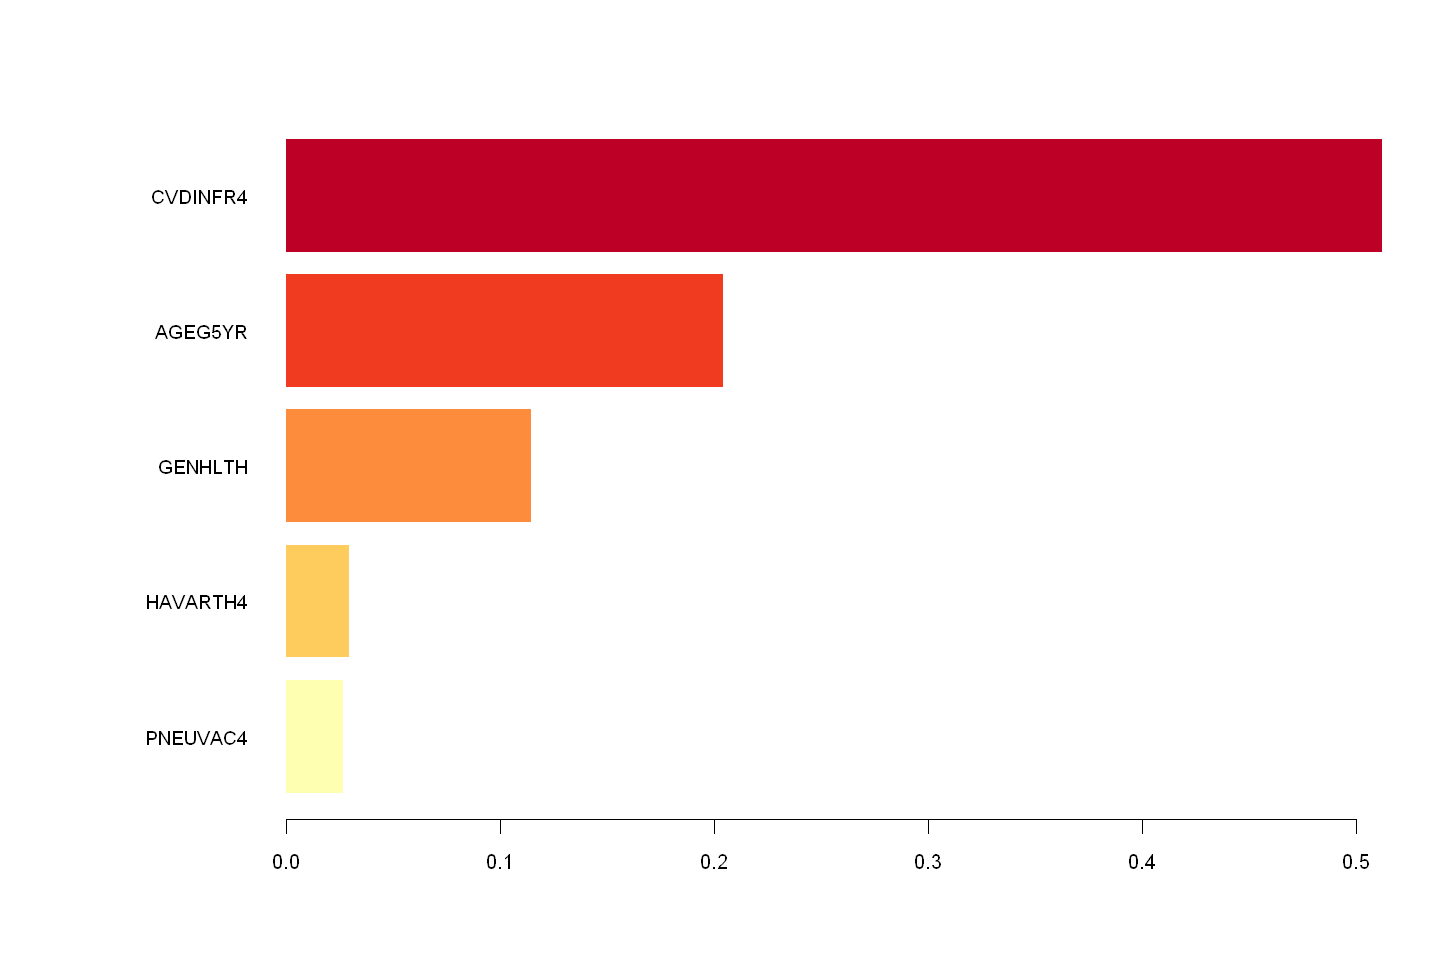

In [50]:
### Feature Importance ###

# Compute feature importance matrix
importance_matrix = xgb.importance(colnames(xgb_train), model = xgbc)

# Plotting importances
xgb.plot.importance(importance_matrix[1:5,], col=p)

## Asthma Classifer

In [51]:
#ASTHMA
data_col_index = 14
train = undersampleASTH

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)

TN <- cm[1]
TP <- cm[4]
FP <- cm[2]
FN <- cm[3]

print(evaluation)
calcMeasures(TP,FN,FP,TN)

Confusion Matrix and Statistics

    obs
pred     0     1
   0 71811  6733
   1 32503  9541
                                         
               Accuracy : 0.6746         
                 95% CI : (0.672, 0.6773)
    No Information Rate : 0.865          
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1647         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.6884         
            Specificity : 0.5863         
         Pos Pred Value : 0.9143         
         Neg Pred Value : 0.2269         
             Prevalence : 0.8650         
         Detection Rate : 0.5955         
   Detection Prevalence : 0.6513         
      Balanced Accuracy : 0.6373         
                                         
       'Positive' Class : 0              
                                         


Warning message in (TP + FP) * (TP + FN) * (TN + FP):
"NAs produced by integer overflow"


$TP
[1] 9541

$FN
[1] 6733

$TN
[1] 71811

$FP
[1] 32503

$accuracy
[1] 67.46

$precision
[1] 22.69

$NPV
[1] 91.43

$FPR
[1] 31.16

$TPR
[1] 58.63

$TNR
[1] 68.84

$MCC
[1] NA

$FNR
[1] 41.37

$F1
[1] 32.72

$ThreatScore
[1] 19.56

[1] "Best max_depth: 4"
[1] "New balanced accuracy: 0.651260392314015"


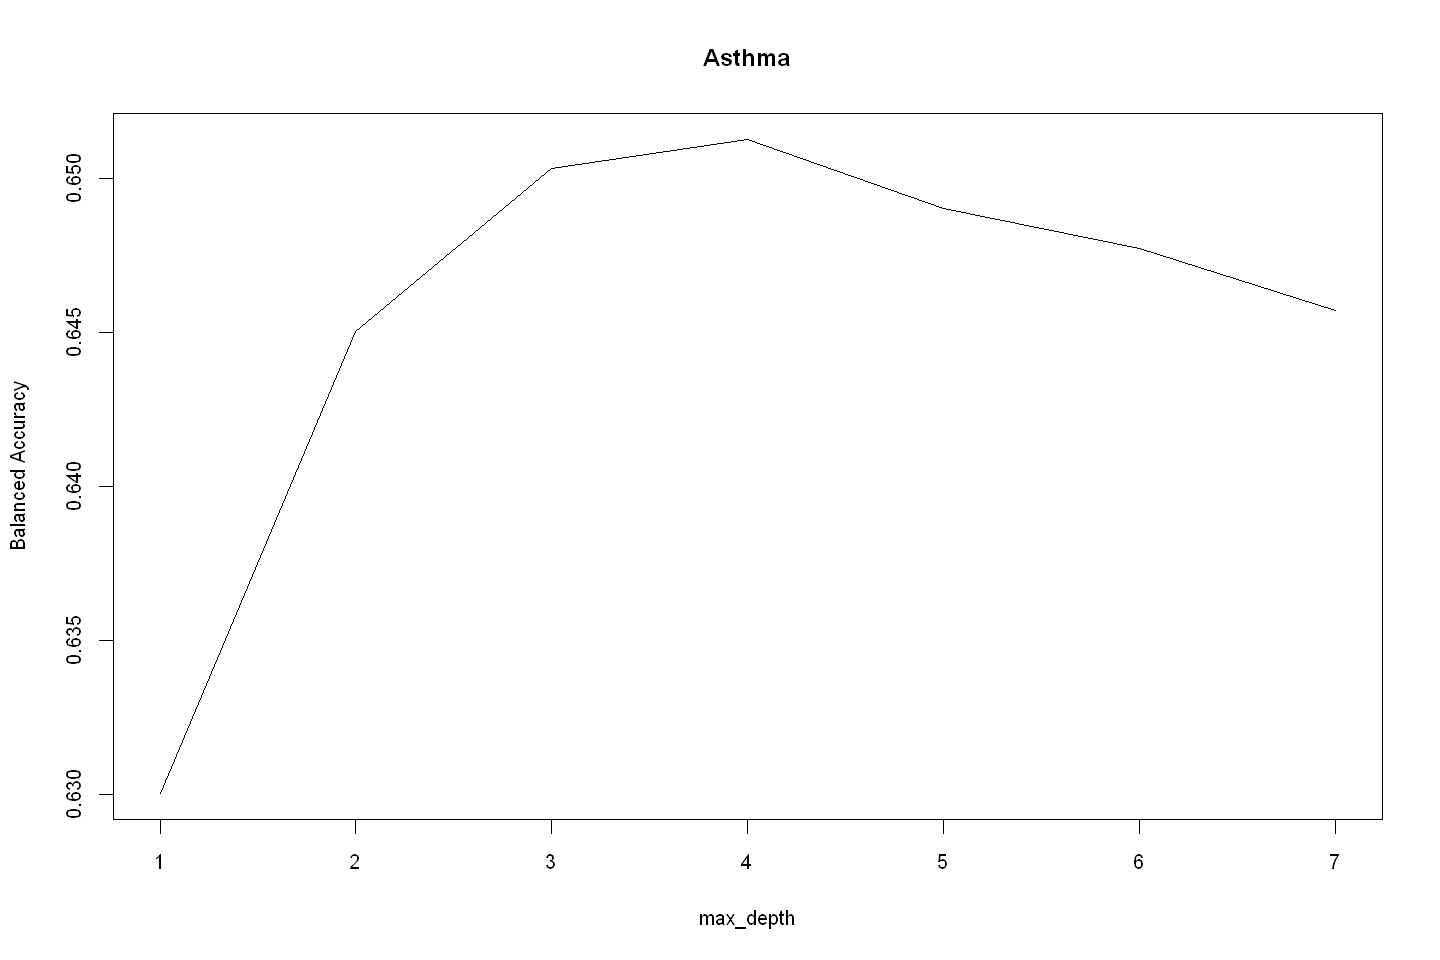

In [52]:
# Check max_depth
accuracy8<-c()
max_depth <- c(1:7)
for (i in 1:7){
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=i, eta=0.1, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[i] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(max_depth, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Asthma')
# Extract best value for max_depth
print(paste("Best max_depth:",max_depth[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best eta: 0.2"
[1] "New balanced accuracy: 0.65145827450392"


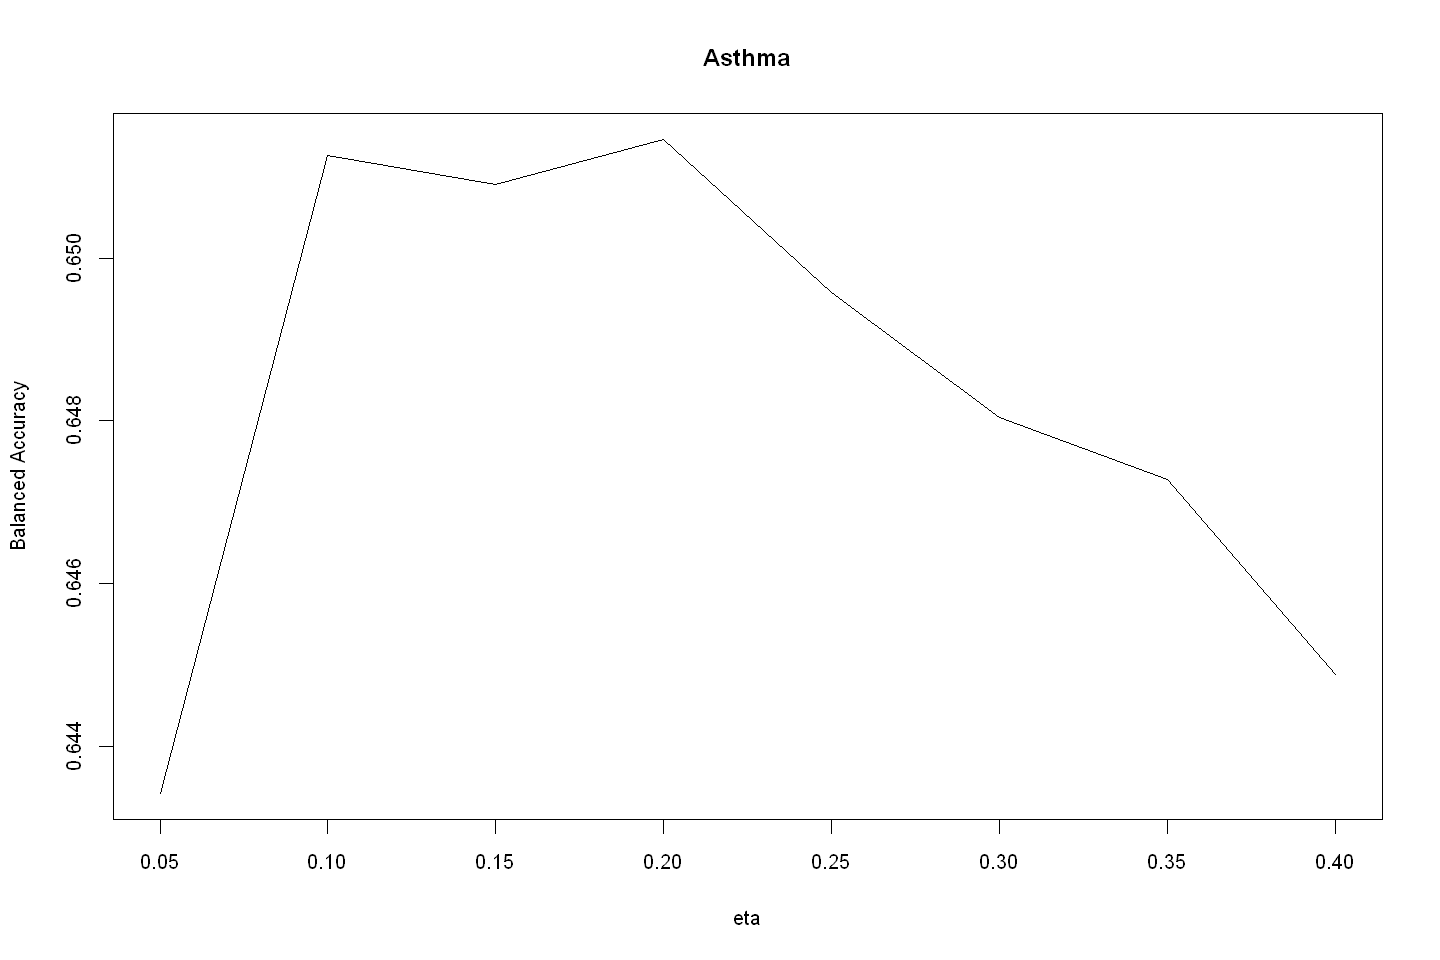

In [53]:
# Check eta
accuracy8<-c()
eta <- seq(0.05, 0.4, by=0.05)
for (i in eta){
index<-match(i,eta)
    #print(index)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=25, max_depth=4, eta=i, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(eta, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Asthma')
# Extract best value for eta
print(paste("Best eta:",eta[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))

[1] "Best nrounds: 26"
[1] "New balanced accuracy: 0.651768422435086"


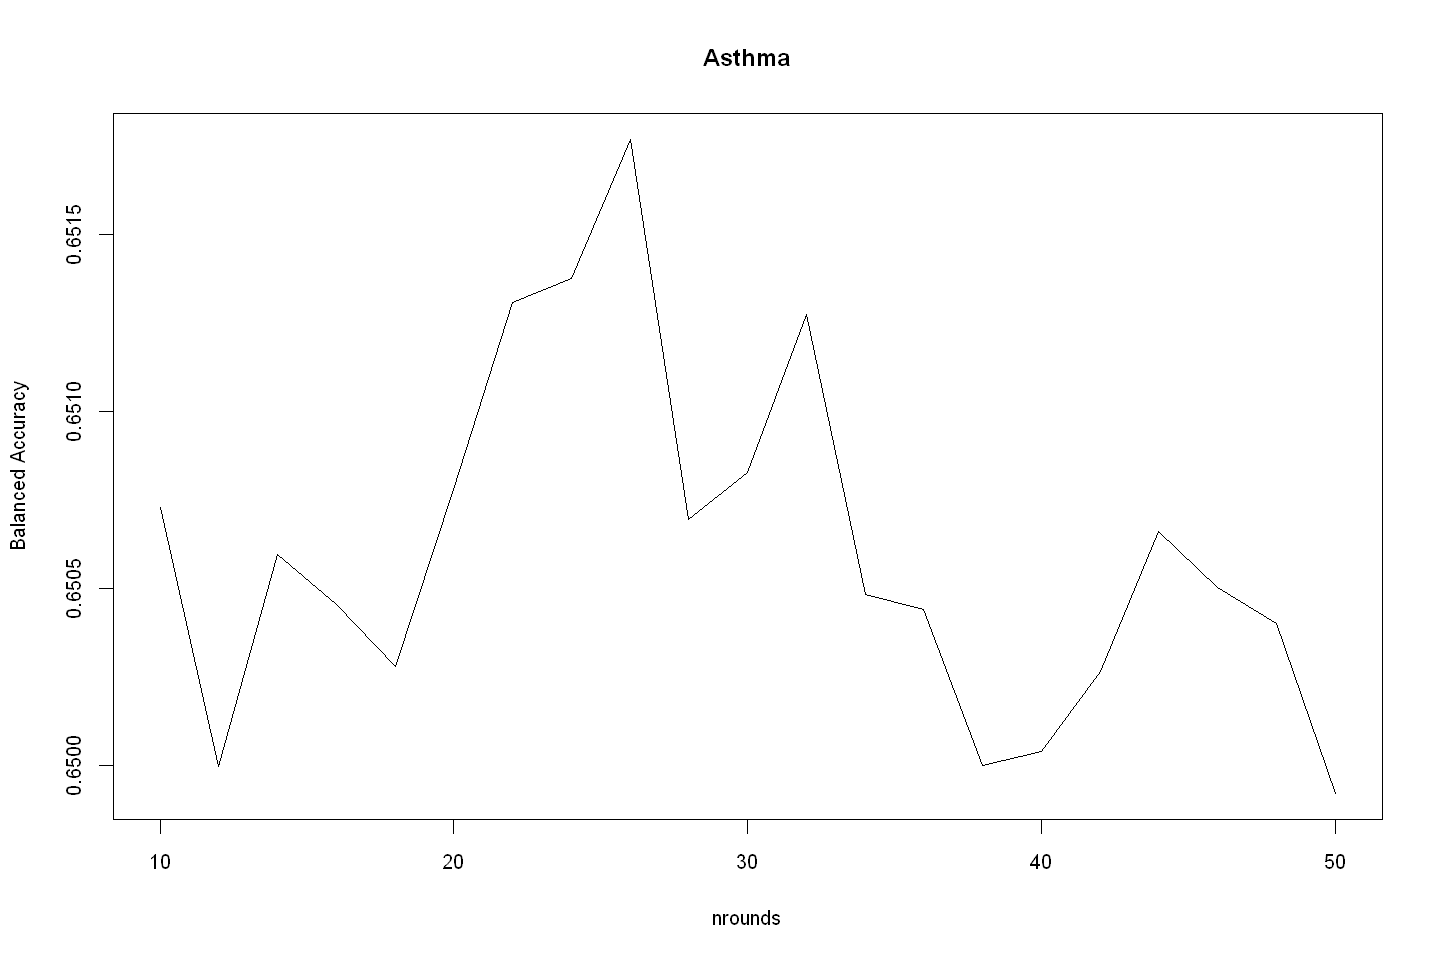

In [54]:
# Check nrounds
accuracy8<-c()
nrounds <- seq(10, 50, by=2)
for (i in nrounds){
index<-match(i,nrounds)
# Train the model with initial choice of parameters
xgbc = xgboost(data=xgb_train, nrounds=i, max_depth=4, eta=0.2, verbose=0)

# Fit and evaluate the model
pred = as.numeric(predict(xgbc,xgb_test)>0.5) # set threshold
obs = getinfo(xgb_test, "label")
cm <- table(pred,obs)

evaluation <- confusionMatrix(cm)
accuracy8[index] <- evaluation$byClass['Balanced Accuracy']
rm('xgbc', 'evaluation')
}

plot(nrounds, accuracy8, type = 'l', ylab = 'Balanced Accuracy', main = 'Asthma')
# Extract best value for nrounds
print(paste("Best nrounds:",nrounds[match(max(accuracy8),accuracy8)]))
print(paste("New balanced accuracy:",max(accuracy8)))
    

$TP
[1] 10666

$FN
[1] 5608

$TN
[1] 69222

$FP
[1] 35092

$NPV
[1] 0.9251

$FPR
[1] 0.3364

$TPR
[1] 0.6554

$TNR
[1] 0.6636

$FNR
[1] 0.3446

$threatScore
[1] 0.2076

$balancedacc
[1] 0.6595

$threshold
[1] 0.47

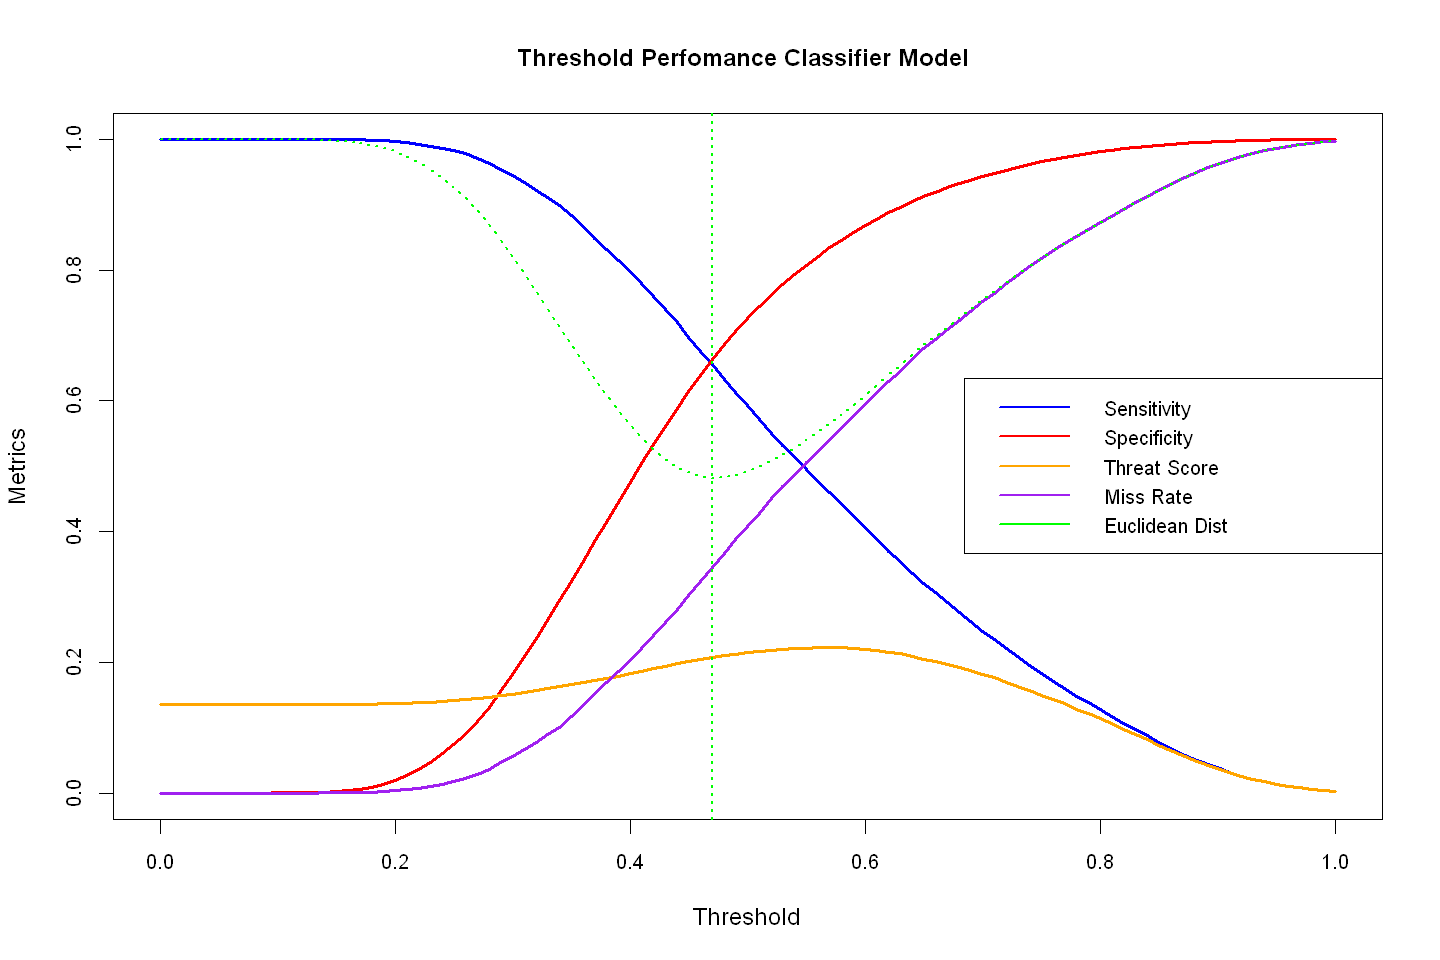

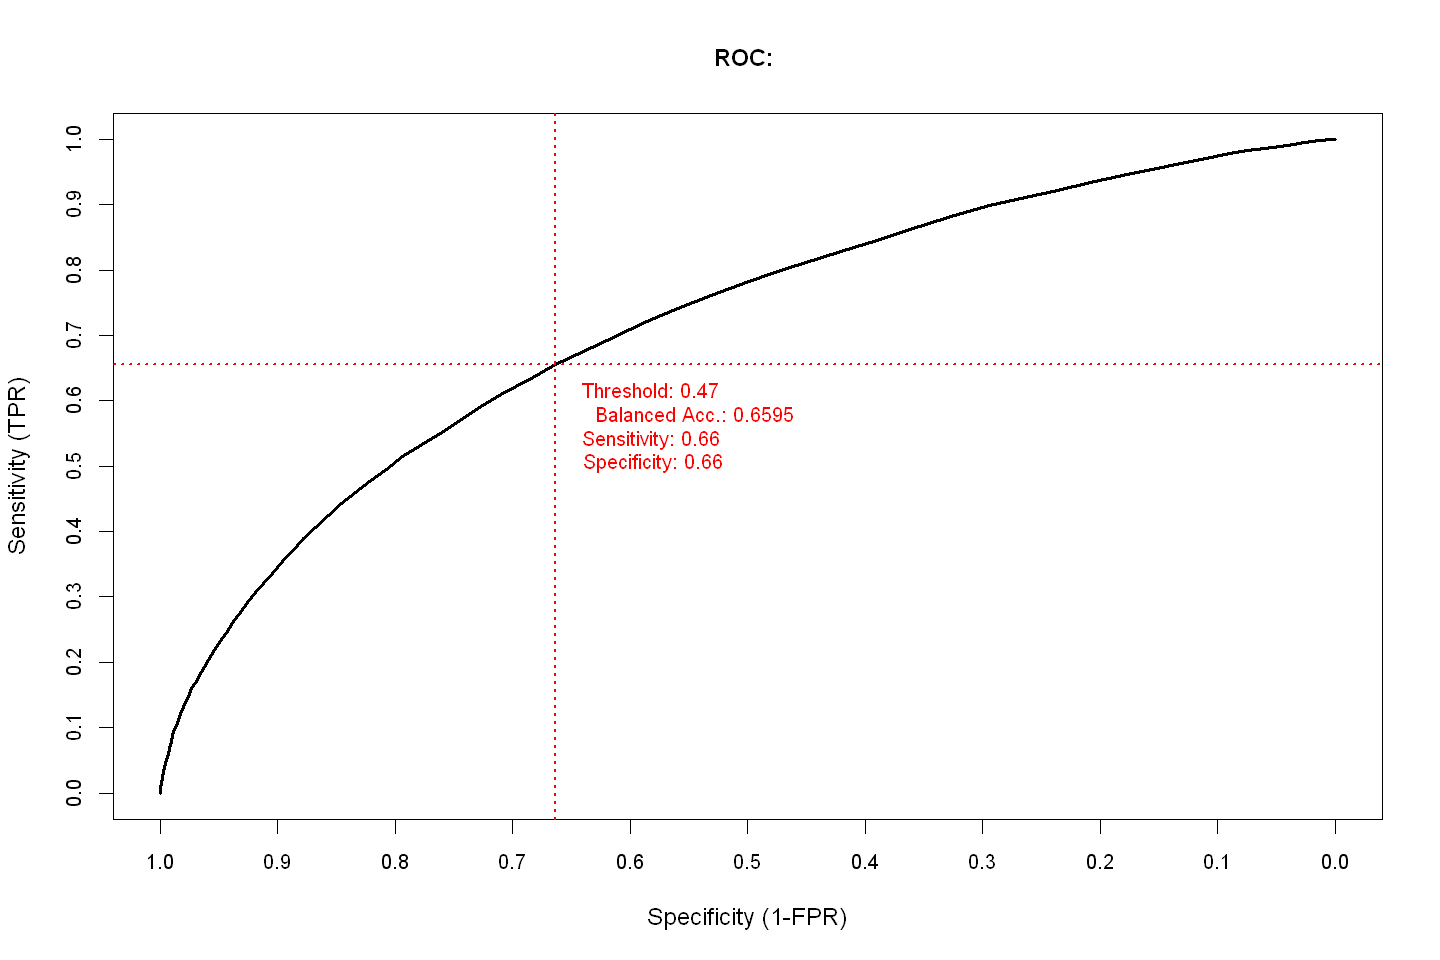

In [55]:
### Final model now trained on complete dataset ###

# ASTHMA
data_col_index = 14
train = undersampleASTH2 # full training dataset
test = test2 # full testing dataset

# Convert input training and testing data into matrix form suitable for XGBoost algorithm
train_x = data.matrix(train[,-data_col_index])
train_y = train[,data_col_index]
 
test_x = data.matrix(test[,-data_col_index])
test_y = test[,data_col_index]

# Put our testing & training data into two seperates Dmatrixs objects
xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)

# Train the model with best nrounds, max_depth, eta
xgbc = xgboost(data=xgb_train, nrounds=26, max_depth=4, eta=0.2, verbose=0)

# Fit the model
pred = predict(xgbc,xgb_test)

### Determine best threshold ###

#setting options for this cell for better viewing
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=14)

#calling function to plot graphs and view values
measures_ASTH<-getTreeClassifications(myTree = xgbc,
                                           test_y,
                                           pred,
                                           title='',
                                           plot=TRUE)

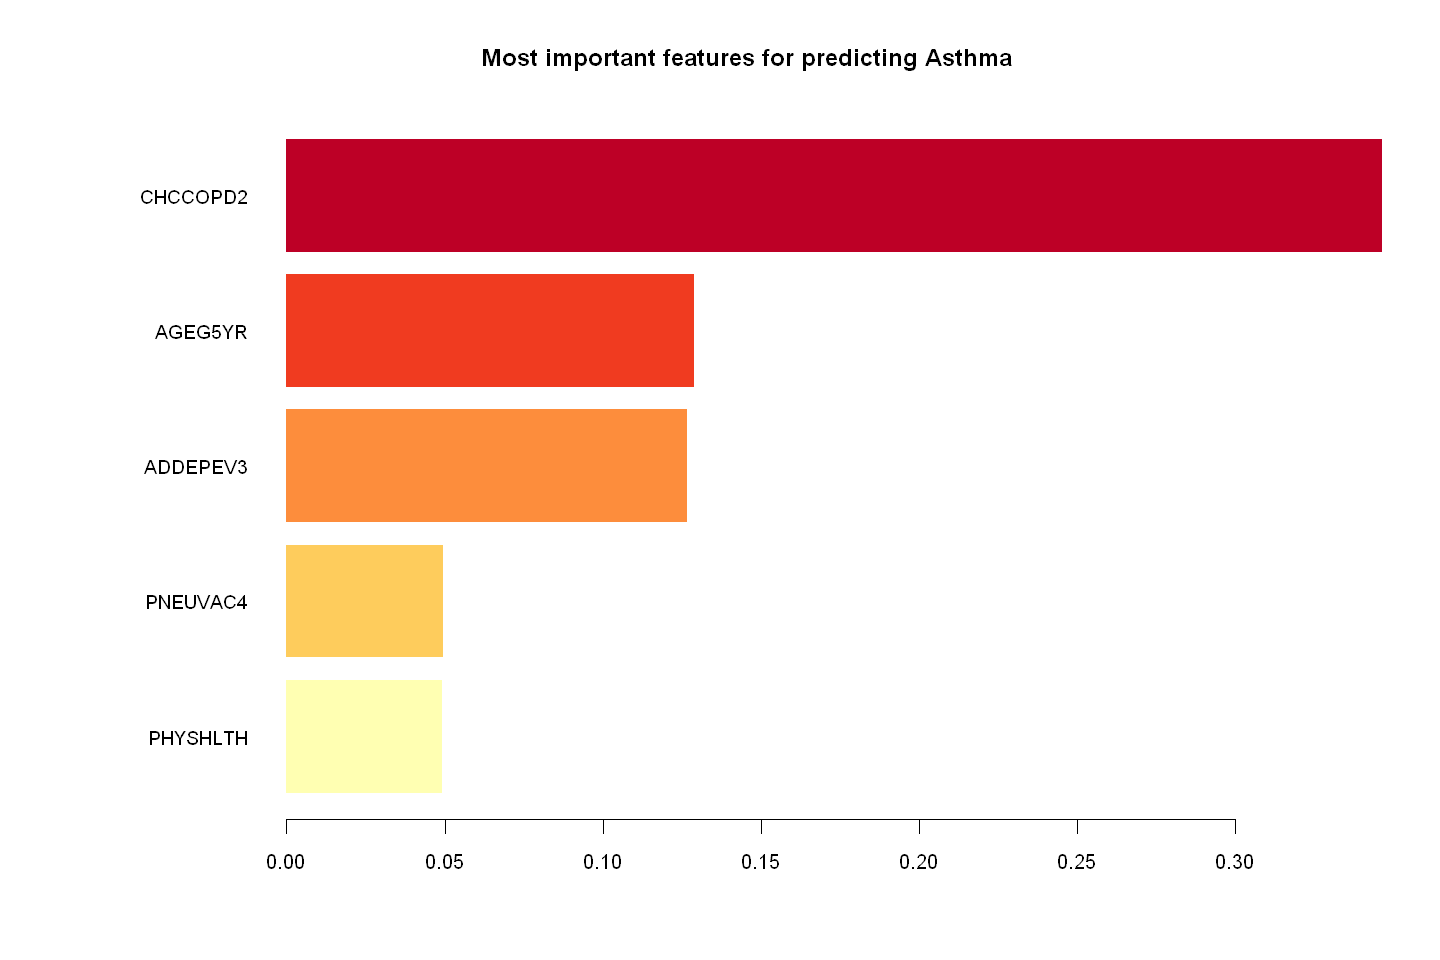

In [56]:
### Feature Importance ###

# Compute feature importance matrix
importance_matrix = xgb.importance(colnames(xgb_train), model = xgbc)

# Plotting importances
xgb.plot.importance(importance_matrix[1:5,], col=p)
title("Most important features for predicting Asthma")

In [57]:
### Save all measures into a dataframe for easy model comparison ###

measures_Diabetes
measures_LUNG
measures_CANCER
measures_ARTH
measures_KIDNEY
measures_SKIN
measures_CVD
measures_ASTH

$TP
[1] 11933

$FN
[1] 3669

$TN
[1] 77971

$FP
[1] 27015

$NPV
[1] 0.9551

$FPR
[1] 0.2573

$TPR
[1] 0.7648

$TNR
[1] 0.7427

$FNR
[1] 0.2352

$threatScore
[1] 0.28

$balancedacc
[1] 0.7538

$threshold
[1] 0.54

$TP
[1] 7526

$FN
[1] 1874

$TN
[1] 87460

$FP
[1] 23728

$NPV
[1] 0.979

$FPR
[1] 0.2134

$TPR
[1] 0.8006

$TNR
[1] 0.7866

$FNR
[1] 0.1994

$threatScore
[1] 0.2272

$balancedacc
[1] 0.7936

$threshold
[1] 0.5

$TP
[1] 8298

$FN
[1] 2688

$TN
[1] 73479

$FP
[1] 36123

$NPV
[1] 0.9647

$FPR
[1] 0.3296

$TPR
[1] 0.7553

$TNR
[1] 0.6704

$FNR
[1] 0.2447

$threatScore
[1] 0.1761

$balancedacc
[1] 0.7128

$threshold
[1] 0.53

$TP
[1] 28068

$FN
[1] 9097

$TN
[1] 60875

$FP
[1] 22548

$NPV
[1] 0.87

$FPR
[1] 0.2703

$TPR
[1] 0.7552

$TNR
[1] 0.7297

$FNR
[1] 0.2448

$threatScore
[1] 0.47

$balancedacc
[1] 0.7425

$threshold
[1] 0.52

$TP
[1] 3383

$FN
[1] 1049

$TN
[1] 84552

$FP
[1] 31604

$NPV
[1] 0.9877

$FPR
[1] 0.2721

$TPR
[1] 0.7633

$TNR
[1] 0.7279

$FNR
[1] 0.2367

$threatScore
[1] 0.0939

$balancedacc
[1] 0.7456

$threshold
[1] 0.5

$TP
[1] 8305

$FN
[1] 2500

$TN
[1] 77299

$FP
[1] 32484

$NPV
[1] 0.9687

$FPR
[1] 0.2959

$TPR
[1] 0.7686

$TNR
[1] 0.7041

$FNR
[1] 0.2314

$threatScore
[1] 0.1919

$balancedacc
[1] 0.7363

$threshold
[1] 0.54

$TP
[1] 5481

$FN
[1] 1357

$TN
[1] 91203

$FP
[1] 22547

$NPV
[1] 0.9853

$FPR
[1] 0.1982

$TPR
[1] 0.8016

$TNR
[1] 0.8018

$FNR
[1] 0.1984

$threatScore
[1] 0.1865

$balancedacc
[1] 0.8017

$threshold
[1] 0.5

$TP
[1] 10666

$FN
[1] 5608

$TN
[1] 69222

$FP
[1] 35092

$NPV
[1] 0.9251

$FPR
[1] 0.3364

$TPR
[1] 0.6554

$TNR
[1] 0.6636

$FNR
[1] 0.3446

$threatScore
[1] 0.2076

$balancedacc
[1] 0.6595

$threshold
[1] 0.47

In [58]:
df <- data.frame(matrix(ncol = 12, nrow = 0))
df[1,] <- measures_ASTH
df[2,] <- measures_SKIN
df[3,] <- measures_CVD
df[4,] <- measures_KIDNEY
df[5,] <- measures_ARTH
df[6,] <- measures_LUNG
df[7,] <- measures_Diabetes
df[8,] <- measures_CANCER
colnames(df) <- c('TP', 'FN', 'TN', 'FP', 'NPV', 'FPR', 'Sensitivity', 'Specificity', 'Miss Rate',
                  'Threat Score', 'Balanced Accuracy', 'Threshold')
dfnew <- subset(df, select = c('Sensitivity', 'Specificity', 'Miss Rate', 'Threat Score', 'Balanced Accuracy'))
rownames(dfnew) <- c('Asthma', 'Skin Cancer', 'Heart Disease', 'Kidney Disease',
                     'Arthritis', 'Lung Disease', 'Diabetes', 'Other Cancers')
print(dfnew)

               Sensitivity Specificity Miss Rate Threat Score Balanced Accuracy
Asthma              0.6554      0.6636    0.3446       0.2076            0.6595
Skin Cancer         0.7686      0.7041    0.2314       0.1919            0.7363
Heart Disease       0.8016      0.8018    0.1984       0.1865            0.8017
Kidney Disease      0.7633      0.7279    0.2367       0.0939            0.7456
Arthritis           0.7552      0.7297    0.2448       0.4700            0.7425
Lung Disease        0.8006      0.7866    0.1994       0.2272            0.7936
Diabetes            0.7648      0.7427    0.2352       0.2800            0.7538
Other Cancers       0.7553      0.6704    0.2447       0.1761            0.7128


In [59]:
write.csv(dfnew, "XGBoost_Summary.csv")